In [1]:
import numpy as np
import pandas as pd
import uproot
import xgboost as xgb
import matplotlib.pyplot as plt
from xgbo import XgboRegressor
import os
from scipy.stats import norm
import matplotlib.mlab as mlab
import iminuit
import probfit
import probfit.pdf

In [2]:
def load_data(file_name, entrystop, isEE=False):

    root_file = uproot.open(file_name)

    # The branches we need for the regression
    branches_EB = [ 'clusterRawEnergy', 'full5x5_e3x3', 'full5x5_eMax',
            'full5x5_e2nd', 'full5x5_eTop', 'full5x5_eBottom', 'full5x5_eLeft',
            'full5x5_eRight', 'full5x5_e2x5Max', 'full5x5_e2x5Top',
            'full5x5_e2x5Bottom', 'full5x5_e2x5Left', 'full5x5_e2x5Right',
            'full5x5_e5x5', 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
            'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
            'full5x5_sigmaIphiIphi', 'iEtaSeed', 'iPhiSeed', 'iEtaMod5',
            'iPhiMod2', 'iEtaMod20', 'iPhiMod20', 'genEnergy']

    branches_EE = [ 'clusterRawEnergy', 'full5x5_e3x3', 'full5x5_eMax',
            'full5x5_e2nd', 'full5x5_eTop', 'full5x5_eBottom', 'full5x5_eLeft',
            'full5x5_eRight', 'full5x5_e2x5Max', 'full5x5_e2x5Top',
            'full5x5_e2x5Bottom', 'full5x5_e2x5Left', 'full5x5_e2x5Right',
            'full5x5_e5x5', 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
            'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
            'full5x5_sigmaIphiIphi',
            'genEnergy', 'iXSeed', 'iYSeed', 'preshowerEnergy']

    if isEE:
        branches = branches_EE + ["pt", "eta"]
    else:
        branches = branches_EB + ["pt", "eta"]

    if "Electron" in file_name:
        df = root_file['een_analyzer/ElectronTree'].pandas.df(branches, entrystop=entrystop).dropna()
    if "Photon" in file_name:
        df = root_file['een_analyzer/PhotonTree'].pandas.df(branches, entrystop=entrystop).dropna()
    print("Entries in ntuple:")
    print(len(df))
    print(df.shape)


    df.eval("clusertRawEnergyOverE5x5 = clusterRawEnergy/full5x5_e5x5", inplace=True)
    df.eval("w3x3OverE5x5             = full5x5_e3x3/full5x5_e5x5", inplace=True)
    df.eval("eMaxOverE5x5             = full5x5_eMax/full5x5_e5x5", inplace=True)
    df.eval("e2ndOverE5x5             = full5x5_e2nd/full5x5_e5x5", inplace=True)
    df.eval("eTopOverE5x5             = full5x5_eTop/full5x5_e5x5", inplace=True)
    df.eval("eBottomOverE5x5          = full5x5_eBottom/full5x5_e5x5", inplace=True)
    df.eval("eLeftOverE5x5            = full5x5_eLeft/full5x5_e5x5", inplace=True)
    df.eval("eRightOverE5x5           = full5x5_eRight/full5x5_e5x5", inplace=True)
    df.eval("e2x5MaxOverE5x5          = full5x5_e2x5Max/full5x5_e5x5", inplace=True)
    df.eval("e2x5TopOverE5x5          = full5x5_e2x5Top/full5x5_e5x5", inplace=True)
    df.eval("e2x5BottomOverE5x5       = full5x5_e2x5Bottom/full5x5_e5x5", inplace=True)
    df.eval("e2x5LeftOverE5x5         = full5x5_e2x5Left/full5x5_e5x5", inplace=True)
    df.eval("e2x5RightOverE5x5        = full5x5_e2x5Right/full5x5_e5x5", inplace=True)

    if isEE:
        df.eval("preshowerEnergyOverrawEnergy = preshowerEnergy/rawEnergy", inplace=True)

    # The target
    if isEE:
        df.eval("target = ( rawEnergy + preshowerEnergy )/genEnergy", inplace=True)
    else:
        df.eval("target = rawEnergy/genEnergy", inplace=True)

    return df


In [3]:
# The features
features_EB = [ 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
        'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
        'full5x5_sigmaIphiIphi', 'clusertRawEnergyOverE5x5', 'w3x3OverE5x5',
        'eMaxOverE5x5', 'e2ndOverE5x5', 'eTopOverE5x5', 'eBottomOverE5x5',
        'eLeftOverE5x5', 'eRightOverE5x5', 'e2x5MaxOverE5x5',
        'e2x5TopOverE5x5', 'e2x5BottomOverE5x5', 'e2x5LeftOverE5x5',
        'e2x5RightOverE5x5', 'iEtaSeed', 'iPhiSeed', 'iEtaMod5', 'iPhiMod2',
        'iEtaMod20', 'iPhiMod20','pt','eta','target']

# EE
features_EE = [ 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
        'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
        'full5x5_sigmaIphiIphi', 'clusertRawEnergyOverE5x5', 'w3x3OverE5x5',
        'eMaxOverE5x5', 'e2ndOverE5x5', 'eTopOverE5x5', 'eBottomOverE5x5',
        'eLeftOverE5x5', 'eRightOverE5x5', 'e2x5MaxOverE5x5',
        'e2x5TopOverE5x5', 'e2x5BottomOverE5x5', 'e2x5LeftOverE5x5',
        'e2x5RightOverE5x5', 'iXSeed', 'iYSeed', 'preshowerEnergyOverrawEnergy','pt','eta','target']


file_name = "/scratch/micheli/Electron/perfectIC-lowpt-EB-training.root"


isEE = '-EE-' in file_name

if isEE:
    features = features_EE
else:
    features = features_EB
DF= load_data(file_name, entrystop=1500000,isEE=isEE)



Entries in ntuple:
3428975
(3428975, 30)


In [4]:
DF=DF.query('pt>20')

#  Parameter

train-effrms-mean
1


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


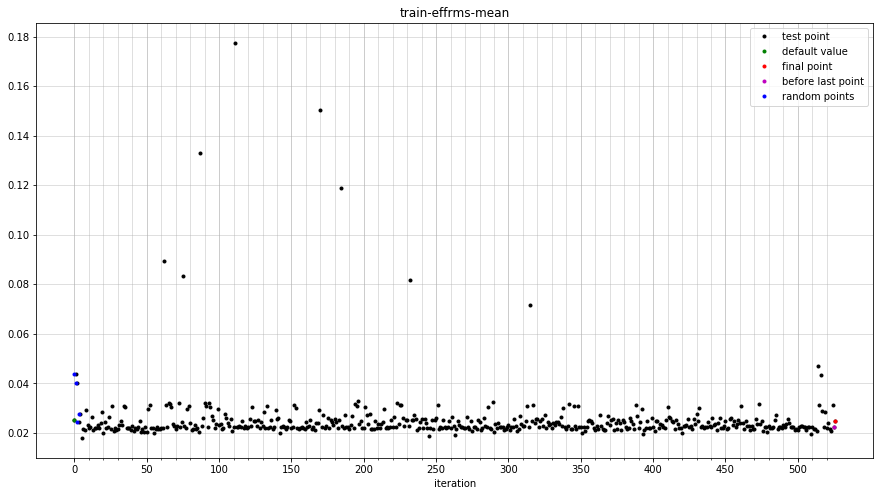

0.002196199999999999


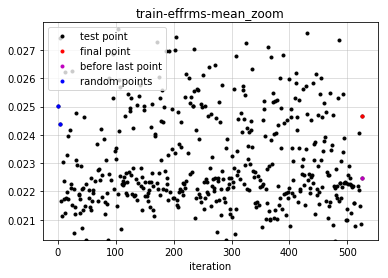

train-effrms-std
2


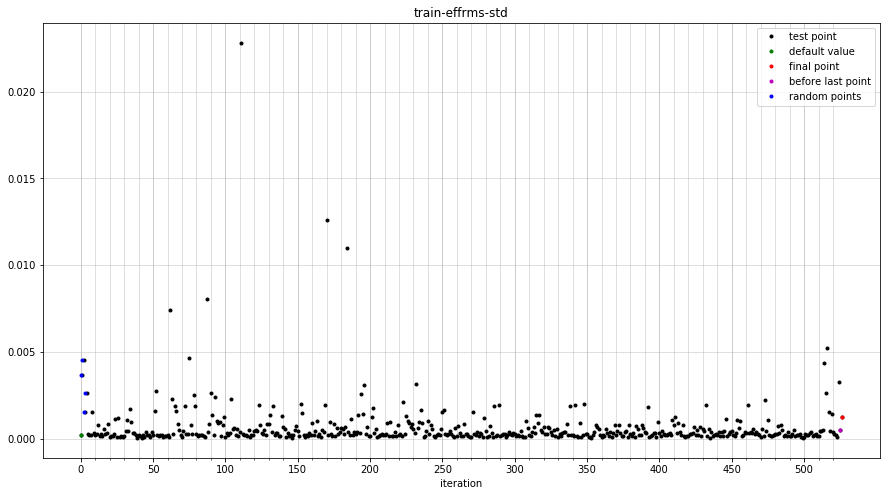

0.0007455826722960792


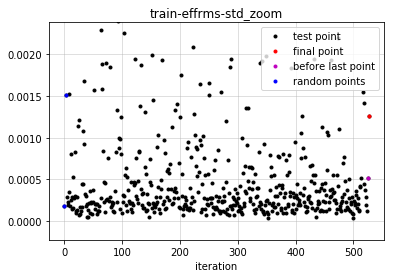

test-effrms-mean
3


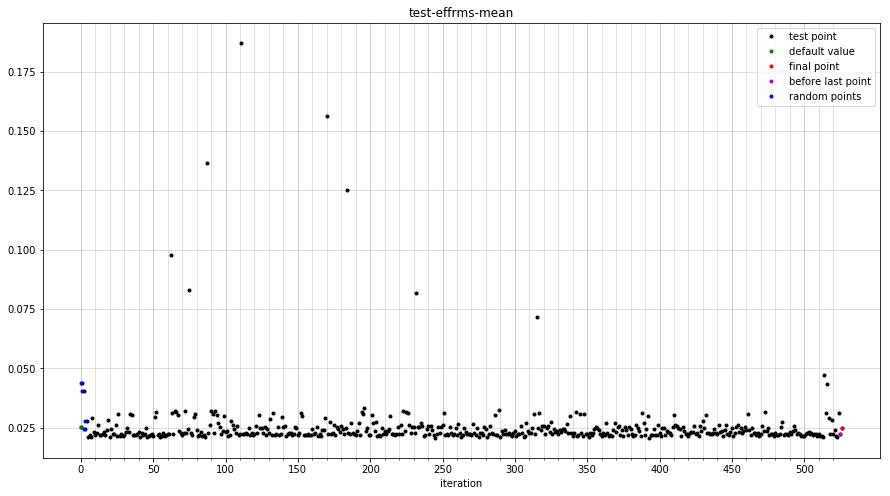

0.002210399999999998


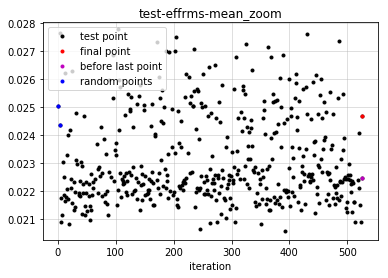

test-effrms-std
4


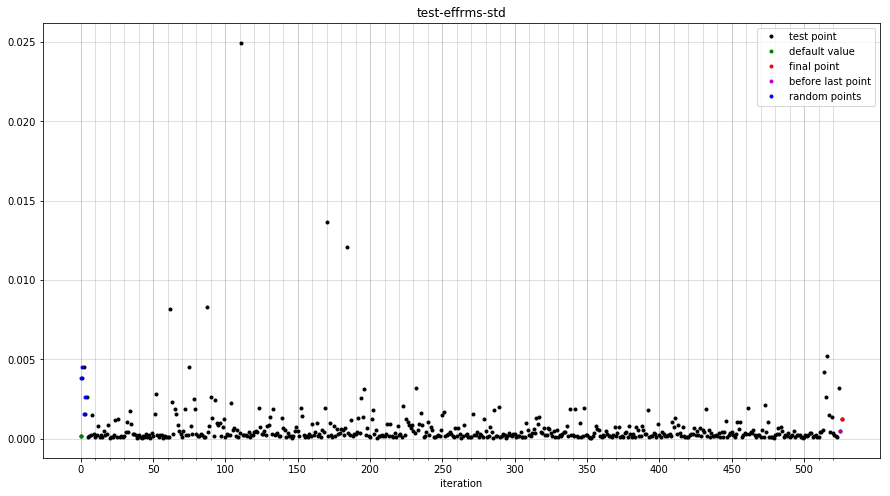

0.0007673685905220431


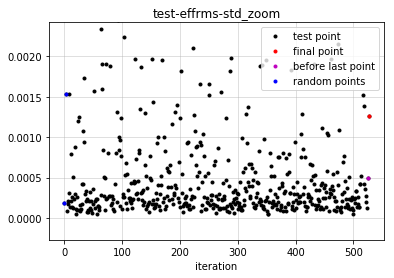

min_child_weight
5


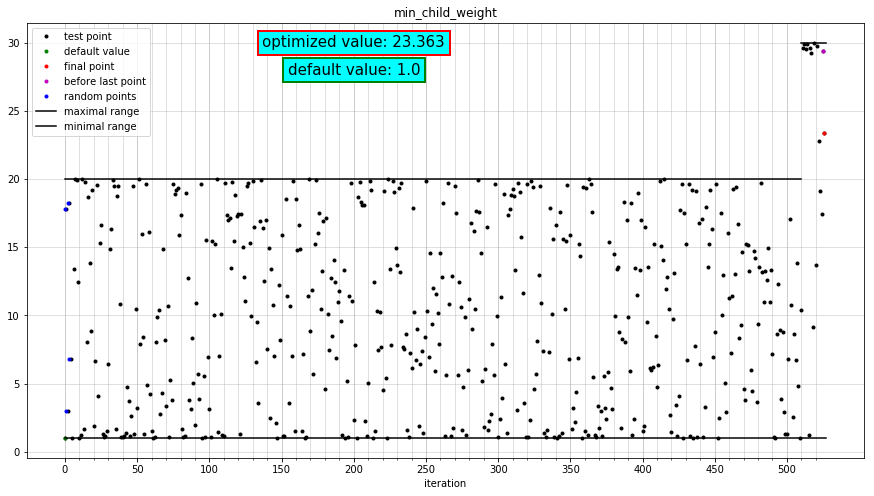

6.035600983048035


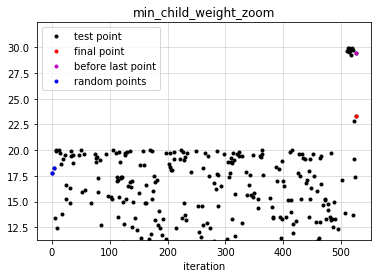

colsample_bytree
6


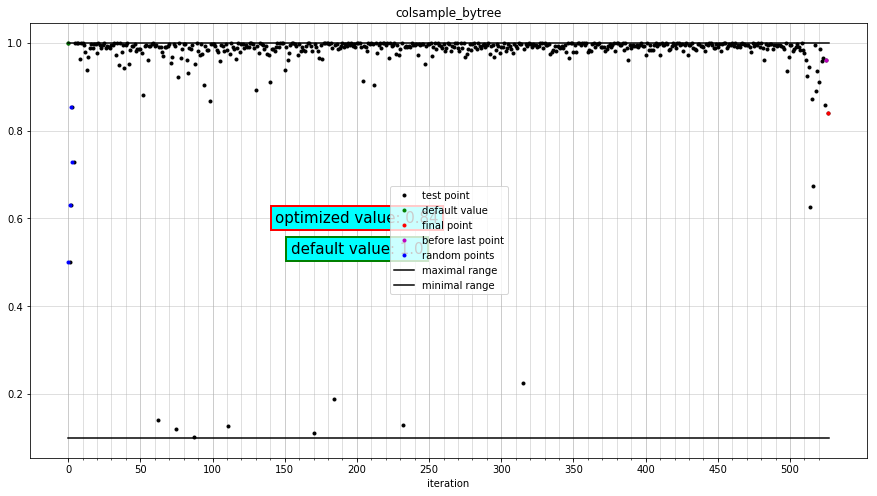

0.12152538038221938


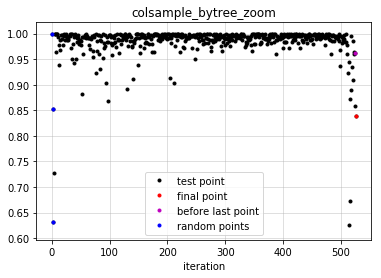

max_depth
7


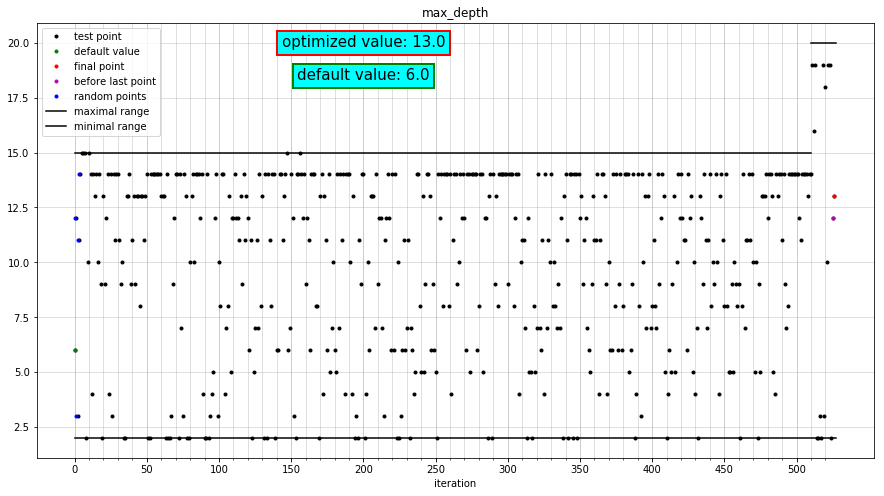

1


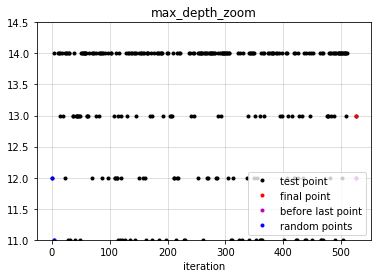

gamma
8


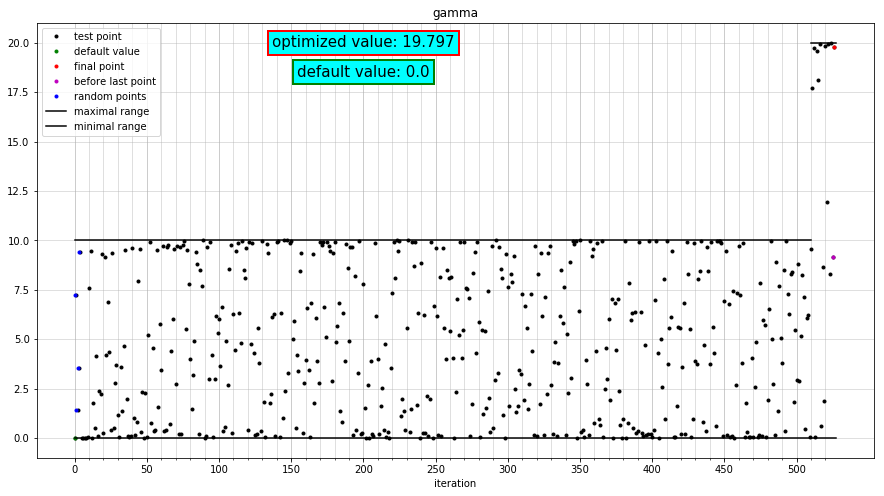

10.619304352827424


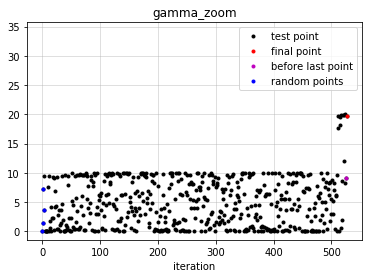

reg_lambda
9


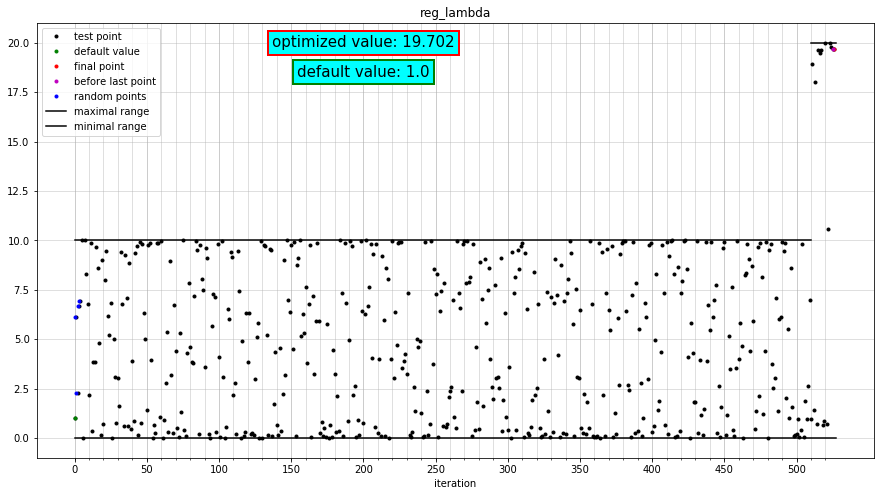

0.002037984252481806


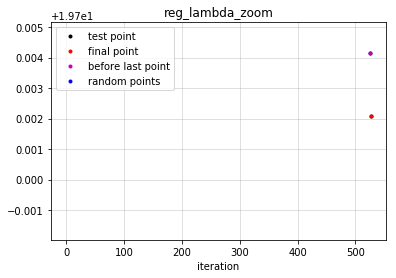

n_estimators
10


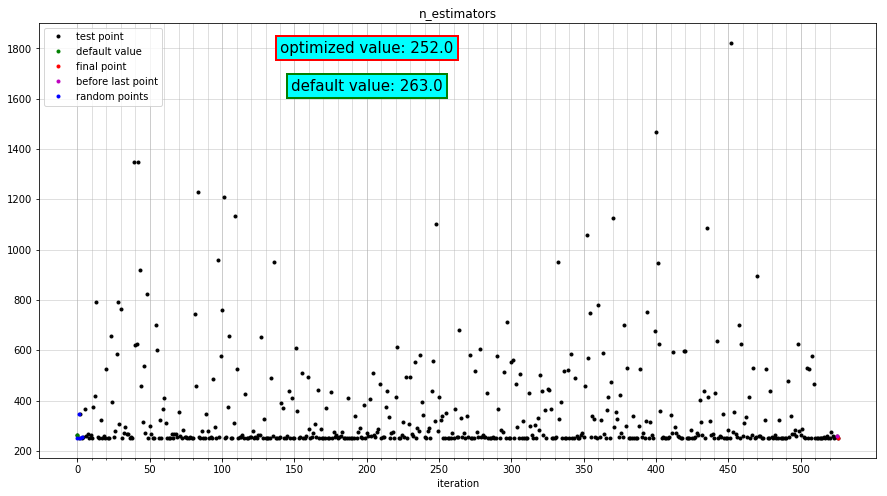

8


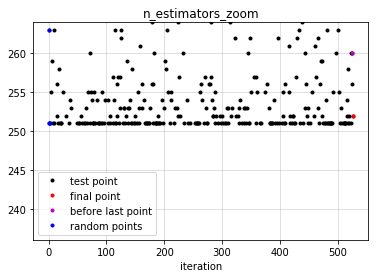

callback
11


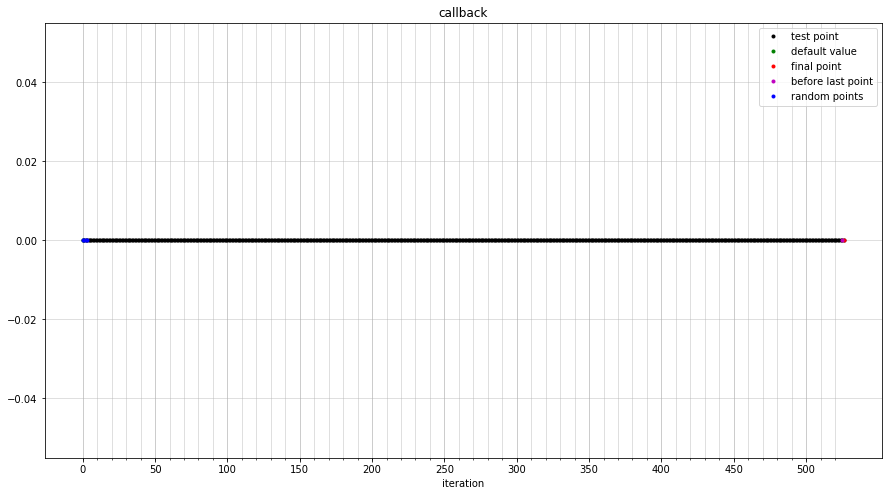

0


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


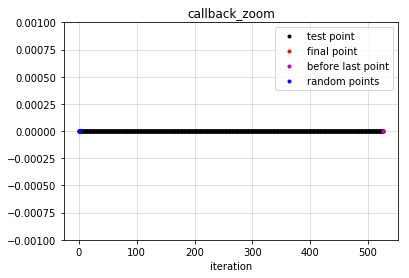

In [5]:
out_dir='/work/okiss/SemesterProject_2/final_work/Energy_Regression_test/'
parameter=pd.read_csv(out_dir+'Electron_perfectIC-lowpt-EB_test2019049/summary.csv')
rangemax1=np.array([20,1,15,10,10])
rangemax2=np.array([30,1,20,20,20])
changerange=510  
rangemin=np.array([1,0.1,2,0,0])
i=0
j=0
for para in parameter.columns:
    if i==0:
        para0=para
    else:
        print para
        print(i)
        plt.figure(figsize=(15,8))
        plt.subplot(111).plot(parameter[para0],parameter[para],'k.',label='test point')
        plt.subplot(111).plot(parameter[para0].iloc[0],parameter[para].iloc[0],'g.',label='default value')
        plt.subplot(111).plot(parameter[para0].iloc[-1],parameter[para].iloc[-1],'r.',label='final point')
        plt.subplot(111).plot(parameter[para0].iloc[-2],parameter[para].iloc[-2],'m.',label='before last point')
        plt.subplot(111).plot(parameter[para0].iloc[:4],parameter[para].iloc[1:5],'b.',label='random points')  
        plt.title(para)
        sbox=dict(boxstyle="square,pad=0.3", fc="cyan", ec="g", lw=2)
        bbox_props = dict(boxstyle="square,pad=0.3", fc="cyan", ec="r", lw=2)
        if i==6:
            yannot=0.6
            bbox_props = dict(boxstyle="square,pad=0.3", fc="cyan", ec="r", lw=2)
            sbox=dict(boxstyle="square,pad=0.3", fc="cyan", ec="g", lw=2)
            t = plt.text(200, yannot,'optimized value: '+str(round(parameter[para].iloc[-1],3)), ha="center", va="center", rotation=0,
            size=15,
            bbox=bbox_props)
            s = plt.text(200, yannot-0.07,'default value: '+str(round(parameter[para].iloc[0],3)), ha="center", va="center", rotation=0,
            size=15,
            bbox=sbox)
        elif i==7 or i==8 or i==9:
            yannot=20
            bbox_props = dict(boxstyle="square,pad=0.3", fc="cyan", ec="r", lw=2)
            t = plt.text(200, yannot,'optimized value: '+str(round(parameter[para].iloc[-1],3)), ha="center", va="center", rotation=0,
            size=15,
            bbox=bbox_props)
            s = plt.text(200, yannot-1.5,'default value: '+str(round(parameter[para].iloc[0],3)), ha="center", va="center", rotation=0,
            size=15,
            bbox=sbox)
        elif i==5:
            yannot=30
            bbox_props = dict(boxstyle="square,pad=0.3", fc="cyan", ec="r", lw=2)
            t = plt.text(200, yannot,'optimized value: '+str(round(parameter[para].iloc[-1],3)), ha="center", va="center", rotation=0,
            size=15,
            bbox=bbox_props)
            s = plt.text(200, yannot-2,'default value: '+str(round(parameter[para].iloc[0],3)), ha="center", va="center", rotation=0,
            size=15,
            bbox=sbox)
        elif i==10:
            yannot=1800
            bbox_props = dict(boxstyle="square,pad=0.3", fc="cyan", ec="r", lw=2)
            t = plt.text(200, yannot,'optimized value: '+str(round(parameter[para].iloc[-1],3)), ha="center", va="center", rotation=0,
            size=15,
            bbox=bbox_props)
            s = plt.text(200, yannot-150,'default value: '+str(round(parameter[para].iloc[0],3)), ha="center", va="center", rotation=0,
            size=15,
            bbox=sbox)
        else:
            pass
        
        
        plt.xlabel('iteration')
        major_ticks = np.arange(0, np.size(parameter[para0]), 50)
        minor_ticks = np.arange(0, np.size(parameter[para0]), 10)
        ax=plt.subplot(111)
        ax.set_xticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        

        plt.subplot(111).grid(which='both', alpha=0.2)
        plt.subplot(111).grid(which='both', alpha=0.5)

        
        
        if 4<i<10:
            one=np.linspace(0,np.size(parameter[para0]),1000)
            one1=np.linspace(0,np.size(parameter[para0][:changerange]),1000)
            one2=np.linspace(changerange,np.size(parameter[para0]),1000)
            plt.subplot(111).plot(one1,np.ones_like(one1)*rangemax1[j],'k-',label='maximal range')
            plt.subplot(111).plot(one2,np.ones_like(one2)*rangemax2[j],'k-')
            plt.subplot(111).plot(one,np.ones_like(one)*rangemin[j],'k-',label='minimal range')
            j+=1
        chartBox = plt.subplot(111).get_position()
        #plt.subplot(111).set_position([chartBox.x0, chartBox.y0, chartBox.width, chartBox.height])
        #plt.subplot(111).legend(loc='upper center', bbox_to_anchor=(1.15, 1.005), shadow=True, ncol=1)
        if i==10:
            plt.legend(loc='upper left')
        else:
            plt.legend()
        plt.savefig(os.path.join(out_dir+'plot', para+'_evolution'+'.png'))
        plt.show()
        plt.figure()
        plt.plot(parameter[para0],parameter[para],'k.',label='test point')
        plt.plot(parameter[para0].iloc[-1],parameter[para].iloc[-1],'r.',label='final point')
        plt.plot(parameter[para0].iloc[-2],parameter[para].iloc[-2],'m.',label='before last point')
        plt.plot(parameter[para0].iloc[:4],parameter[para].iloc[:4],'b.',label='random points') 
        plt.title(para+'_zoom')
        plt.xlabel('iteration')
        plt.grid(which='minor', alpha=0.2)
        plt.grid(which='major', alpha=0.5)

        zoom=(parameter[para].iloc[-1]-parameter[para].iloc[-2])
        zoom=abs(zoom)
        plt.ylim(parameter[para].iloc[-1]-2*zoom,parameter[para].iloc[-1]+1.5*zoom)
        print(zoom)
        plt.legend()
        plt.savefig(os.path.join(out_dir+'plot', para+'_evolution_zoom'+'.png'))
        plt.show()
        
    i+=1

#  Data

Entries in ntuple:
3428975
(3428975, 30)


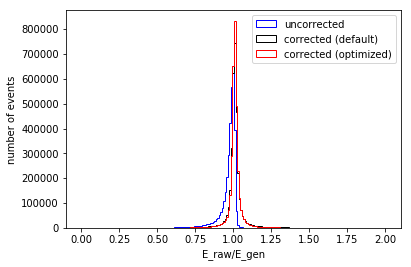

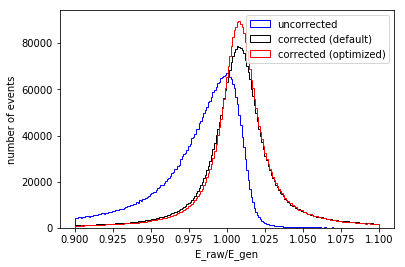

In [6]:
df_test  = load_data(file_name, isEE=isEE, entrystop=1500000)
X_test  = df_test[features_EB]
y_test  = df_test["target"]
xgtest  = xgb.DMatrix(X_test , label=y_test)

xgbo_default = xgb.Booster({'nthread':4}) #init model
#xgbo_default.load_model("Photon_perfectIC-highpt-EB/model_default/model.bin") # load data
xgbo_default.load_model(out_dir+"Electron_perfectIC-lowpt-EB_test20190124/model_default/model.bin")
xgbo_bo = xgb.Booster({'nthread':4}) #init model
#xgbo_bo.load_model("Photon_perfectIC-highpt-EB/model_optimized/model.bin") # load data
xgbo_bo.load_model(out_dir+"Electron_perfectIC-lowpt-EB_test20190124/model_optimized/model.bin") # load data

preds_default = xgbo_default.predict(xgtest)
preds_bo      = xgbo_bo.predict(xgtest)

# preds = 1.

# Etrue / Eraw after applying corrections
z_default = preds_default / (df_test['genEnergy']/df_test['rawEnergy'])
z_bo      = preds_bo / (df_test['genEnergy']/df_test['rawEnergy'])

bins = np.linspace(0.0, 2.0, 200)
bins_zoom = np.linspace(0.9, 1.1, 200)

plt.figure()
plt.hist(df_test['rawEnergy']/df_test['genEnergy'], bins=bins, histtype='step',color='blue', label="uncorrected")
plt.hist(z_default, bins=bins, histtype='step',color='black', label='corrected (default)')
plt.hist(z_bo, bins=bins, histtype='step',color='red', label='corrected (optimized)')
plt.legend()
plt.xlabel('E_raw/E_gen')
plt.ylabel('number of events')
plt.savefig(os.path.join(out_dir+'plot','energy_comparaison'+'.png'))


plt.figure()

plt.hist(df_test['rawEnergy']/df_test['genEnergy'], bins=bins_zoom, histtype='step',color='blue', label="uncorrected")
plt.hist(z_default, bins=bins_zoom, histtype='step',color='black', label='corrected (default)')
plt.hist(z_bo, bins=bins_zoom, histtype='step',color='red', label='corrected (optimized)')
plt.legend()
plt.xlabel('E_raw/E_gen')
plt.ylabel('number of events')
plt.savefig(os.path.join(out_dir+'plot','energy_comparaison_zoom'+'.png'))
plt.show()

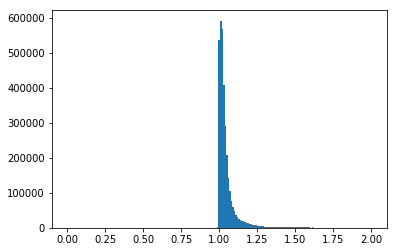

In [7]:
plt.figure()
plt.hist(preds_bo,bins)
plt.show()

In [8]:
data=pd.DataFrame()
data['eta']=df_test['eta']
data['pt']=df_test['pt']
data['target']=df_test['target']
data['z_default']=z_default
data['z_bo']=z_bo
print(data.columns)

Index([u'eta', u'pt', u'target', u'z_default', u'z_bo'], dtype='object')


# RMS and effective sigma


In [9]:
def evaleffrms(hist, bin_edge, c=0.683):
    event=np.sum(hist)
    m=c*event
    a=[]
    b=[]
    for i in range (len(hist)):
        sum=0
        for j in range(i,len(hist)):
            if sum>=m:
                a.append(i)
                b.append(j)
                break
            else:
                sum+=hist[j]
    l=len(a)
    interval=np.zeros((l))
    for i in range(l):
        interval[i]=bin_edge[b[i]]-bin_edge[a[i]]
    effrms=np.min(interval)/2
    return(effrms)
def RMS(hist,bin_edge):
    event=np.sum(hist)
    sum=0
    for i in range(len(hist)):
        sum+=((bin_edge[i+1]+bin_edge[i])/2)**2*hist[i]
    rms=np.sqrt(sum/event)
    return rms
def histsigma(hist,bin_edge):
    N=np.sum(hist)
    bin_edge_middle=np.zeros((len(hist)))
    for i in range (len(hist)):
        bin_edge_middle[i]=(bin_edge[i]+bin_edge[i+1])/2
        
    mean=np.sum(bin_edge_middle*hist)/N
    variance=0
    print(mean)
    for i in range(len(hist)):
        variance+=hist[i]*(bin_edge_middle[i]-mean)**2
    variance=variance/N
    sigma=np.sqrt(variance)
    return sigma

1.0016902789472852
1.0003289249893663
1000.0
1335.8649340408633
0.0006136301098579424
1.0003287367802995


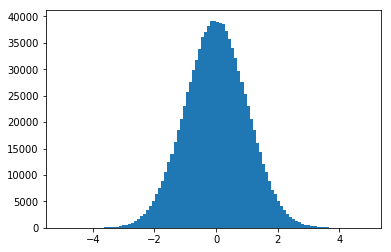

In [10]:
x=np.random.normal(loc=0,scale=1,size=1000000)
q,w=np.histogram(x,bins=1000)
plt.hist(x,bins=100)
print(evaleffrms(q,w))
print(RMS(q,w))
print(np.mean(q))
print(np.sqrt(np.mean(np.square(q-np.mean(q)))))
print(histsigma(q,w))

# ETA

In [ ]:
n=16
feat=[]
eta=np.zeros((n))
for i in range (n):
    a=1.4-0.2*i
    b=a+0.2
    eta[i]= (a+b)/2
    feat.append(str(a)+'<eta<'+str(b))
i=0
for para in feat:
    rmin = 0.83
    rmax = 1.2
    plt.figure()
    df=data.query(para).astype('double')
    dft=df.query(str(rmin)+'<target<'+str(rmax)).astype('double')
    dfd=df.query(str(rmin)+'<z_default<'+str(rmax)).astype('double')
    dfo=df.query(str(rmin)+'<z_bo<'+str(rmax)).astype('double')
    nbins = 200
    plt.hist(dft['target'],bins=nbins,histtype='step',color='blue',label='uncorrected',density=0)
    plt.hist(dfd['z_default'],bins=nbins,histtype='step',color='black',label='corrected (default)',density=0)
    plt.hist(dfo['z_bo'],bins=nbins,histtype='step',color='red',label='corrrected (optimized)',density=0)
    plt.title(para)
    plt.legend(loc=2)
    plt.savefig(os.path.join(out_dir+'plot','split_in_eta_'+para+'.png'))
    
    plt.show()
    #plt.ylim([0,500])
    
    #surface_hist=sum(out[0][:]*np.diff(out[1][:]))
   
   
    
   

In [ ]:
Tipe=['target','z_default','z_bo']
n=16

mean_eta_un=np.zeros((n))
mean_eta_de=np.zeros((n))
mean_eta_bo=np.zeros((n))

mean_err_eta_un=np.zeros((n))
mean_err_eta_de=np.zeros((n))
mean_err_eta_bo=np.zeros((n))

sigma_eta_un=np.zeros((n))
sigma_eta_de=np.zeros((n))
sigma_eta_bo=np.zeros((n))

Eff_sigma_eta_un=np.zeros((n))
Eff_sigma_eta_de=np.zeros((n))
Eff_sigma_eta_bo=np.zeros((n))

rms_eta_un=np.zeros((n))
rms_eta_de=np.zeros((n))
rms_eta_bo=np.zeros((n))

histsigma_eta_un=np.zeros((n))
histsigma_eta_de=np.zeros((n))
histsigma_eta_bo=np.zeros((n))

sigma_err_eta_un=np.zeros((n))
sigma_err_eta_de=np.zeros((n))
sigma_err_eta_bo=np.zeros((n))

quantile_eta_un=np.zeros((3,n))
quantile_eta_bo=np.zeros((3,n))

feat=[]
eta=np.zeros((n))
nbins=500
for i in range (n):
    a=1.4-0.2*i
    b=a+0.2
    eta[i]= (a+b)/2
    feat.append(str(a)+'<eta<'+str(b))
i=0
for tipe in Tipe:
    for para in feat:
        if tipe=='target':
            rmin = 0.83
            rmax = 1.1 # before 1.1
        else:
            rmin=0.85
            rmax=1.15 #1.2
        df=data.query(para).astype('double')
        df=df[tipe]
        bound_DCB=[rmin, rmax]
        plt.figure()
        hist,bin_edge=np.histogram(df,bins=nbins)
        plt.show()
        
        a=RMS(hist,bin_edge)
        b=evaleffrms(hist,bin_edge)
        c=histsigma(hist,bin_edge)
            
        normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
        binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
   
        for j in range(2):
        #first step
            if j==0: 
                pars_dcb = dict(mean  = 0.97, 
                        fix_mean = False,
                        sigma  = 0.01,
                        fix_sigma = False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 6,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 4,
                        fix_n2  = False
        
                           )
        
                           
        #optimize parameter withoptimized start parameter
            else:
                pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
    
            minuit = iminuit.Minuit(binned_likelihood,print_level=3, **pars_dcb)
            minuit.migrad() #optimized parameter
     
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
        binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
        if tipe=='target':
            mean_eta_un[i]=minuit.values['mean']
            mean_err_eta_un[i]=minuit.errors['mean']
            sigma_eta_un[i]=minuit.values['sigma']
            sigma_err_eta_un[i]=minuit.errors['sigma']
            rms_eta_un[i]=a
            Eff_sigma_eta_un[i]=b
            histsigma_eta_un[i]=c
        if tipe=='z_default':
            mean_eta_de[i]=minuit.values['mean']
            mean_err_eta_de[i]=minuit.errors['mean']
            sigma_eta_de[i]=minuit.values['sigma']
            sigma_err_eta_de[i]=minuit.errors['sigma'] 
            rms_eta_de[i]=a
            Eff_sigma_eta_de[i]=b
            histsigma_eta_de[i]=c
        if tipe=='z_bo':
            mean_eta_bo[i]=minuit.values['mean']
            mean_err_eta_bo[i]=minuit.errors['mean']
            sigma_eta_bo[i]=minuit.values['sigma']
            sigma_err_eta_bo[i]=minuit.errors['sigma'] 
            rms_eta_bo[i]=a
            Eff_sigma_eta_bo[i]=b
            histsigma_eta_bo[i]=c
        print(para)
    
        i+=1
        if i==16:
            i=0
        
        plt.title(tipe+para)
        plt.savefig(os.path.join(out_dir+'plot',tipe+para+'_fit'+'.png'))
        plt.show()
np.savetxt('eta_parameter.csv', (mean_eta_un,sigma_eta_un,mean_eta_de,sigma_eta_de,mean_eta_bo,sigma_eta_bo), delimiter=',')

In [ ]:
df=data.query('-0.2<eta<0.2').astype('double')
df=df['target']
bound_DCB=[0.8,1.1]
plt.figure()
hist,bin_edge=np.histogram(df,bins=nbins,range=bound_DCB)
plt.hist(df,bins=nbins)
plt.xlim(0.8,1.1)
plt.show()
#print(hist,bin_edge)
a=np.sqrt(np.mean(np.square(hist)))
b=evaleffrms(hist,bin_edge)
#print(a,b)

In [ ]:
feat=[]
nbins=500
n=16
eta=np.zeros((n))
for i in range (n):
    a=1.4-0.2*i
    b=a+0.2
    eta[i]= (a+b)/2
    feat.append(str(a)+'<eta<'+str(b))
Tipe=['target','z_default','z_bo']


Eff_sigma_eta_un=np.zeros((n))
Eff_sigma_eta_de=np.zeros((n))
Eff_sigma_eta_bo=np.zeros((n))

rms_eta_un=np.zeros((n))
rms_eta_de=np.zeros((n))
rms_eta_bo=np.zeros((n))

histsigma_eta_un=np.zeros((n))
histsigma_eta_de=np.zeros((n))
histsigma_eta_bo=np.zeros((n))

sigma_err_eta_un=np.zeros((n))
sigma_err_eta_de=np.zeros((n))
sigma_err_eta_bo=np.zeros((n))

quantile_eta_un=np.zeros((3,n))
quantile_eta_de=np.zeros((3,n))
quantile_eta_bo=np.zeros((3,n))
i=0
for tipe in Tipe:
    for para in feat:
        if tipe=='target':
            rmin = 0.83
            rmax = 1.1 # before 1.1
        else:
            rmin=0.85
            rmax=1.15 #1.2
        df=data.query(para).astype('double')
        df=df[tipe]
        bound_DCB=[rmin, rmax]
        
        hist,bin_edge=np.histogram(df,bins=nbins)
        
        
        a=RMS(hist,bin_edge)
        b=evaleffrms(hist,bin_edge)
        c=histsigma(hist,bin_edge)
        if tipe=='target':
            for j in range(3):
                quantile_eta_un[j,i]=np.array(df.quantile([.25,.5,.75]))[j]
        elif tipe=='z_bo':
            for j in range(3):
                quantile_eta_bo[j,i]=np.array(df.quantile([.25,.5,.75]))[j]
        elif tipe=='z_default':
            for j in range(3):
                quantile_eta_de[j,i]=np.array(df.quantile([.25,.5,.75]))[j]
        if tipe=='target':
            rms_eta_un[i]=a
            Eff_sigma_eta_un[i]=b
            histsigma_eta_un[i]=c
        if tipe=='z_default': 
            rms_eta_de[i]=a
            Eff_sigma_eta_de[i]=b
            histsigma_eta_de[i]=c
        if tipe=='z_bo':
            rms_eta_bo[i]=a
            Eff_sigma_eta_bo[i]=b
            histsigma_eta_bo[i]=c
        i+=1
        if i==16:
            i=0

In [ ]:

plt.figure()
plt.plot(eta, quantile_eta_un[0,:],'b.',label='.25 uncorrected')
plt.plot(eta, quantile_eta_de[0,:],'k.',label='.25 default')
plt.plot(eta, quantile_eta_bo[0,:],'r.',label='.25 optimized')
plt.legend()
plt.grid()
plt.xlabel('$\eta$')
plt.savefig(os.path.join(out_dir+'plot','quantile_25_against_eta'+'.png'))
plt.show()

plt.figure()
plt.plot(eta, quantile_eta_un[1,:],'b.',label='.5 uncorrected')
plt.plot(eta, quantile_eta_de[1,:],'k.',label='.5 default')
plt.plot(eta, quantile_eta_bo[1,:],'r.',label='.5 optimized')
plt.legend()
plt.grid()
plt.xlabel('$\eta$')
plt.savefig(os.path.join(out_dir+'plot','quantile_5_against_eta'+'.png'))
plt.show()

plt.figure()
plt.plot(eta, quantile_eta_un[2,:],'b.',label='.75 uncorrected')
plt.plot(eta, quantile_eta_de[2,:],'k.',label='.75 default')
plt.plot(eta, quantile_eta_bo[2,:],'r.',label='.75 optimized')
plt.legend()
plt.grid()
plt.xlabel('$\eta$')
plt.savefig(os.path.join(out_dir+'plot','quantile_75_against_eta'+'.png'))
plt.show()

plt.figure()
plt.plot(eta, quantile_eta_un[0,:],'.',label='.25 uncorrected')
plt.plot(eta, quantile_eta_un[1,:],'.',label='.5 uncorrected')
plt.plot(eta, quantile_eta_un[2,:],'.',label='.75 uncorrected')
plt.plot(eta, quantile_eta_bo[0,:],'.',label='.25 optimized')
plt.plot(eta, quantile_eta_bo[1,:],'.',label='.55 optimized')
plt.plot(eta, quantile_eta_bo[2,:],'.',label='.75 optimized')
plt.legend()
plt.grid()
plt.xlabel('$\eta$')
plt.savefig(os.path.join(out_dir+'plot','quantile_against_eta'+'.png'))
plt.show()

plt.figure()
plt.plot(eta, quantile_eta_un[2,:]-quantile_eta_un[0,:],'b.',label=' uncorrected')
plt.plot(eta, quantile_eta_de[2,:]-quantile_eta_de[0,:],'k.',label='default')
plt.plot(eta, quantile_eta_bo[2,:]-quantile_eta_bo[0,:],'r.',label='optimized')
plt.legend()
plt.grid()
plt.title('.75 quantile -0.25 quantile')
plt.xlabel('$\eta$')
plt.savefig(os.path.join(out_dir+'plot','diffquantile_against_eta'+'.png'))
plt.show()

In [ ]:
plt.figure()
plt.errorbar(eta,mean_eta_un, yerr=mean_err_eta_un, fmt='b.',label='uncorrected',ecolor='black',capsize=1)
plt.errorbar(eta,mean_eta_de, yerr=mean_err_eta_de, fmt='k.',label='default',ecolor='black',capsize=1)
plt.errorbar(eta,mean_eta_bo, yerr=mean_err_eta_bo, fmt='r.',label='optimized',ecolor='black',capsize=1)
plt.title('mean against $\eta$')
plt.xlabel('$\eta$')
plt.ylabel('mean')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','mean_against_eta'+'.png'))

plt.show()

plt.figure()
plt.errorbar(eta,sigma_eta_un, yerr=sigma_err_eta_un,fmt='b.',label='uncorrected',ecolor='black',capsize=1)
plt.errorbar(eta,sigma_eta_de, yerr=sigma_err_eta_de, fmt='k.',label='default',ecolor='black',capsize=1)
plt.errorbar(eta,sigma_eta_bo, yerr=sigma_err_eta_bo, fmt='r.',label='optimized',ecolor='black',capsize=1)
plt.title('$\sigma$ against $\eta$')
plt.xlabel('$\eta$')
plt.ylabel('$\sigma$')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','sigma_against_eta'+'.png'))

plt.show()

plt.figure()
plt.plot(eta,Eff_sigma_eta_un,'b.',label='uncorrected')
plt.plot(eta,Eff_sigma_eta_de,'k.',label='default')
plt.plot(eta,Eff_sigma_eta_bo,'r.',label='optimized')
plt.title('Effective $\sigma$ against $\eta$')
plt.xlabel('$\eta$')
plt.ylabel('Effective $\sigma$')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','Eff_sigma_against_eta'+'.png'))

plt.show()

plt.figure()
plt.plot(eta,rms_eta_un,'b.',label='uncorrected')
plt.plot(eta,rms_eta_de,'k.',label='default')
plt.plot(eta,rms_eta_bo,'r.',label='optimized')
plt.title('RMS against $\eta$')
plt.xlabel('$\eta$')
plt.ylabel('RMS')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','RMS_against_eta'+'.png'))


plt.show()

plt.figure()
plt.plot(eta,histsigma_eta_un,'b.',label='uncorrected')
plt.plot(eta,histsigma_eta_de,'k.',label='default')
plt.plot(eta,histsigma_eta_bo,'r.',label='optimized')
plt.title('hist $\sigma$ against $\eta$')
plt.xlabel('$\eta$')
plt.ylabel('hist sigma')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','histsigma_against_eta'+'.png'))
plt.show()



In [ ]:
dfmc=data

fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111)
bins_eta = np.linspace(-1.5,1.5, 20)
bins_pt=np.linspace(20,300,50)
dfmc["binetavar"] = pd.cut(dfmc["eta"], bins_eta)
plt.boxplot(dfmc['target'])

In [ ]:
dfmc=data
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111)
bins = np.linspace(-1.5,1.5, 20)
dfmc['binetavar'] = pd.cut(dfmc["eta"], bins)
bpmc = dfmc.boxplot(column='target',by='binetavar', return_type='dict', ax=ax)
[[item.set_color('g') for item in bpmc[key]['medians']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['boxes']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['whiskers']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['caps']] for key in bpmc.keys()]
print(bpmc)
print(dfmc.query('target<0'))

dfmc=data
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111)
bins = np.linspace(-1.5,1.5, 20)
dfmc['binetavar'] = pd.cut(dfmc["eta"], bins)
bpmc = dfmc.boxplot(column='z_bo',by='binetavar', return_type='dict', ax=ax)
[[item.set_color('g') for item in bpmc[key]['medians']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['boxes']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['whiskers']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['caps']] for key in bpmc.keys()]


dfmc=data
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111)
bins = np.linspace(20,300, 50)
dfmc['binetavar'] = pd.cut(dfmc["pt"], bins)
bpmc = dfmc.boxplot(column='target',by='binetavar', return_type='dict', ax=ax)
[[item.set_color('g') for item in bpmc[key]['medians']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['boxes']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['whiskers']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['caps']] for key in bpmc.keys()]


dfmc=data
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111)
bins = np.linspace(20,300, 50)
dfmc['binetavar'] = pd.cut(dfmc["pt"], bins)
bpmc = dfmc.boxplot(column='z_bo',by='binetavar', return_type='dict', ax=ax)
[[item.set_color('g') for item in bpmc[key]['medians']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['boxes']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['whiskers']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['caps']] for key in bpmc.keys()]

In [ ]:
Dfmc=data.query('0.8<target<1.2')
Dfmc=Dfmc.astype(dtype="double")
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111)
bins = np.linspace(-1.5,1.5, 16)
Dfmc['bin_eta_var'] = pd.cut(Dfmc["eta"], bins)
print(Dfmc['bin_eta_var'])
bpmc = Dfmc.boxplot(column='target',by='bin_eta_var', return_type='dict', ax=ax)
[[item.set_color('g') for item in bpmc[key]['medians']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['boxes']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['whiskers']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['caps']] for key in bpmc.keys()]
plt.savefig(os.path.join(out_dir+'plot','boxplot_target_eta'+'.png'))

Dfmc=data.query('0.8<z_bo<1.2').astype('double')
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111)
bins = np.linspace(-1.5,1.5, 16)
Dfmc['bin_eta_var'] = pd.cut(Dfmc["eta"], bins)
bpmc = Dfmc.boxplot(column='z_bo',by='bin_eta_var', return_type='dict', ax=ax)
[[item.set_color('g') for item in bpmc[key]['medians']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['boxes']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['whiskers']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['caps']] for key in bpmc.keys()]
plt.savefig(os.path.join(out_dir+'plot','boxplot_z_bo_eta'+'.png'))


Dfmc=data.query('0.8<target<1.2').astype('double')
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111)
bins = np.linspace(20,310, 29)
Dfmc['bin_pt_var'] = pd.cut(Dfmc["pt"], bins)
bpmc = Dfmc.boxplot(column='target',by='bin_pt_var', return_type='dict', ax=ax)
[[item.set_color('g') for item in bpmc[key]['medians']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['boxes']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['whiskers']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['caps']] for key in bpmc.keys()]
plt.savefig(os.path.join(out_dir+'plot','boxplot_target_pt'+'.png'))


Dfmc=data.query('0.8<z_bo<1.2').astype('double')
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111)
bins = np.linspace(20,300, 29)
Dfmc['bin_pt_var'] = pd.cut(Dfmc["pt"], bins)

bpmc = Dfmc.boxplot(column='z_bo',by='bin_pt_var', return_type='dict', ax=ax)

[[item.set_color('g') for item in bpmc[key]['medians']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['boxes']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['whiskers']] for key in bpmc.keys()]
[[item.set_color('g') for item in bpmc[key]['caps']] for key in bpmc.keys()]
plt.savefig(os.path.join(out_dir+'plot','boxplot_zbo_pt'+'.png'))

#  PT

0


<Figure size 432x288 with 0 Axes>

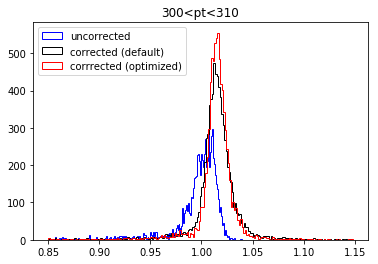

1


<Figure size 432x288 with 0 Axes>

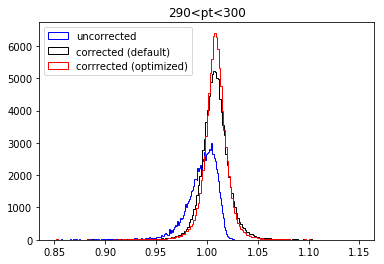

2


<Figure size 432x288 with 0 Axes>

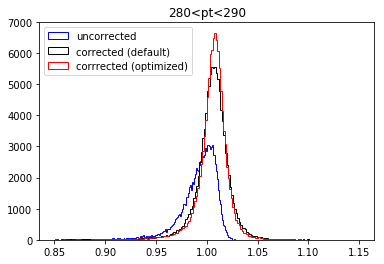

3


<Figure size 432x288 with 0 Axes>

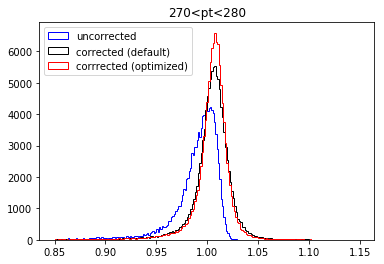

4


<Figure size 432x288 with 0 Axes>

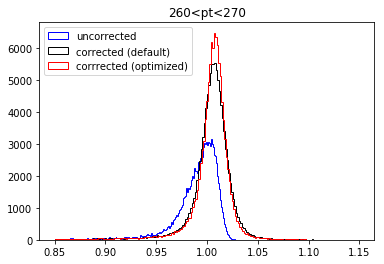

5


<Figure size 432x288 with 0 Axes>

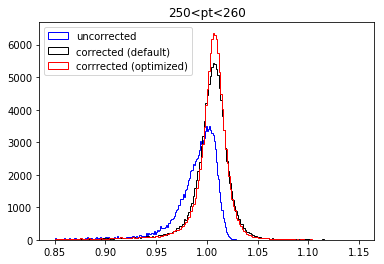

6


<Figure size 432x288 with 0 Axes>

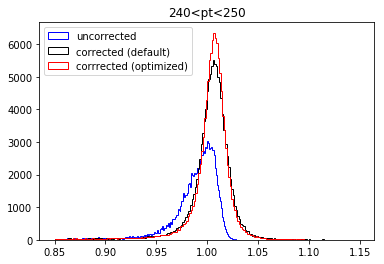

7


<Figure size 432x288 with 0 Axes>

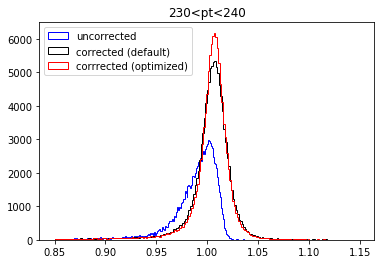

8


<Figure size 432x288 with 0 Axes>

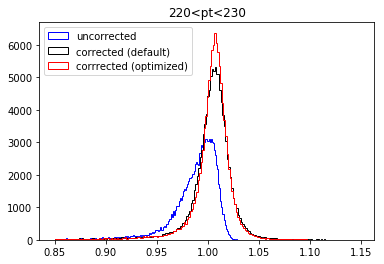

9


<Figure size 432x288 with 0 Axes>

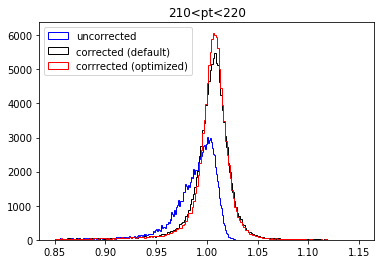

10


<Figure size 432x288 with 0 Axes>

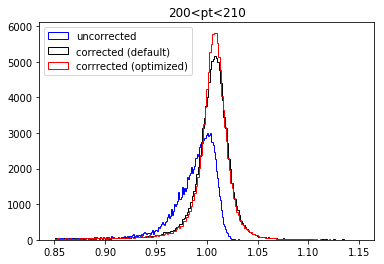

11


<Figure size 432x288 with 0 Axes>

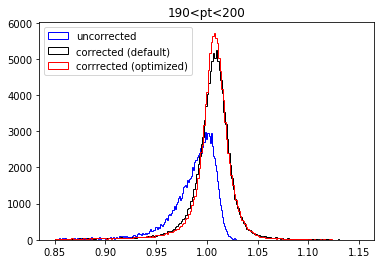

12


<Figure size 432x288 with 0 Axes>

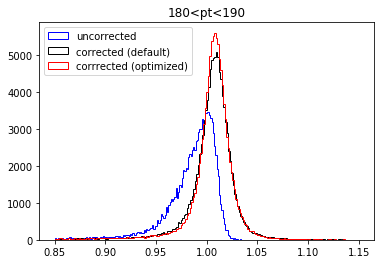

13


<Figure size 432x288 with 0 Axes>

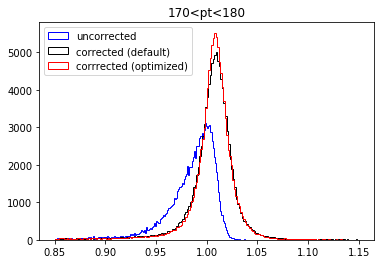

14


<Figure size 432x288 with 0 Axes>

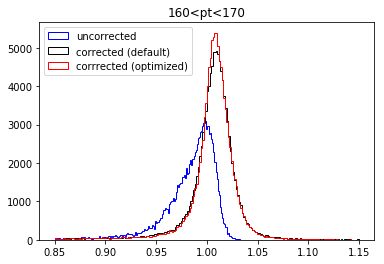

15


<Figure size 432x288 with 0 Axes>

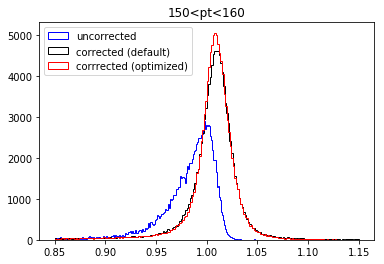

16


<Figure size 432x288 with 0 Axes>

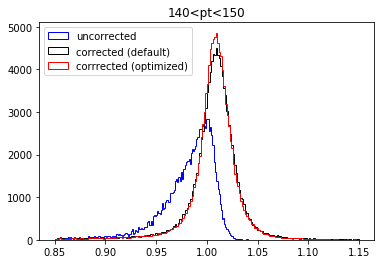

17


<Figure size 432x288 with 0 Axes>

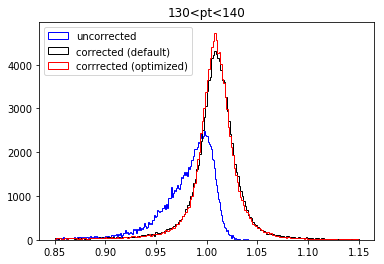

18


<Figure size 432x288 with 0 Axes>

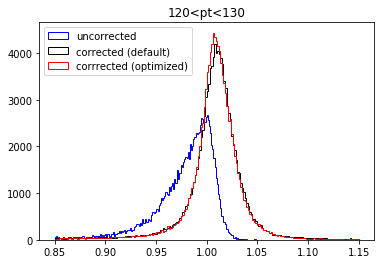

19


<Figure size 432x288 with 0 Axes>

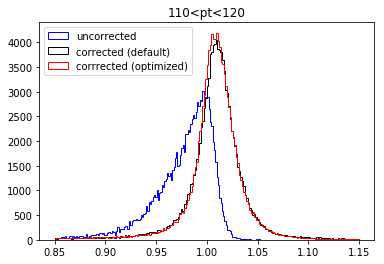

20


<Figure size 432x288 with 0 Axes>

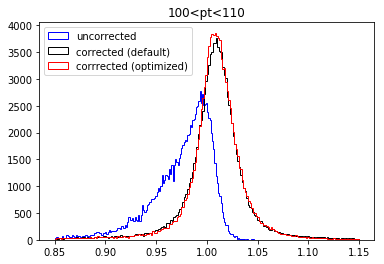

21


<Figure size 432x288 with 0 Axes>

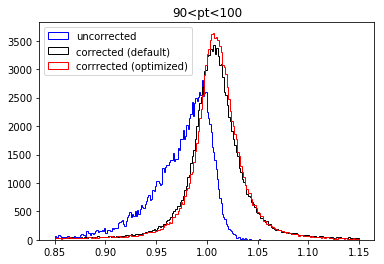

22


<Figure size 432x288 with 0 Axes>

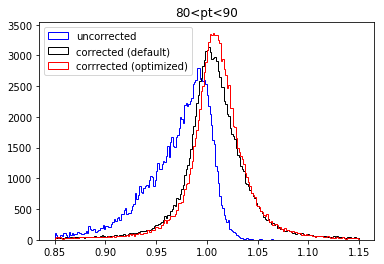

23


<Figure size 432x288 with 0 Axes>

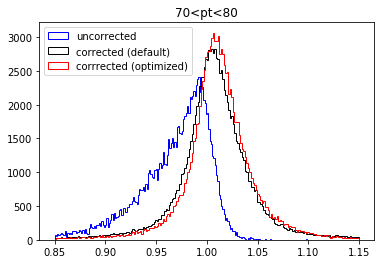

24


<Figure size 432x288 with 0 Axes>

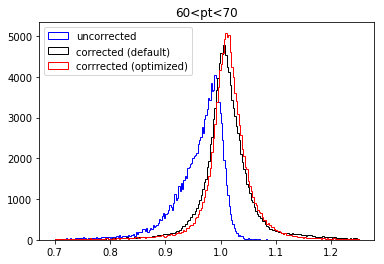

25


<Figure size 432x288 with 0 Axes>

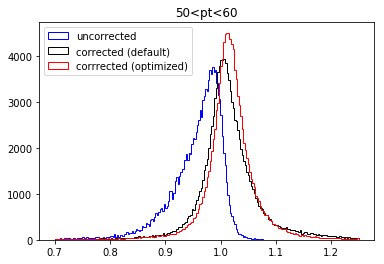

26


<Figure size 432x288 with 0 Axes>

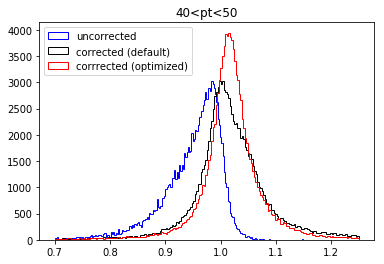

27


<Figure size 432x288 with 0 Axes>

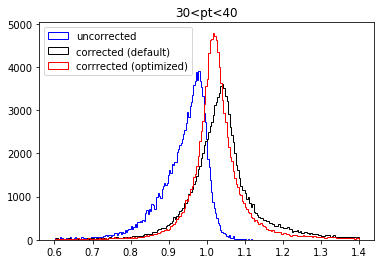

28


<Figure size 432x288 with 0 Axes>

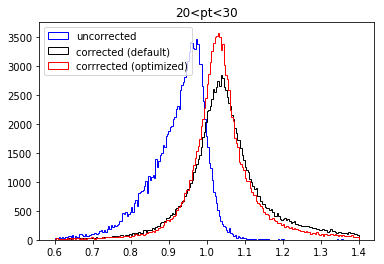

In [11]:
n=29
pt=np.zeros((n))
mean_pt=np.zeros((n))
err_mean_pt=np.zeros((n))
sigma_pt=np.zeros((n))
err_sigma_pt=np.zeros((n))

feat_pt=[]
for i in range (n):
    a=300-10*i
    b=a+10
    pt[i]= (a+b)/2
    feat_pt.append(str(a)+'<pt<'+str(b))
i=0

for para in feat_pt:
    plt.figure()
    df=DF.query(para).astype('double')
    if i<=23:
        rmin = 0.85
        rmax = 1.15
    elif 23<i<27:
        rmin=0.7
        rmax=1.25
    else:
        rmin=0.6
        rmax=1.4
    plt.figure()
    df=data.query(para).astype('double')
    dft=df.query(str(rmin)+'<target<'+str(rmax)).astype('double')
    dfd=df.query(str(rmin)+'<z_default<'+str(rmax)).astype('double')
    dfo=df.query(str(rmin)+'<z_bo<'+str(rmax)).astype('double')
    nbins = 200
    plt.hist(dft['target'],bins=nbins,histtype='step',color='blue',label='uncorrected',density=0)
    plt.hist(dfd['z_default'],bins=nbins,histtype='step',color='black',label='corrected (default)',density=0)
    plt.hist(dfo['z_bo'],bins=nbins,histtype='step',color='red',label='corrrected (optimized)',density=0)
    plt.title(para)
    plt.legend(loc=2)
    plt.savefig(os.path.join(out_dir+'plot','split_in_pt_'+para+'.png'))
    print(i)
    plt.show()
    i+=1

In [12]:
Tipe=['target','z_default','z_bo']
n=29

mean_pt_un=np.zeros((n))
mean_pt_de=np.zeros((n))
mean_pt_bo=np.zeros((n))

mean_err_pt_un=np.zeros((n))
mean_err_pt_de=np.zeros((n))
mean_err_pt_bo=np.zeros((n))

sigma_pt_un=np.zeros((n))
sigma_pt_de=np.zeros((n))
sigma_pt_bo=np.zeros((n))

Eff_sigma_pt_un=np.zeros((n))
Eff_sigma_pt_de=np.zeros((n))
Eff_sigma_pt_bo=np.zeros((n))

rms_pt_un=np.zeros((n))
rms_pt_de=np.zeros((n))
rms_pt_bo=np.zeros((n))

histsigma_pt_un=np.zeros((n))
histsigma_pt_de=np.zeros((n))
histsigma_pt_bo=np.zeros((n))

sigma_err_pt_un=np.zeros((n))
sigma_err_pt_de=np.zeros((n))
sigma_err_pt_bo=np.zeros((n))

pt=np.zeros((n))
feat_pt=[]
for i in range (n):
    a=300-10*i
    b=a+10
    pt[i]= (a+b)/2
    feat_pt.append(str(a)+'<pt<'+str(b))
nbins=500

In [20]:

nbins=500
feat_pt=[]
for i in range (n):
    a=300-10*i
    b=a+10
    pt[i]= (a+b)/2
    feat_pt.append(str(a)+'<pt<'+str(b))
Tipe=['target','z_default','z_bo']
n=29

Eff_sigma_pt_un=np.zeros((n))
Eff_sigma_pt_de=np.zeros((n))
Eff_sigma_pt_bo=np.zeros((n))

rms_pt_un=np.zeros((n))
rms_pt_de=np.zeros((n))
rms_pt_bo=np.zeros((n))

histsigma_pt_un=np.zeros((n))
histsigma_pt_de=np.zeros((n))
histsigma_pt_bo=np.zeros((n))

sigma_err_pt_un=np.zeros((n))
sigma_err_pt_de=np.zeros((n))
sigma_err_pt_bo=np.zeros((n))

quantile_pt_un=np.zeros((3,n))
quantile_pt_de=np.zeros((3,n))
quantile_pt_bo=np.zeros((3,n))
i=0
for tipe in Tipe:
    for para in feat_pt:
        df=data.query(para).astype('double')
        df=df[tipe]
        
        hist,bin_edge=np.histogram(df,bins=nbins)
        
        a=RMS(hist,bin_edge)
        b=evaleffrms(hist,bin_edge)
        c=histsigma(hist,bin_edge)
        if tipe=='target':
            
            for j in range(3):
                quantile_pt_un[j,i]=np.array(df.quantile([.25,.5,.75]))[j]
        elif tipe=='z_bo':
            for j in range(3):
                quantile_pt_bo[j,i]=np.array(df.quantile([.25,.5,.75]))[j]
        elif tipe=='z_default':
            for j in range(3):
                quantile_pt_de[j,i]=np.array(df.quantile([.25,.5,.75]))[j]
        if tipe=='target':
            rms_pt_un[i]=a
            Eff_sigma_pt_un[i]=b
            histsigma_pt_un[i]=c
        if tipe=='z_default': 
            rms_pt_de[i]=a
            Eff_sigma_pt_de[i]=b
            histsigma_pt_de[i]=c
        if tipe=='z_bo':
            rms_pt_bo[i]=a
            Eff_sigma_pt_bo[i]=b
            histsigma_pt_bo[i]=c
        i+=1
        if i==29:
            i=0

0.9924068272286598
0.9931810960902524
0.989661435375413
0.9878386267479908
0.9863971467867776
0.9845422975377088
0.9839143840330423
0.9827503796325584
0.9814563523099271
0.9806273886844534
0.9795456209064326
0.9780643457482906
0.9767237860932032
0.9761858027819245
0.9744857465146421
0.9733629887882
0.9724070347940109
0.9698710993042167
0.9678459464002358
0.9658678779787807
0.9642723620004515
0.9624505263646359
0.9603472322212204
0.9572777937428204
0.9525994982163498
0.9467938643669712
0.9365424465161483
0.925942755612747
0.9096139702999869
1.0129829932332124
1.0075176021196657
1.0047753597612015
1.0035843740813515
1.002574431618552
1.0015155034752456
1.0015098244803409
1.0006370757450096
1.0002745674692186
1.0002536852214778
1.0003537089608712
0.9998563941195054
1.00005391536901
1.000488808691017
1.0007644240786921
1.0012350950738498
1.0024259122451764
1.002484338462145
1.002563246709636
1.002504248036465
1.0029456689469052
1.0033250311785913
1.004052352313716
1.0052526443064813
1.0099

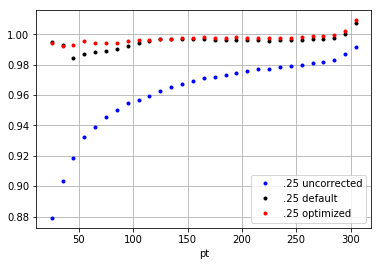

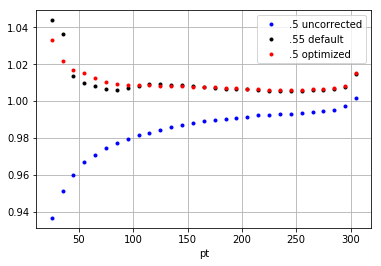

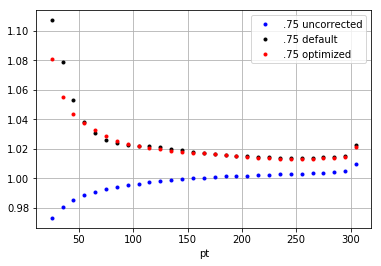

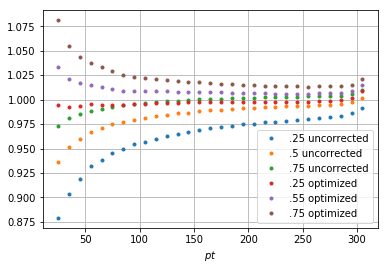

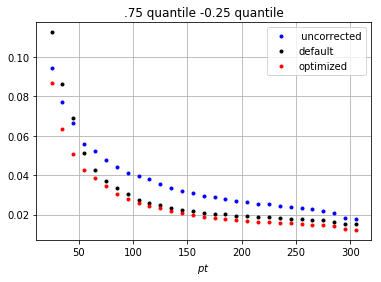

In [14]:
plt.figure()
plt.plot(pt, quantile_pt_un[0,:],'b.',label='.25 uncorrected')
plt.plot(pt, quantile_pt_de[0,:],'k.',label='.25 default')
plt.plot(pt, quantile_pt_bo[0,:],'r.',label='.25 optimized')
plt.legend()
plt.grid()
plt.xlabel('pt')
plt.savefig(os.path.join(out_dir+'plot','quantile_25_against_pt'+'.png'))
plt.show()

plt.figure()
plt.plot(pt, quantile_pt_un[1,:],'b.',label='.5 uncorrected')
plt.plot(pt, quantile_pt_de[1,:],'k.',label='.55 default')
plt.plot(pt, quantile_pt_bo[1,:],'r.',label='.5 optimized')
plt.legend()
plt.grid()
plt.xlabel('pt')
plt.savefig(os.path.join(out_dir+'plot','quantile_5_against_pt'+'.png'))
plt.show()

plt.figure()
plt.plot(pt, quantile_pt_un[2,:],'b.',label='.75 uncorrected')
plt.plot(pt, quantile_pt_de[2,:],'k.',label='.75 default')
plt.plot(pt, quantile_pt_bo[2,:],'r.',label='.75 optimized')
plt.legend()
plt.grid()
plt.xlabel('pt')
plt.savefig(os.path.join(out_dir+'plot','quantile_75_against_pt'+'.png'))
plt.show()

plt.figure()
plt.plot(pt, quantile_pt_un[0,:],'.',label='.25 uncorrected')
plt.plot(pt, quantile_pt_un[1,:],'.',label='.5 uncorrected')
plt.plot(pt, quantile_pt_un[2,:],'.',label='.75 uncorrected')
plt.plot(pt, quantile_pt_bo[0,:],'.',label='.25 optimized')
plt.plot(pt, quantile_pt_bo[1,:],'.',label='.55 optimized')
plt.plot(pt, quantile_pt_bo[2,:],'.',label='.75 optimized')
plt.legend()
plt.grid()
plt.xlabel('$pt$')
plt.savefig(os.path.join(out_dir+'plot','quantile_against_pt'+'.png'))
plt.show()

plt.figure()
plt.plot(pt, quantile_pt_un[2,:]-quantile_pt_un[0,:],'b.',label=' uncorrected')
plt.plot(pt, quantile_pt_de[2,:]-quantile_pt_de[0,:],'k.',label='default')
plt.plot(pt, quantile_pt_bo[2,:]-quantile_pt_bo[0,:],'r.',label='optimized')
plt.legend()
plt.grid()
plt.title('.75 quantile -0.25 quantile')
plt.xlabel('$pt$')
plt.savefig(os.path.join(out_dir+'plot','diffquantile_against_pt'+'.png'))
plt.show()

In [15]:
# the fit of the uncorrected can been found in PT_Uncorreceted.ipynb where they are done indivually and then 
#loaded into a csv file
tipe='target'
i=0
for para in feat_pt:
    if 21<i<26:
        rmin=0.78
        rmax=1.07
    elif i>25:
        rmin=0.6
        rmax=1.2
    elif 15<i<23:
        rmin=0.79
        rmax=1.11
    else:
        rmin=0.9
        rmax=1.07
    
    df=data.query(para).astype('double')
    df=df[tipe]
    bound_DCB=[rmin, rmax]
    
    plt.figure()
    hist,bin_edge=np.histogram(df,bins=nbins)
    plt.show()
    
    hist_mean=np.mean(hist)
    a=RMS(hist,bin_edge)
    b=evaleffrms(hist,bin_edge)
    c=histsigma(hist,bin_edge)
    print(para)
    rms_pt_un[i]=a
    Eff_sigma_pt_un[i]=b
    histsigma_pt_un[i]=c
    i+=1

<Figure size 432x288 with 0 Axes>

0.9924068272286598
300<pt<310


<Figure size 432x288 with 0 Axes>

0.9931810960902524
290<pt<300


<Figure size 432x288 with 0 Axes>

0.989661435375413
280<pt<290


<Figure size 432x288 with 0 Axes>

0.9878386267479908
270<pt<280


<Figure size 432x288 with 0 Axes>

0.9863971467867776
260<pt<270


<Figure size 432x288 with 0 Axes>

0.9845422975377088
250<pt<260


<Figure size 432x288 with 0 Axes>

0.9839143840330423
240<pt<250


<Figure size 432x288 with 0 Axes>

0.9827503796325584
230<pt<240


<Figure size 432x288 with 0 Axes>

0.9814563523099271
220<pt<230


<Figure size 432x288 with 0 Axes>

0.9806273886844534
210<pt<220


<Figure size 432x288 with 0 Axes>

0.9795456209064326
200<pt<210


<Figure size 432x288 with 0 Axes>

0.9780643457482906
190<pt<200


<Figure size 432x288 with 0 Axes>

0.9767237860932032
180<pt<190


<Figure size 432x288 with 0 Axes>

0.9761858027819245
170<pt<180


<Figure size 432x288 with 0 Axes>

0.9744857465146421
160<pt<170


<Figure size 432x288 with 0 Axes>

0.9733629887882
150<pt<160


<Figure size 432x288 with 0 Axes>

0.9724070347940109
140<pt<150


<Figure size 432x288 with 0 Axes>

0.9698710993042167
130<pt<140


<Figure size 432x288 with 0 Axes>

0.9678459464002358
120<pt<130


<Figure size 432x288 with 0 Axes>

0.9658678779787807
110<pt<120


<Figure size 432x288 with 0 Axes>

0.9642723620004515
100<pt<110


<Figure size 432x288 with 0 Axes>

0.9624505263646359
90<pt<100


<Figure size 432x288 with 0 Axes>

0.9603472322212204
80<pt<90


<Figure size 432x288 with 0 Axes>

0.9572777937428204
70<pt<80


<Figure size 432x288 with 0 Axes>

0.9525994982163498
60<pt<70


<Figure size 432x288 with 0 Axes>

0.9467938643669712
50<pt<60


<Figure size 432x288 with 0 Axes>

0.9365424465161483
40<pt<50


<Figure size 432x288 with 0 Axes>

0.925942755612747
30<pt<40


<Figure size 432x288 with 0 Axes>

0.9096139702999869
20<pt<30


<Figure size 432x288 with 0 Axes>

1.0129829932332124


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (2.104493204573985, 3.321187091686076, -9.816202038138977, 9.189769005250668, 1.017302750296516, 0.015)


FCN = 764.484535039 
 TOTAL NCALL = 552 
 NCALLS = 541 
 
 
 EDM = 96649479829.6 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.1154 
 0.033089 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.42165 
 0.163442 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00138 
 1.48251e-05 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.363047 
 0.379751 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01541 
 0.000184908 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.1154 & 0.033089 & & & & & No\\
\hline
1 & alpha2 & 2.42165 & 0.163442 & & & & & No\\
\hline
2 & n & 1.00138 & 1.48251e-05 & & & & & No\\
\hline
3 & n2 & 0.363047 & 0.379751 & & & & & No\\
\hline
4 & mean & 1.01541 & 0.000184908 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 364.553364182 
 TOTAL NCALL = 32 
 NCALLS = 32 
 
 
 EDM = 1.65904201874e-11 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.1154 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.42165 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00138 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 0.363047 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.01541 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0105408 
 0.000126484 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.1154 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.42165 & 1 & & & & & Yes\\
\hline
2 & n & 1.00138 & 1 & & & & & Yes\\
\hline
3 & n2 & 0.363047 & 1 & & & & & Yes\\
\hline
4 & mean & 1.01541 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0105408 & 0.000126484 & & & & & No\\
\hline
\end{tabular}

FCN = 259.92743894 
 TOTAL NCALL = 401 
 NCALLS = 401 
 
 
 EDM = 3.87622116986e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.83117 
 0.0686651 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.03434 
 0.0776168 
 
 
 
 
 No 
 
 
 2 
 n 
 1.17662 
 0.139578 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.2384 
 2.31269 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01424 
 0.000189302 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.00886181 
 0.00020153 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.83117 & 0.0686651 & & & & & No\\
\hline
1 & alpha2 & 1.03434 & 0.0776168 & & & & & No\\
\hline
2 & n & 1.17662 & 0.139578 & & & & & No\\
\hline
3 & n2 & 7.2384 & 2.31269 & & & & & No\\
\hline
4 & mean & 1.01424 & 0.000189302 & & & & & No\\
\hline
5 & $\sigma$ & 0.00886181 & 0.00020153 & & & & & No\\
\hline
\end{tabular}

300<pt<310
0


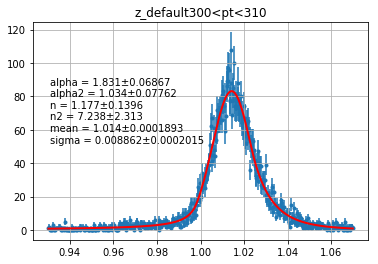

<Figure size 432x288 with 0 Axes>

1.0075176021196657


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (2.17904722458179, 2.472293217241585, -14.670976720712005, 6.84495427724137, 1.0076361467577342, 0.015)


FCN = 4418.28154049 
 TOTAL NCALL = 420 
 NCALLS = 409 
 
 
 EDM = 9.4632375414e+12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.64113 
 0.017569 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.28333 
 0.0746571 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00134 
 1.02401e-05 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.64014 
 1.18323 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00788 
 5.04562e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.64113 & 0.017569 & & & & & No\\
\hline
1 & alpha2 & 2.28333 & 0.0746571 & & & & & No\\
\hline
2 & n & 1.00134 & 1.02401e-05 & & & & & No\\
\hline
3 & n2 & 3.64014 & 1.18323 & & & & & No\\
\hline
4 & mean & 1.00788 & 5.04562e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1386.10799183 
 TOTAL NCALL = 25 
 NCALLS = 25 
 
 
 EDM = 8.37723178012e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.64113 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.28333 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00134 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.64014 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00788 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0119822 
 3.33547e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.64113 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.28333 & 1 & & & & & Yes\\
\hline
2 & n & 1.00134 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.64014 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00788 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0119822 & 3.33547e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 304.892724631 
 TOTAL NCALL = 549 
 NCALLS = 549 
 
 
 EDM = 1.64814407596e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.58026 
 0.0312598 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.2515 
 0.0266519 
 
 
 
 
 No 
 
 
 2 
 n 
 4.16166 
 0.270054 
 
 
 
 
 No 
 
 
 3 
 n2 
 13.2434 
 2.11836 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00749 
 4.92294e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0102393 
 6.62074e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.58026 & 0.0312598 & & & & & No\\
\hline
1 & alpha2 & 1.2515 & 0.0266519 & & & & & No\\
\hline
2 & n & 4.16166 & 0.270054 & & & & & No\\
\hline
3 & n2 & 13.2434 & 2.11836 & & & & & No\\
\hline
4 & mean & 1.00749 & 4.92294e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0102393 & 6.62074e-05 & & & & & No\\
\hline
\end{tabular}

290<pt<300
1


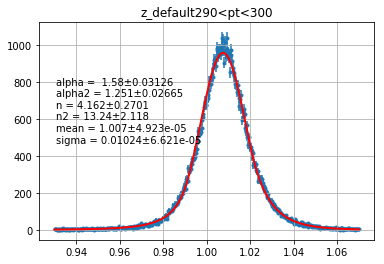

<Figure size 432x288 with 0 Axes>

1.0047753597612015


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.5933179144602083, 2.166976881403114, -0.840005264011296, 7.931070606458718, 1.0065171802634294, 0.015)


FCN = 3344.25288694 
 TOTAL NCALL = 449 
 NCALLS = 449 
 
 
 EDM = 2.32289630599e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.05964 
 0.0267194 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.4364 
 0.0473516 
 
 
 
 
 No 
 
 
 2 
 n 
 1.52947 
 0.113363 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.68129 
 0.292156 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00634 
 4.88877e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.05964 & 0.0267194 & & & & & No\\
\hline
1 & alpha2 & 2.4364 & 0.0473516 & & & & & No\\
\hline
2 & n & 1.52947 & 0.113363 & & & & & No\\
\hline
3 & n2 & 1.68129 & 0.292156 & & & & & No\\
\hline
4 & mean & 1.00634 & 4.88877e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1283.22604728 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 9.7961755528e-10 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.05964 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.4364 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.52947 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.68129 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00634 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0124592 
 3.53953e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.05964 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.4364 & 1 & & & & & Yes\\
\hline
2 & n & 1.52947 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.68129 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00634 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0124592 & 3.53953e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 275.06180589 
 TOTAL NCALL = 402 
 NCALLS = 402 
 
 
 EDM = 3.55658090266e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.24857 
 0.0220073 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.34187 
 0.0288052 
 
 
 
 
 No 
 
 
 2 
 n 
 4.34148 
 0.230131 
 
 
 
 
 No 
 
 
 3 
 n2 
 9.39594 
 1.15452 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0068 
 4.99968e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0104915 
 7.24256e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.24857 & 0.0220073 & & & & & No\\
\hline
1 & alpha2 & 1.34187 & 0.0288052 & & & & & No\\
\hline
2 & n & 4.34148 & 0.230131 & & & & & No\\
\hline
3 & n2 & 9.39594 & 1.15452 & & & & & No\\
\hline
4 & mean & 1.0068 & 4.99968e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0104915 & 7.24256e-05 & & & & & No\\
\hline
\end{tabular}

280<pt<290
2


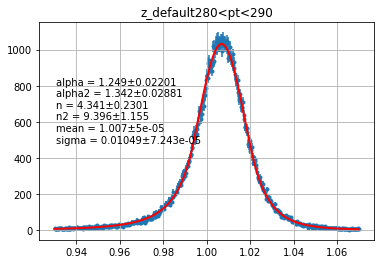

<Figure size 432x288 with 0 Axes>

1.0035843740813515


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.4118391266405712, 2.295863266776174, -0.202566240480909, 8.48608906213853, 1.0067529611840271, 0.015)


FCN = 2956.63880143 
 TOTAL NCALL = 473 
 NCALLS = 473 
 
 
 EDM = 1.04003373188e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.9197 
 0.0238348 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.39973 
 0.0465088 
 
 
 
 
 No 
 
 
 2 
 n 
 1.44667 
 0.0934192 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.52241 
 0.254373 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00628 
 4.96419e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.9197 & 0.0238348 & & & & & No\\
\hline
1 & alpha2 & 2.39973 & 0.0465088 & & & & & No\\
\hline
2 & n & 1.44667 & 0.0934192 & & & & & No\\
\hline
3 & n2 & 1.52241 & 0.254373 & & & & & No\\
\hline
4 & mean & 1.00628 & 4.96419e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1113.95237831 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 3.30487047212e-10 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.9197 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.39973 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.44667 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.52241 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00628 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0125092 
 3.67795e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.9197 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.39973 & 1 & & & & & Yes\\
\hline
2 & n & 1.44667 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.52241 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00628 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0125092 & 3.67795e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 279.064102903 
 TOTAL NCALL = 344 
 NCALLS = 344 
 
 
 EDM = 2.78847005257e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.30588 
 0.0222946 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.43316 
 0.0319303 
 
 
 
 
 No 
 
 
 2 
 n 
 3.03994 
 0.141526 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.74933 
 0.721758 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00679 
 5.03321e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0108667 
 7.07842e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.30588 & 0.0222946 & & & & & No\\
\hline
1 & alpha2 & 1.43316 & 0.0319303 & & & & & No\\
\hline
2 & n & 3.03994 & 0.141526 & & & & & No\\
\hline
3 & n2 & 6.74933 & 0.721758 & & & & & No\\
\hline
4 & mean & 1.00679 & 5.03321e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0108667 & 7.07842e-05 & & & & & No\\
\hline
\end{tabular}

270<pt<280
3


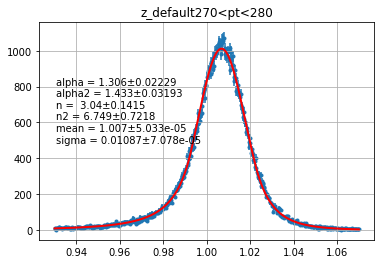

<Figure size 432x288 with 0 Axes>

1.002574431618552


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.4357293942344311, 2.269738442067474, 0.22431085256810945, 8.377870218684976, 1.0064319989939727, 0.015)


FCN = 3018.6344464 
 TOTAL NCALL = 400 
 NCALLS = 389 
 
 
 EDM = 88.4820764042 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.04924 
 0.025266 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.27294 
 0.105237 
 
 
 
 
 No 
 
 
 2 
 n 
 1.11293 
 0.0800595 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.54644 
 1.08987 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00615 
 4.91762e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.04924 & 0.025266 & & & & & No\\
\hline
1 & alpha2 & 2.27294 & 0.105237 & & & & & No\\
\hline
2 & n & 1.11293 & 0.0800595 & & & & & No\\
\hline
3 & n2 & 2.54644 & 1.08987 & & & & & No\\
\hline
4 & mean & 1.00615 & 4.91762e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1048.39373727 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.28949684585e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.04924 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.27294 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.11293 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.54644 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00615 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0124734 
 3.59465e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.04924 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.27294 & 1 & & & & & Yes\\
\hline
2 & n & 1.11293 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.54644 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00615 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0124734 & 3.59465e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 288.623968679 
 TOTAL NCALL = 347 
 NCALLS = 347 
 
 
 EDM = 3.25838352954e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.39448 
 0.0231108 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.46719 
 0.0307505 
 
 
 
 
 No 
 
 
 2 
 n 
 2.73043 
 0.125565 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.24515 
 0.615852 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00656 
 4.88424e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109456 
 6.56737e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.39448 & 0.0231108 & & & & & No\\
\hline
1 & alpha2 & 1.46719 & 0.0307505 & & & & & No\\
\hline
2 & n & 2.73043 & 0.125565 & & & & & No\\
\hline
3 & n2 & 6.24515 & 0.615852 & & & & & No\\
\hline
4 & mean & 1.00656 & 4.88424e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109456 & 6.56737e-05 & & & & & No\\
\hline
\end{tabular}

260<pt<270
4


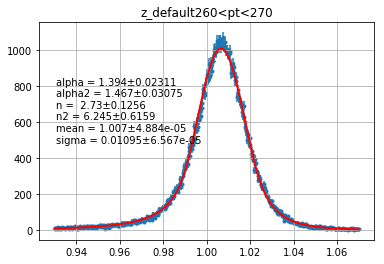

<Figure size 432x288 with 0 Axes>

1.0015155034752456


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (-437.3394010653734, 78.45378773084308, -107.39345332732046, 2.2778629117022615, -59327.29787552662, 0.015)


FCN = 2754.64433373 
 TOTAL NCALL = 338 
 NCALLS = 327 
 
 
 EDM = 1523.27318719 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.99735 
 0.0215666 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.11733 
 0.288212 
 
 
 
 
 No 
 
 
 2 
 n 
 1.15703 
 0.0709896 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.60449 
 6.58466 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0061 
 4.8986e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.99735 & 0.0215666 & & & & & No\\
\hline
1 & alpha2 & 2.11733 & 0.288212 & & & & & No\\
\hline
2 & n & 1.15703 & 0.0709896 & & & & & No\\
\hline
3 & n2 & 4.60449 & 6.58466 & & & & & No\\
\hline
4 & mean & 1.0061 & 4.8986e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1133.72991726 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.52050940871e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.99735 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.11733 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.15703 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 4.60449 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.0061 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0126859 
 3.65025e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.99735 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.11733 & 1 & & & & & Yes\\
\hline
2 & n & 1.15703 & 1 & & & & & Yes\\
\hline
3 & n2 & 4.60449 & 1 & & & & & Yes\\
\hline
4 & mean & 1.0061 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0126859 & 3.65025e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 276.88425433 
 TOTAL NCALL = 379 
 NCALLS = 379 
 
 
 EDM = 1.85912826783e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.31232 
 0.0228514 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.39567 
 0.0290443 
 
 
 
 
 No 
 
 
 2 
 n 
 2.90643 
 0.135163 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.74533 
 0.847024 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00655 
 5.10147e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0109036 
 7.13675e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.31232 & 0.0228514 & & & & & No\\
\hline
1 & alpha2 & 1.39567 & 0.0290443 & & & & & No\\
\hline
2 & n & 2.90643 & 0.135163 & & & & & No\\
\hline
3 & n2 & 7.74533 & 0.847024 & & & & & No\\
\hline
4 & mean & 1.00655 & 5.10147e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0109036 & 7.13675e-05 & & & & & No\\
\hline
\end{tabular}

250<pt<260
5


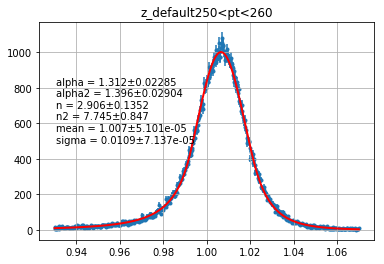

<Figure size 432x288 with 0 Axes>

1.0015098244803409


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.4023670961841308, 2.2069746731012123, 0.18121165411088747, 8.227488790459017, 1.0064328519904235, 0.015)


FCN = 2582.99515714 
 TOTAL NCALL = 415 
 NCALLS = 415 
 
 
 EDM = 5.99540566038e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.95518 
 0.025143 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.39944 
 0.0406107 
 
 
 
 
 No 
 
 
 2 
 n 
 1.34677 
 0.0914792 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.36555 
 0.204441 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00606 
 4.93256e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.95518 & 0.025143 & & & & & No\\
\hline
1 & alpha2 & 2.39944 & 0.0406107 & & & & & No\\
\hline
2 & n & 1.34677 & 0.0914792 & & & & & No\\
\hline
3 & n2 & 1.36555 & 0.204441 & & & & & No\\
\hline
4 & mean & 1.00606 & 4.93256e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1050.90806605 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.89201725448e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.95518 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.39944 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.34677 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.36555 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00606 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0127372 
 3.69609e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.95518 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.39944 & 1 & & & & & Yes\\
\hline
2 & n & 1.34677 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.36555 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00606 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0127372 & 3.69609e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 342.550567935 
 TOTAL NCALL = 327 
 NCALLS = 327 
 
 
 EDM = 2.21147647996e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.28558 
 0.0224899 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.50034 
 0.0335307 
 
 
 
 
 No 
 
 
 2 
 n 
 3.37036 
 0.167239 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.74578 
 0.5827 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00666 
 5.14728e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0111589 
 7.14751e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.28558 & 0.0224899 & & & & & No\\
\hline
1 & alpha2 & 1.50034 & 0.0335307 & & & & & No\\
\hline
2 & n & 3.37036 & 0.167239 & & & & & No\\
\hline
3 & n2 & 5.74578 & 0.5827 & & & & & No\\
\hline
4 & mean & 1.00666 & 5.14728e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0111589 & 7.14751e-05 & & & & & No\\
\hline
\end{tabular}

240<pt<250
6


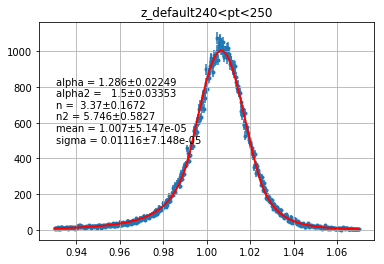

<Figure size 432x288 with 0 Axes>

1.0006370757450096


FCN = 2595.92472617 
 TOTAL NCALL = 328 
 NCALLS = 317 
 
 
 EDM = 3002.48400745 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.90533 
 0.0127912 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.13896 
 0.286867 
 
 
 
 
 No 
 
 
 2 
 n 
 1.48115 
 0.0525733 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.67291 
 8.17 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00605 
 5.09841e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.90533 & 0.0127912 & & & & & No\\
\hline
1 & alpha2 & 2.13896 & 0.286867 & & & & & No\\
\hline
2 & n & 1.48115 & 0.0525733 & & & & & No\\
\hline
3 & n2 & 4.67291 & 8.17 & & & & & No\\
\hline
4 & mean & 1.00605 & 5.09841e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.9053308809536456, 2.1389636286968816, 1.4811502677650523, 4.6729071738536945, 1.0060481498160074, -0.02018624220240725)


FCN = 1132.90275829 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.17428585542e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.90533 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.13896 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.48115 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 4.67291 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00605 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0128033 
 3.66978e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.90533 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.13896 & 1 & & & & & Yes\\
\hline
2 & n & 1.48115 & 1 & & & & & Yes\\
\hline
3 & n2 & 4.67291 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00605 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0128033 & 3.66978e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 272.226212403 
 TOTAL NCALL = 351 
 NCALLS = 351 
 
 
 EDM = 3.05228367917e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.2833 
 0.0217885 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.43257 
 0.0291329 
 
 
 
 
 No 
 
 
 2 
 n 
 3.12136 
 0.146363 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.91247 
 0.707608 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00655 
 5.13625e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0110092 
 6.92272e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.2833 & 0.0217885 & & & & & No\\
\hline
1 & alpha2 & 1.43257 & 0.0291329 & & & & & No\\
\hline
2 & n & 3.12136 & 0.146363 & & & & & No\\
\hline
3 & n2 & 6.91247 & 0.707608 & & & & & No\\
\hline
4 & mean & 1.00655 & 5.13625e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0110092 & 6.92272e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 272.226196765 
 TOTAL NCALL = 56 
 NCALLS = 56 
 
 
 EDM = 1.25274826233e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.2833 
 0.0155062 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.43259 
 0.0213669 
 
 
 
 
 No 
 
 
 2 
 n 
 3.12135 
 0.128719 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.91327 
 0.646541 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00655 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0110092 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.2833 & 0.0155062 & & & & & No\\
\hline
1 & alpha2 & 1.43259 & 0.0213669 & & & & & No\\
\hline
2 & n & 3.12135 & 0.128719 & & & & & No\\
\hline
3 & n2 & 6.91327 & 0.646541 & & & & & No\\
\hline
4 & mean & 1.00655 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0110092 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 272.226195972 
 TOTAL NCALL = 98 
 NCALLS = 98 
 
 
 EDM = 1.40992382894e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.2833 
 0.0217825 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.43259 
 0.0291561 
 
 
 
 
 No 
 
 
 2 
 n 
 3.12135 
 0.146326 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.91328 
 0.708506 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00655 
 5.13619e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0110092 
 6.9217e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.2833 & 0.0217825 & & & & & No\\
\hline
1 & alpha2 & 1.43259 & 0.0291561 & & & & & No\\
\hline
2 & n & 3.12135 & 0.146326 & & & & & No\\
\hline
3 & n2 & 6.91328 & 0.708506 & & & & & No\\
\hline
4 & mean & 1.00655 & 5.13619e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0110092 & 6.9217e-05 & & & & & No\\
\hline
\end{tabular}

230<pt<240
7


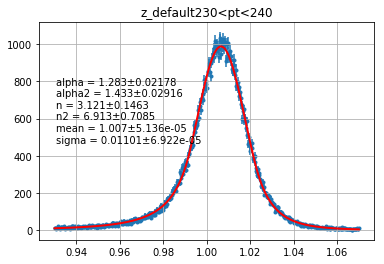

<Figure size 432x288 with 0 Axes>

1.0002745674692186


FCN = 2223.58885045 
 TOTAL NCALL = 458 
 NCALLS = 458 
 
 
 EDM = 3.22887463972e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.91091 
 0.0235423 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.41312 
 0.0422795 
 
 
 
 
 No 
 
 
 2 
 n 
 1.28651 
 0.0816772 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.14778 
 0.181097 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00606 
 4.97603e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.91091 & 0.0235423 & & & & & No\\
\hline
1 & alpha2 & 2.41312 & 0.0422795 & & & & & No\\
\hline
2 & n & 1.28651 & 0.0816772 & & & & & No\\
\hline
3 & n2 & 1.14778 & 0.181097 & & & & & No\\
\hline
4 & mean & 1.00606 & 4.97603e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.910910776609998, 2.4131204122326753, 1.286507416864851, 1.147779861559597, 1.006055341503461, -0.01756575011597286)


FCN = 940.598212877 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.19156374999e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.91091 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.41312 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.28651 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.14778 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00606 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0128857 
 3.81663e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.91091 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.41312 & 1 & & & & & Yes\\
\hline
2 & n & 1.28651 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.14778 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00606 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0128857 & 3.81663e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 320.657940131 
 TOTAL NCALL = 318 
 NCALLS = 318 
 
 
 EDM = 8.19972774771e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.28579 
 0.0237189 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.50471 
 0.0309476 
 
 
 
 
 No 
 
 
 2 
 n 
 3.09158 
 0.156072 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.45081 
 0.510086 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00664 
 5.36993e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0113329 
 7.25942e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.28579 & 0.0237189 & & & & & No\\
\hline
1 & alpha2 & 1.50471 & 0.0309476 & & & & & No\\
\hline
2 & n & 3.09158 & 0.156072 & & & & & No\\
\hline
3 & n2 & 5.45081 & 0.510086 & & & & & No\\
\hline
4 & mean & 1.00664 & 5.36993e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0113329 & 7.25942e-05 & & & & & No\\
\hline
\end{tabular}

220<pt<230
8


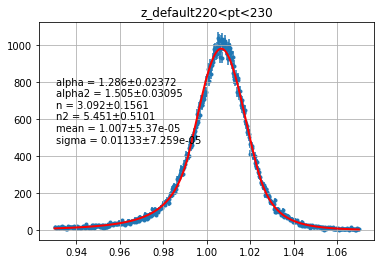

<Figure size 432x288 with 0 Axes>

1.0002536852214778


FCN = 2224.56945503 
 TOTAL NCALL = 414 
 NCALLS = 414 
 
 
 EDM = 4.94916058385e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.90446 
 0.0244044 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.33996 
 0.0451736 
 
 
 
 
 No 
 
 
 2 
 n 
 1.35499 
 0.0879236 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.44695 
 0.230147 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00651 
 5.03288e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.90446 & 0.0244044 & & & & & No\\
\hline
1 & alpha2 & 2.33996 & 0.0451736 & & & & & No\\
\hline
2 & n & 1.35499 & 0.0879236 & & & & & No\\
\hline
3 & n2 & 1.44695 & 0.230147 & & & & & No\\
\hline
4 & mean & 1.00651 & 5.03288e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.9044573092961794, 2.3399580941982046, 1.354993714637755, 1.4469464568736599, 1.0065108375885798, -0.01757292847231278)


FCN = 952.473751092 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 6.2915533039e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.90446 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.33996 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.35499 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.44695 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00651 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0128899 
 3.82541e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.90446 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.33996 & 1 & & & & & Yes\\
\hline
2 & n & 1.35499 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.44695 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00651 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0128899 & 3.82541e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 308.56261383 
 TOTAL NCALL = 313 
 NCALLS = 313 
 
 
 EDM = 7.57038704652e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.29107 
 0.0223027 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.47616 
 0.0326822 
 
 
 
 
 No 
 
 
 2 
 n 
 3.10894 
 0.149857 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.89637 
 0.609712 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00707 
 5.24273e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0113273 
 7.2329e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.29107 & 0.0223027 & & & & & No\\
\hline
1 & alpha2 & 1.47616 & 0.0326822 & & & & & No\\
\hline
2 & n & 3.10894 & 0.149857 & & & & & No\\
\hline
3 & n2 & 5.89637 & 0.609712 & & & & & No\\
\hline
4 & mean & 1.00707 & 5.24273e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0113273 & 7.2329e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 308.562609035 
 TOTAL NCALL = 58 
 NCALLS = 58 
 
 
 EDM = 1.21276906694e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.29106 
 0.0157284 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.47617 
 0.0231794 
 
 
 
 
 No 
 
 
 2 
 n 
 3.10885 
 0.130978 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.8963 
 0.537884 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00707 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0113273 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.29106 & 0.0157284 & & & & & No\\
\hline
1 & alpha2 & 1.47617 & 0.0231794 & & & & & No\\
\hline
2 & n & 3.10885 & 0.130978 & & & & & No\\
\hline
3 & n2 & 5.8963 & 0.537884 & & & & & No\\
\hline
4 & mean & 1.00707 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0113273 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 308.562609035 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = 6.6195716819e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.29106 
 0.021911 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.47617 
 0.0322114 
 
 
 
 
 No 
 
 
 2 
 n 
 3.10885 
 0.149083 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.8963 
 0.608361 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00707 
 5.22757e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0113273 
 6.95801e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.29106 & 0.021911 & & & & & No\\
\hline
1 & alpha2 & 1.47617 & 0.0322114 & & & & & No\\
\hline
2 & n & 3.10885 & 0.149083 & & & & & No\\
\hline
3 & n2 & 5.8963 & 0.608361 & & & & & No\\
\hline
4 & mean & 1.00707 & 5.22757e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0113273 & 6.95801e-05 & & & & & No\\
\hline
\end{tabular}

210<pt<220
9


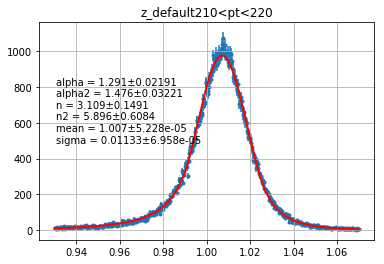

<Figure size 432x288 with 0 Axes>

1.0003537089608712


FCN = 2013.07474197 
 TOTAL NCALL = 410 
 NCALLS = 410 
 
 
 EDM = 5.63173774206e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.83888 
 0.0238242 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.34851 
 0.0418008 
 
 
 
 
 No 
 
 
 2 
 n 
 1.42756 
 0.0890773 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.22075 
 0.186991 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00682 
 5.09614e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.83888 & 0.0238242 & & & & & No\\
\hline
1 & alpha2 & 2.34851 & 0.0418008 & & & & & No\\
\hline
2 & n & 1.42756 & 0.0890773 & & & & & No\\
\hline
3 & n2 & 1.22075 & 0.186991 & & & & & No\\
\hline
4 & mean & 1.00682 & 5.09614e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.8388775542741143, 2.348507623324615, 1.42755939666464, 1.2207509325606782, 1.0068190426739378, -0.015986241194006996)


FCN = 895.986535305 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.59600868644e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.83888 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.34851 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.42756 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.22075 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00682 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0129768 
 3.92475e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.83888 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.34851 & 1 & & & & & Yes\\
\hline
2 & n & 1.42756 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.22075 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00682 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0129768 & 3.92475e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 312.776634031 
 TOTAL NCALL = 296 
 NCALLS = 296 
 
 
 EDM = 3.2927564031e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.2308 
 0.0218365 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.55199 
 0.0320642 
 
 
 
 
 No 
 
 
 2 
 n 
 3.31509 
 0.164745 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.54506 
 0.40707 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00755 
 5.4999e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0114355 
 7.17284e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.2308 & 0.0218365 & & & & & No\\
\hline
1 & alpha2 & 1.55199 & 0.0320642 & & & & & No\\
\hline
2 & n & 3.31509 & 0.164745 & & & & & No\\
\hline
3 & n2 & 4.54506 & 0.40707 & & & & & No\\
\hline
4 & mean & 1.00755 & 5.4999e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0114355 & 7.17284e-05 & & & & & No\\
\hline
\end{tabular}

200<pt<210
10


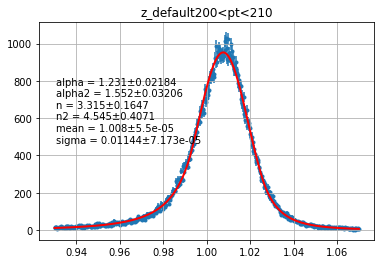

<Figure size 432x288 with 0 Axes>

0.9998563941195054


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.35755500002748, 1.9618087397904893, -0.3045179662801747, 7.248401579292549, 1.0073923394346613, 0.015)


FCN = 1806.76742252 
 TOTAL NCALL = 417 
 NCALLS = 417 
 
 
 EDM = 2.6044353631e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.76488 
 0.0227732 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.2567 
 0.0394736 
 
 
 
 
 No 
 
 
 2 
 n 
 1.7558 
 0.104313 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.17666 
 0.164627 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00708 
 5.16321e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.76488 & 0.0227732 & & & & & No\\
\hline
1 & alpha2 & 2.2567 & 0.0394736 & & & & & No\\
\hline
2 & n & 1.7558 & 0.104313 & & & & & No\\
\hline
3 & n2 & 1.17666 & 0.164627 & & & & & No\\
\hline
4 & mean & 1.00708 & 5.16321e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 898.8244428 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.96956595985e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.76488 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.2567 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.7558 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.17666 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00708 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0131443 
 4.0419e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.76488 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.2567 & 1 & & & & & Yes\\
\hline
2 & n & 1.7558 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.17666 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00708 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0131443 & 4.0419e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 303.818671248 
 TOTAL NCALL = 319 
 NCALLS = 319 
 
 
 EDM = 1.98191299265e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.14138 
 0.0217853 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.51587 
 0.0292314 
 
 
 
 
 No 
 
 
 2 
 n 
 4.18126 
 0.236014 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.92431 
 0.304732 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00788 
 5.91356e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.011401 
 7.76703e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.14138 & 0.0217853 & & & & & No\\
\hline
1 & alpha2 & 1.51587 & 0.0292314 & & & & & No\\
\hline
2 & n & 4.18126 & 0.236014 & & & & & No\\
\hline
3 & n2 & 3.92431 & 0.304732 & & & & & No\\
\hline
4 & mean & 1.00788 & 5.91356e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.011401 & 7.76703e-05 & & & & & No\\
\hline
\end{tabular}

190<pt<200
11


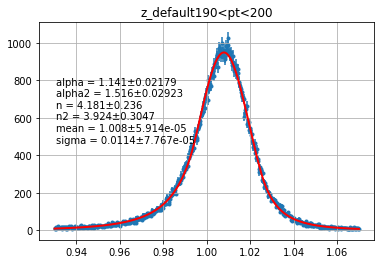

<Figure size 432x288 with 0 Axes>

1.00005391536901


FCN = 1454.51816797 
 TOTAL NCALL = 414 
 NCALLS = 414 
 
 
 EDM = 1.27827701729e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.72491 
 0.0232685 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.17442 
 0.0385155 
 
 
 
 
 No 
 
 
 2 
 n 
 1.74439 
 0.104214 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.41395 
 0.186966 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00739 
 5.27597e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.72491 & 0.0232685 & & & & & No\\
\hline
1 & alpha2 & 2.17442 & 0.0385155 & & & & & No\\
\hline
2 & n & 1.74439 & 0.104214 & & & & & No\\
\hline
3 & n2 & 1.41395 & 0.186966 & & & & & No\\
\hline
4 & mean & 1.00739 & 5.27597e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.7249082154110242, 2.1744243989277705, 1.7443915001360717, 1.4139533029157438, 1.0073855770880882, -0.0113402096734471)


FCN = 816.174632121 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.41697016028e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.72491 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.17442 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.74439 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.41395 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00739 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0134066 
 4.17828e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.72491 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.17442 & 1 & & & & & Yes\\
\hline
2 & n & 1.74439 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.41395 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00739 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0134066 & 4.17828e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 317.689420124 
 TOTAL NCALL = 318 
 NCALLS = 318 
 
 
 EDM = 4.07494027969e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.1285 
 0.0222989 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.48635 
 0.0313771 
 
 
 
 
 No 
 
 
 2 
 n 
 4.16756 
 0.24222 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.29114 
 0.376097 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00817 
 6.16785e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0116777 
 8.46741e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.1285 & 0.0222989 & & & & & No\\
\hline
1 & alpha2 & 1.48635 & 0.0313771 & & & & & No\\
\hline
2 & n & 4.16756 & 0.24222 & & & & & No\\
\hline
3 & n2 & 4.29114 & 0.376097 & & & & & No\\
\hline
4 & mean & 1.00817 & 6.16785e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0116777 & 8.46741e-05 & & & & & No\\
\hline
\end{tabular}

180<pt<190
12


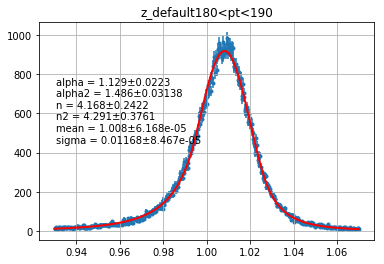

<Figure size 432x288 with 0 Axes>

1.000488808691017


FCN = 1289.06887604 
 TOTAL NCALL = 361 
 NCALLS = 361 
 
 
 EDM = 2.18412333446e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.702 
 0.0232516 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.95976 
 0.0354791 
 
 
 
 
 No 
 
 
 2 
 n 
 1.78418 
 0.105414 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.35129 
 0.28041 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00784 
 5.41753e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.702 & 0.0232516 & & & & & No\\
\hline
1 & alpha2 & 1.95976 & 0.0354791 & & & & & No\\
\hline
2 & n & 1.78418 & 0.105414 & & & & & No\\
\hline
3 & n2 & 2.35129 & 0.28041 & & & & & No\\
\hline
4 & mean & 1.00784 & 5.41753e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.7019958152155967, 1.9597561298380612, 1.7841821013392754, 2.3512860749003384, 1.0078428654422755, -0.009797465290887979)


FCN = 772.397453789 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.65029277605e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.702 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.95976 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.78418 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.35129 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00784 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0135454 
 4.25241e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.702 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.95976 & 1 & & & & & Yes\\
\hline
2 & n & 1.78418 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.35129 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00784 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0135454 & 4.25241e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 309.215974758 
 TOTAL NCALL = 314 
 NCALLS = 314 
 
 
 EDM = 3.0410867815e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.15294 
 0.0227813 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.37968 
 0.0304404 
 
 
 
 
 No 
 
 
 2 
 n 
 3.87601 
 0.21798 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.23417 
 0.515904 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00844 
 6.12247e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0118032 
 8.93736e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.15294 & 0.0227813 & & & & & No\\
\hline
1 & alpha2 & 1.37968 & 0.0304404 & & & & & No\\
\hline
2 & n & 3.87601 & 0.21798 & & & & & No\\
\hline
3 & n2 & 5.23417 & 0.515904 & & & & & No\\
\hline
4 & mean & 1.00844 & 6.12247e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0118032 & 8.93736e-05 & & & & & No\\
\hline
\end{tabular}

170<pt<180
13


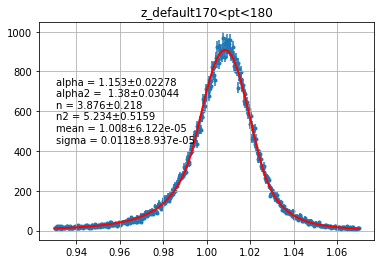

<Figure size 432x288 with 0 Axes>

1.0007644240786921


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.082452025460031, 1.2900283122347427, -6.749778517165311, 5.7907446609308515, 1.0079476507308014, 0.015)


FCN = 1020.96522509 
 TOTAL NCALL = 373 
 NCALLS = 373 
 
 
 EDM = 1.20480241129e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.77326 
 0.015927 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.00841 
 0.0269384 
 
 
 
 
 No 
 
 
 2 
 n 
 1.40379 
 0.0384546 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.97298 
 0.123868 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00851 
 5.29549e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.77326 & 0.015927 & & & & & No\\
\hline
1 & alpha2 & 2.00841 & 0.0269384 & & & & & No\\
\hline
2 & n & 1.40379 & 0.0384546 & & & & & No\\
\hline
3 & n2 & 1.97298 & 0.123868 & & & & & No\\
\hline
4 & mean & 1.00851 & 5.29549e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 646.086745725 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 7.64604588685e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.77326 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.00841 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.40379 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.97298 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00851 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0137727 
 4.27106e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.77326 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.00841 & 1 & & & & & Yes\\
\hline
2 & n & 1.40379 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.97298 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00851 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0137727 & 4.27106e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 371.984284183 
 TOTAL NCALL = 236 
 NCALLS = 236 
 
 
 EDM = 6.07590637057e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.45658 
 0.0174139 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.53411 
 0.0262973 
 
 
 
 
 No 
 
 
 2 
 n 
 1.93744 
 0.0470544 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.63031 
 0.199623 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00876 
 5.43022e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0126154 
 7.18283e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.45658 & 0.0174139 & & & & & No\\
\hline
1 & alpha2 & 1.53411 & 0.0262973 & & & & & No\\
\hline
2 & n & 1.93744 & 0.0470544 & & & & & No\\
\hline
3 & n2 & 3.63031 & 0.199623 & & & & & No\\
\hline
4 & mean & 1.00876 & 5.43022e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0126154 & 7.18283e-05 & & & & & No\\
\hline
\end{tabular}

160<pt<170
14


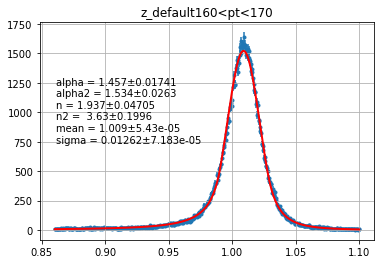

<Figure size 432x288 with 0 Axes>

1.0012350950738498


FCN = 766.570845421 
 TOTAL NCALL = 362 
 NCALLS = 362 
 
 
 EDM = 4.20939446083e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.56143 
 0.0215626 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.87359 
 0.0368413 
 
 
 
 
 No 
 
 
 2 
 n 
 2.22459 
 0.125952 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.10111 
 0.254146 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00898 
 5.67776e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.56143 & 0.0215626 & & & & & No\\
\hline
1 & alpha2 & 1.87359 & 0.0368413 & & & & & No\\
\hline
2 & n & 2.22459 & 0.125952 & & & & & No\\
\hline
3 & n2 & 2.10111 & 0.254146 & & & & & No\\
\hline
4 & mean & 1.00898 & 5.67776e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.5614278262565269, 1.8735938564592536, 2.224589691743268, 2.1011132276757034, 1.0089782782821752, -0.0041250578683626575)


FCN = 548.014270999 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.2729618516e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.56143 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.87359 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.22459 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.10111 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00898 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0140127 
 4.54056e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.56143 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.87359 & 1 & & & & & Yes\\
\hline
2 & n & 2.22459 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.10111 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00898 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0140127 & 4.54056e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 289.430581712 
 TOTAL NCALL = 254 
 NCALLS = 254 
 
 
 EDM = 2.99930654546e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.18355 
 0.0221313 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.34575 
 0.0319481 
 
 
 
 
 No 
 
 
 2 
 n 
 3.73929 
 0.21201 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.48344 
 0.633168 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00929 
 6.25024e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.012574 
 9.13359e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.18355 & 0.0221313 & & & & & No\\
\hline
1 & alpha2 & 1.34575 & 0.0319481 & & & & & No\\
\hline
2 & n & 3.73929 & 0.21201 & & & & & No\\
\hline
3 & n2 & 5.48344 & 0.633168 & & & & & No\\
\hline
4 & mean & 1.00929 & 6.25024e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.012574 & 9.13359e-05 & & & & & No\\
\hline
\end{tabular}

150<pt<160
15


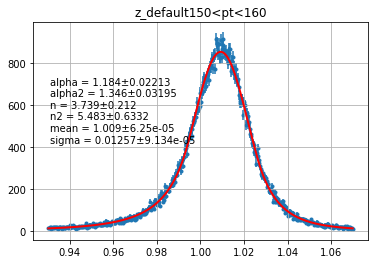

<Figure size 432x288 with 0 Axes>

1.0024259122451764


FCN = 502.07497887 
 TOTAL NCALL = 339 
 NCALLS = 339 
 
 
 EDM = 2.55904280655e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.5433 
 0.0223554 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.6282 
 0.033957 
 
 
 
 
 No 
 
 
 2 
 n 
 2.21491 
 0.128447 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.26569 
 0.401786 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00935 
 6.08227e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.5433 & 0.0223554 & & & & & No\\
\hline
1 & alpha2 & 1.6282 & 0.033957 & & & & & No\\
\hline
2 & n & 2.21491 & 0.128447 & & & & & No\\
\hline
3 & n2 & 3.26569 & 0.401786 & & & & & No\\
\hline
4 & mean & 1.00935 & 6.08227e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.5433038993592854, 1.6281989724191237, 2.2149111003892994, 3.2656856759486583, 1.0093541909634252, -0.0004805166625782443)


FCN = 437.303242416 
 TOTAL NCALL = 21 
 NCALLS = 21 
 
 
 EDM = 5.63891677922e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.5433 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.6282 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.21491 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.26569 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00935 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0144457 
 4.7631e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.5433 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.6282 & 1 & & & & & Yes\\
\hline
2 & n & 2.21491 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.26569 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00935 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0144457 & 4.7631e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 322.972360245 
 TOTAL NCALL = 298 
 NCALLS = 298 
 
 
 EDM = 3.46368983035e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.25649 
 0.0247779 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.22593 
 0.0328063 
 
 
 
 
 No 
 
 
 2 
 n 
 3.36292 
 0.199415 
 
 
 
 
 No 
 
 
 3 
 n2 
 8.56322 
 1.48584 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00938 
 6.69681e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0132517 
 0.000105393 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.25649 & 0.0247779 & & & & & No\\
\hline
1 & alpha2 & 1.22593 & 0.0328063 & & & & & No\\
\hline
2 & n & 3.36292 & 0.199415 & & & & & No\\
\hline
3 & n2 & 8.56322 & 1.48584 & & & & & No\\
\hline
4 & mean & 1.00938 & 6.69681e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0132517 & 0.000105393 & & & & & No\\
\hline
\end{tabular}

140<pt<150
16


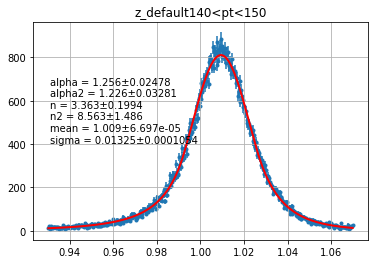

<Figure size 432x288 with 0 Axes>

1.002484338462145


FCN = 415.573006613 
 TOTAL NCALL = 324 
 NCALLS = 324 
 
 
 EDM = 1.30332754533e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.50722 
 0.0216011 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.42645 
 0.03011 
 
 
 
 
 No 
 
 
 2 
 n 
 2.1474 
 0.119755 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.97749 
 0.705998 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00964 
 6.44892e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.50722 & 0.0216011 & & & & & No\\
\hline
1 & alpha2 & 1.42645 & 0.03011 & & & & & No\\
\hline
2 & n & 2.1474 & 0.119755 & & & & & No\\
\hline
3 & n2 & 4.97749 & 0.705998 & & & & & No\\
\hline
4 & mean & 1.00964 & 6.44892e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 378.649764646 
 TOTAL NCALL = 21 
 NCALLS = 21 
 
 
 EDM = 7.38103277347e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.50722 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.42645 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.1474 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 4.97749 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00964 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0145665 
 4.95807e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.50722 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.42645 & 1 & & & & & Yes\\
\hline
2 & n & 2.1474 & 1 & & & & & Yes\\
\hline
3 & n2 & 4.97749 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00964 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0145665 & 4.95807e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 288.056738895 
 TOTAL NCALL = 325 
 NCALLS = 325 
 
 
 EDM = 2.24180168646e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.25456 
 0.0255761 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.0858 
 0.0294919 
 
 
 
 
 No 
 
 
 2 
 n 
 3.06695 
 0.178353 
 
 
 
 
 No 
 
 
 3 
 n2 
 15.913 
 4.59294 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00951 
 7.22459e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0133315 
 0.00011793 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.25456 & 0.0255761 & & & & & No\\
\hline
1 & alpha2 & 1.0858 & 0.0294919 & & & & & No\\
\hline
2 & n & 3.06695 & 0.178353 & & & & & No\\
\hline
3 & n2 & 15.913 & 4.59294 & & & & & No\\
\hline
4 & mean & 1.00951 & 7.22459e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0133315 & 0.00011793 & & & & & No\\
\hline
\end{tabular}

130<pt<140
17


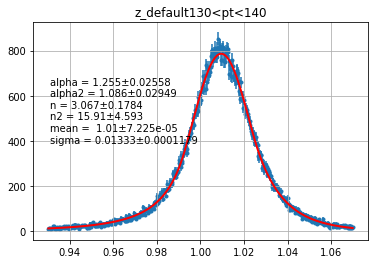

<Figure size 432x288 with 0 Axes>

1.002563246709636


FCN = 343.828233086 
 TOTAL NCALL = 382 
 NCALLS = 382 
 
 
 EDM = 1.1003904442e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37664 
 0.0209827 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.16552 
 0.0242979 
 
 
 
 
 No 
 
 
 2 
 n 
 2.59573 
 0.150943 
 
 
 
 
 No 
 
 
 3 
 n2 
 23.5735 
 11.079 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0101 
 7.21938e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37664 & 0.0209827 & & & & & No\\
\hline
1 & alpha2 & 1.16552 & 0.0242979 & & & & & No\\
\hline
2 & n & 2.59573 & 0.150943 & & & & & No\\
\hline
3 & n2 & 23.5735 & 11.079 & & & & & No\\
\hline
4 & mean & 1.0101 & 7.21938e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 333.783428643 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 9.52263667089e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37664 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.16552 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.59573 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 23.5735 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.0101 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0147727 
 5.0246e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37664 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.16552 & 1 & & & & & Yes\\
\hline
2 & n & 2.59573 & 1 & & & & & Yes\\
\hline
3 & n2 & 23.5735 & 1 & & & & & Yes\\
\hline
4 & mean & 1.0101 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0147727 & 5.0246e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 333.783428643 
 TOTAL NCALL = 93 
 NCALLS = 82 
 
 
 EDM = 632.314485209 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37664 
 0.00867148 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.16552 
 0.0813376 
 
 
 
 
 No 
 
 
 2 
 n 
 2.59573 
 0.0522979 
 
 
 
 
 No 
 
 
 3 
 n2 
 23.5735 
 95.7564 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0101 
 8.90343e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0147727 
 0.000201965 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37664 & 0.00867148 & & & & & No\\
\hline
1 & alpha2 & 1.16552 & 0.0813376 & & & & & No\\
\hline
2 & n & 2.59573 & 0.0522979 & & & & & No\\
\hline
3 & n2 & 23.5735 & 95.7564 & & & & & No\\
\hline
4 & mean & 1.0101 & 8.90343e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0147727 & 0.000201965 & & & & & No\\
\hline
\end{tabular}

120<pt<130
18


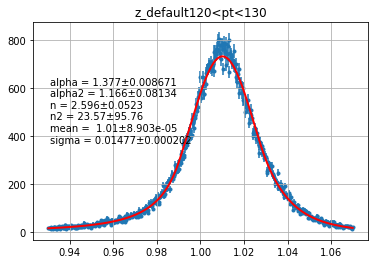

<Figure size 432x288 with 0 Axes>

1.002504248036465


FCN = 324.44521418 
 TOTAL NCALL = 430 
 NCALLS = 430 
 
 
 EDM = 1.43964210851e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.24533 
 0.0194305 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.05371 
 0.0210036 
 
 
 
 
 No 
 
 
 2 
 n 
 3.2512 
 0.201254 
 
 
 
 
 No 
 
 
 3 
 n2 
 56.9239 
 59.9999 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00984 
 7.82948e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.24533 & 0.0194305 & & & & & No\\
\hline
1 & alpha2 & 1.05371 & 0.0210036 & & & & & No\\
\hline
2 & n & 3.2512 & 0.201254 & & & & & No\\
\hline
3 & n2 & 56.9239 & 59.9999 & & & & & No\\
\hline
4 & mean & 1.00984 & 7.82948e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 320.498606493 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 6.267222962e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.24533 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.05371 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.2512 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 56.9239 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00984 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0148545 
 5.14507e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.24533 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.05371 & 1 & & & & & Yes\\
\hline
2 & n & 3.2512 & 1 & & & & & Yes\\
\hline
3 & n2 & 56.9239 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00984 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0148545 & 5.14507e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 299.362814362 
 TOTAL NCALL = 298 
 NCALLS = 287 
 
 
 EDM = 0.264678837852 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.11727 
 0.0251921 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.951277 
 0.0160792 
 
 
 
 
 No 
 
 
 2 
 n 
 3.98548 
 0.280238 
 
 
 
 
 No 
 
 
 3 
 n2 
 120.582 
 77.5894 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00978 
 7.78824e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0140277 
 0.000141789 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.11727 & 0.0251921 & & & & & No\\
\hline
1 & alpha2 & 0.951277 & 0.0160792 & & & & & No\\
\hline
2 & n & 3.98548 & 0.280238 & & & & & No\\
\hline
3 & n2 & 120.582 & 77.5894 & & & & & No\\
\hline
4 & mean & 1.00978 & 7.78824e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0140277 & 0.000141789 & & & & & No\\
\hline
\end{tabular}

110<pt<120
19


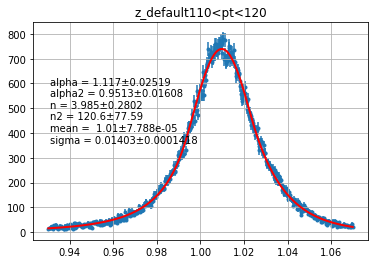

<Figure size 432x288 with 0 Axes>

1.0029456689469052


FCN = 295.626383651 
 TOTAL NCALL = 282 
 NCALLS = 282 
 
 
 EDM = 1.82617615674e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.10721 
 0.0190912 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.04009 
 0.0224656 
 
 
 
 
 No 
 
 
 2 
 n 
 4.69078 
 0.383324 
 
 
 
 
 No 
 
 
 3 
 n2 
 12.8007 
 3.57019 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00904 
 8.89506e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.10721 & 0.0190912 & & & & & No\\
\hline
1 & alpha2 & 1.04009 & 0.0224656 & & & & & No\\
\hline
2 & n & 4.69078 & 0.383324 & & & & & No\\
\hline
3 & n2 & 12.8007 & 3.57019 & & & & & No\\
\hline
4 & mean & 1.00904 & 8.89506e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 295.221594578 
 TOTAL NCALL = 17 
 NCALLS = 17 
 
 
 EDM = 1.64142074836e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.10721 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.04009 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 4.69078 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 12.8007 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00904 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150494 
 5.46737e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.10721 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.04009 & 1 & & & & & Yes\\
\hline
2 & n & 4.69078 & 1 & & & & & Yes\\
\hline
3 & n2 & 12.8007 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00904 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150494 & 5.46737e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 292.165790578 
 TOTAL NCALL = 236 
 NCALLS = 236 
 
 
 EDM = 5.93610964637e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.15981 
 0.0267969 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.10534 
 0.0346198 
 
 
 
 
 No 
 
 
 2 
 n 
 4.24335 
 0.357667 
 
 
 
 
 No 
 
 
 3 
 n2 
 9.23389 
 2.2799 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00906 
 8.58341e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015399 
 0.000144055 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.15981 & 0.0267969 & & & & & No\\
\hline
1 & alpha2 & 1.10534 & 0.0346198 & & & & & No\\
\hline
2 & n & 4.24335 & 0.357667 & & & & & No\\
\hline
3 & n2 & 9.23389 & 2.2799 & & & & & No\\
\hline
4 & mean & 1.00906 & 8.58341e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015399 & 0.000144055 & & & & & No\\
\hline
\end{tabular}

100<pt<110
20


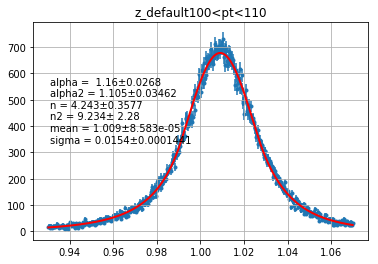

<Figure size 432x288 with 0 Axes>

1.0033250311785913


FCN = 276.822857639 
 TOTAL NCALL = 427 
 NCALLS = 416 
 
 
 EDM = 0.485555421237 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.07498 
 0.0199068 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.779655 
 0.00627131 
 
 
 
 
 No 
 
 
 2 
 n 
 4.84782 
 0.446685 
 
 
 
 
 No 
 
 
 3 
 n2 
 135.92 
 64.6633 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00668 
 9.57217e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.07498 & 0.0199068 & & & & & No\\
\hline
1 & alpha2 & 0.779655 & 0.00627131 & & & & & No\\
\hline
2 & n & 4.84782 & 0.446685 & & & & & No\\
\hline
3 & n2 & 135.92 & 64.6633 & & & & & No\\
\hline
4 & mean & 1.00668 & 9.57217e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 273.974548987 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 4.00079213873e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.07498 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.779655 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 4.84782 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 135.92 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00668 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0151374 
 5.79763e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.07498 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.779655 & 1 & & & & & Yes\\
\hline
2 & n & 4.84782 & 1 & & & & & Yes\\
\hline
3 & n2 & 135.92 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00668 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0151374 & 5.79763e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 273.974548987 
 TOTAL NCALL = 93 
 NCALLS = 82 
 
 
 EDM = 21.929852954 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.07498 
 0.0224834 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.779655 
 0.0124784 
 
 
 
 
 No 
 
 
 2 
 n 
 4.84782 
 0.371445 
 
 
 
 
 No 
 
 
 3 
 n2 
 135.92 
 50.4174 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00668 
 9.83454e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0151374 
 0.000163232 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.07498 & 0.0224834 & & & & & No\\
\hline
1 & alpha2 & 0.779655 & 0.0124784 & & & & & No\\
\hline
2 & n & 4.84782 & 0.371445 & & & & & No\\
\hline
3 & n2 & 135.92 & 50.4174 & & & & & No\\
\hline
4 & mean & 1.00668 & 9.83454e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.0151374 & 0.000163232 & & & & & No\\
\hline
\end{tabular}

90<pt<100
21


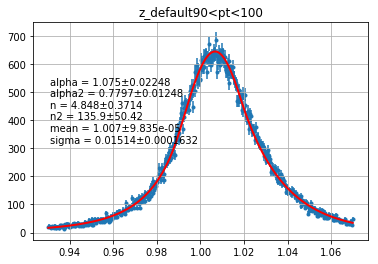

<Figure size 432x288 with 0 Axes>

1.004052352313716


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.0, 1.0, 0.5388750376842566, 4.0, 1.004, 0.015)


FCN = 1771.45377469 
 TOTAL NCALL = 104 
 NCALLS = 93 
 
 
 EDM = 5464.93601081 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 0.00340259 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1 
 0.0608309 
 
 
 
 
 No 
 
 
 2 
 n 
 4.37029 
 0.0477343 
 
 
 
 
 No 
 
 
 3 
 n2 
 4 
 2.04991 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.004 
 0.000104159 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 0.00340259 & & & & & No\\
\hline
1 & alpha2 & 1 & 0.0608309 & & & & & No\\
\hline
2 & n & 4.37029 & 0.0477343 & & & & & No\\
\hline
3 & n2 & 4 & 2.04991 & & & & & No\\
\hline
4 & mean & 1.004 & 0.000104159 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1359.07755568 
 TOTAL NCALL = 23 
 NCALLS = 23 
 
 
 EDM = 1.45707678023e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 4.37029 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 4 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.004 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0166906 
 6.27724e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1 & 1 & & & & & Yes\\
\hline
2 & n & 4.37029 & 1 & & & & & Yes\\
\hline
3 & n2 & 4 & 1 & & & & & Yes\\
\hline
4 & mean & 1.004 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0166906 & 6.27724e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 342.935632595 
 TOTAL NCALL = 453 
 NCALLS = 442 
 
 
 EDM = 0.435539674328 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40549 
 0.0227748 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.79495 
 0.0121396 
 
 
 
 
 No 
 
 
 2 
 n 
 2.20096 
 0.0810873 
 
 
 
 
 No 
 
 
 3 
 n2 
 136.214 
 69.9343 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00475 
 0.000114189 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.017744 
 0.000171388 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40549 & 0.0227748 & & & & & No\\
\hline
1 & alpha2 & 0.79495 & 0.0121396 & & & & & No\\
\hline
2 & n & 2.20096 & 0.0810873 & & & & & No\\
\hline
3 & n2 & 136.214 & 69.9343 & & & & & No\\
\hline
4 & mean & 1.00475 & 0.000114189 & & & & & No\\
\hline
5 & $\sigma$ & 0.017744 & 0.000171388 & & & & & No\\
\hline
\end{tabular}

FCN = 342.935632595 
 TOTAL NCALL = 64 
 NCALLS = 53 
 
 
 EDM = 0.418129514778 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40549 
 0.0157643 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.79495 
 0.0052006 
 
 
 
 
 No 
 
 
 2 
 n 
 2.20096 
 0.0713175 
 
 
 
 
 No 
 
 
 3 
 n2 
 136.214 
 68.7458 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00475 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.017744 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40549 & 0.0157643 & & & & & No\\
\hline
1 & alpha2 & 0.79495 & 0.0052006 & & & & & No\\
\hline
2 & n & 2.20096 & 0.0713175 & & & & & No\\
\hline
3 & n2 & 136.214 & 68.7458 & & & & & No\\
\hline
4 & mean & 1.00475 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.017744 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 342.935632595 
 TOTAL NCALL = 95 
 NCALLS = 84 
 
 
 EDM = 0.436976845602 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40549 
 0.021983 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.79495 
 0.0115205 
 
 
 
 
 No 
 
 
 2 
 n 
 2.20096 
 0.0798577 
 
 
 
 
 No 
 
 
 3 
 n2 
 136.214 
 70.125 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00475 
 0.000111978 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.017744 
 0.000160905 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40549 & 0.021983 & & & & & No\\
\hline
1 & alpha2 & 0.79495 & 0.0115205 & & & & & No\\
\hline
2 & n & 2.20096 & 0.0798577 & & & & & No\\
\hline
3 & n2 & 136.214 & 70.125 & & & & & No\\
\hline
4 & mean & 1.00475 & 0.000111978 & & & & & No\\
\hline
5 & $\sigma$ & 0.017744 & 0.000160905 & & & & & No\\
\hline
\end{tabular}

80<pt<90
22


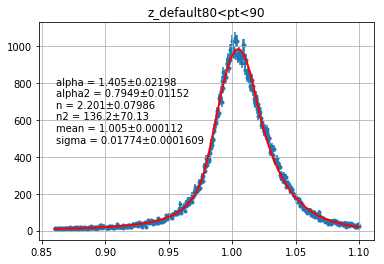

<Figure size 432x288 with 0 Axes>

1.0052526443064813


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (0.8465185945195637, 0.5953742429430214, -4182.311830405541, 80.24487991335853, 1.005469561845319, 0.015)


FCN = 419.897932572 
 TOTAL NCALL = 404 
 NCALLS = 393 
 
 
 EDM = 6.90650805497 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.70259 
 nan 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.598251 
 0.00418513 
 
 
 
 
 No 
 
 
 2 
 n 
 119.606 
 nan 
 
 
 
 
 No 
 
 
 3 
 n2 
 59.0034 
 11.4659 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0057 
 9.50881e-05 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.70259 & nan & & & & & No\\
\hline
1 & alpha2 & 0.598251 & 0.00418513 & & & & & No\\
\hline
2 & n & 119.606 & nan & & & & & No\\
\hline
3 & n2 & 59.0034 & 11.4659 & & & & & No\\
\hline
4 & mean & 1.0057 & 9.50881e-05 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 417.935344965 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 2.65017635325e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.70259 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.598251 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 119.606 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 59.0034 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.0057 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0151272 
 6.46769e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.70259 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.598251 & 1 & & & & & Yes\\
\hline
2 & n & 119.606 & 1 & & & & & Yes\\
\hline
3 & n2 & 59.0034 & 1 & & & & & Yes\\
\hline
4 & mean & 1.0057 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0151272 & 6.46769e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 361.045591785 
 TOTAL NCALL = 110 
 NCALLS = 99 
 
 
 EDM = 28.8695510754 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.818276 
 0.0216519 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.697837 
 0.0199639 
 
 
 
 
 No 
 
 
 2 
 n 
 48.4429 
 42.0169 
 
 
 
 
 No 
 
 
 3 
 n2 
 67.8069 
 12.1908 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00596 
 0.000141091 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0172427 
 0.000406779 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.818276 & 0.0216519 & & & & & No\\
\hline
1 & alpha2 & 0.697837 & 0.0199639 & & & & & No\\
\hline
2 & n & 48.4429 & 42.0169 & & & & & No\\
\hline
3 & n2 & 67.8069 & 12.1908 & & & & & No\\
\hline
4 & mean & 1.00596 & 0.000141091 & & & & & No\\
\hline
5 & $\sigma$ & 0.0172427 & 0.000406779 & & & & & No\\
\hline
\end{tabular}

70<pt<80
23


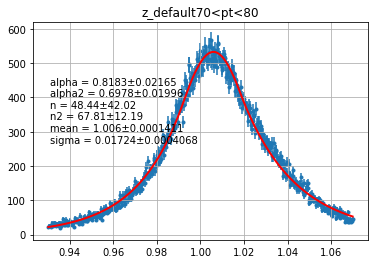

<Figure size 432x288 with 0 Axes>

1.0099338975818912


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.0, 1.0, 0.26475041968126867, 4.0, 1.004, 0.015)


FCN = 883.555990348 
 TOTAL NCALL = 318 
 NCALLS = 318 
 
 
 EDM = 3.41016716693e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.76749 
 0.00929563 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.60488 
 0.00700893 
 
 
 
 
 No 
 
 
 2 
 n 
 4.22146 
 0.126414 
 
 
 
 
 No 
 
 
 3 
 n2 
 5.4232 
 0.197399 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00582 
 0.000149961 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.76749 & 0.00929563 & & & & & No\\
\hline
1 & alpha2 & 0.60488 & 0.00700893 & & & & & No\\
\hline
2 & n & 4.22146 & 0.126414 & & & & & No\\
\hline
3 & n2 & 5.4232 & 0.197399 & & & & & No\\
\hline
4 & mean & 1.00582 & 0.000149961 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 879.235749495 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 4.18722725035e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.76749 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.60488 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 4.22146 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 5.4232 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00582 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0151672 
 5.72938e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.76749 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.60488 & 1 & & & & & Yes\\
\hline
2 & n & 4.22146 & 1 & & & & & Yes\\
\hline
3 & n2 & 5.4232 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00582 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0151672 & 5.72938e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 545.956546367 
 TOTAL NCALL = 346 
 NCALLS = 346 
 
 
 EDM = 4.88624131773e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.27124 
 0.0200209 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.15694 
 0.0232169 
 
 
 
 
 No 
 
 
 2 
 n 
 2.85172 
 0.0955851 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.70602 
 0.107191 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00771 
 0.000128615 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0232739 
 0.000216805 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.27124 & 0.0200209 & & & & & No\\
\hline
1 & alpha2 & 1.15694 & 0.0232169 & & & & & No\\
\hline
2 & n & 2.85172 & 0.0955851 & & & & & No\\
\hline
3 & n2 & 2.70602 & 0.107191 & & & & & No\\
\hline
4 & mean & 1.00771 & 0.000128615 & & & & & No\\
\hline
5 & $\sigma$ & 0.0232739 & 0.000216805 & & & & & No\\
\hline
\end{tabular}

60<pt<70
24


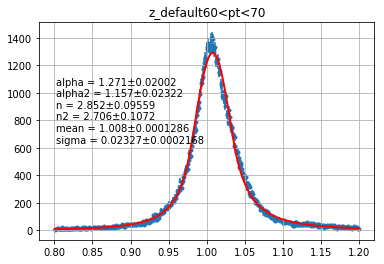

<Figure size 432x288 with 0 Axes>

1.0142101952038176


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.0, 1.0, -1.8870965074917834, 4.0, 1.004, 0.015)


FCN = 661.514473133 
 TOTAL NCALL = 407 
 NCALLS = 407 
 
 
 EDM = 8.72197620711e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.669735 
 0.0086621 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.449748 
 0.00572615 
 
 
 
 
 No 
 
 
 2 
 n 
 5.37109 
 0.209026 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.00396 
 0.381161 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00385 
 0.000187036 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.669735 & 0.0086621 & & & & & No\\
\hline
1 & alpha2 & 0.449748 & 0.00572615 & & & & & No\\
\hline
2 & n & 5.37109 & 0.209026 & & & & & No\\
\hline
3 & n2 & 7.00396 & 0.381161 & & & & & No\\
\hline
4 & mean & 1.00385 & 0.000187036 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 660.288733082 
 TOTAL NCALL = 17 
 NCALLS = 17 
 
 
 EDM = 1.47897020187e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.669735 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.449748 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 5.37109 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 7.00396 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00385 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150902 
 5.7659e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.669735 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.449748 & 1 & & & & & Yes\\
\hline
2 & n & 5.37109 & 1 & & & & & Yes\\
\hline
3 & n2 & 7.00396 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00385 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150902 & 5.7659e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 440.968885625 
 TOTAL NCALL = 371 
 NCALLS = 371 
 
 
 EDM = 2.6387585107e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.21952 
 0.0275033 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.863037 
 0.0222902 
 
 
 
 
 No 
 
 
 2 
 n 
 3.3444 
 0.149259 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.8302 
 0.195678 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00628 
 0.000185008 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0248524 
 0.000351863 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.21952 & 0.0275033 & & & & & No\\
\hline
1 & alpha2 & 0.863037 & 0.0222902 & & & & & No\\
\hline
2 & n & 3.3444 & 0.149259 & & & & & No\\
\hline
3 & n2 & 3.8302 & 0.195678 & & & & & No\\
\hline
4 & mean & 1.00628 & 0.000185008 & & & & & No\\
\hline
5 & $\sigma$ & 0.0248524 & 0.000351863 & & & & & No\\
\hline
\end{tabular}

50<pt<60
25


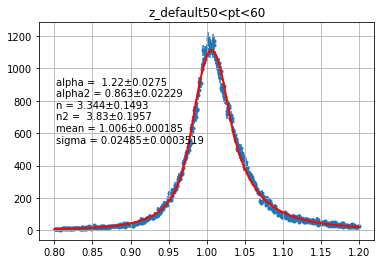

<Figure size 432x288 with 0 Axes>

1.023110055373919


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.0, 1.0, -4.834807701797004, 4.0, 1.004, 0.015)


FCN = 1139.30223835 
 TOTAL NCALL = 432 
 NCALLS = 432 
 
 
 EDM = 2.36775818098e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.616027 
 0.00748437 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.320413 
 0.00309027 
 
 
 
 
 No 
 
 
 2 
 n 
 3.61957 
 0.0761971 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.87212 
 0.211834 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00113 
 0.00023851 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.616027 & 0.00748437 & & & & & No\\
\hline
1 & alpha2 & 0.320413 & 0.00309027 & & & & & No\\
\hline
2 & n & 3.61957 & 0.0761971 & & & & & No\\
\hline
3 & n2 & 6.87212 & 0.211834 & & & & & No\\
\hline
4 & mean & 1.00113 & 0.00023851 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1138.68197376 
 TOTAL NCALL = 21 
 NCALLS = 21 
 
 
 EDM = 8.71396773595e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.616027 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.320413 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.61957 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 6.87212 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00113 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150614 
 5.51817e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.616027 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.320413 & 1 & & & & & Yes\\
\hline
2 & n & 3.61957 & 1 & & & & & Yes\\
\hline
3 & n2 & 6.87212 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00113 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150614 & 5.51817e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 631.736410375 
 TOTAL NCALL = 415 
 NCALLS = 415 
 
 
 EDM = 3.1818693707e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.46336 
 0.0203331 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.964495 
 0.0192532 
 
 
 
 
 No 
 
 
 2 
 n 
 2.37368 
 0.0653613 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.40375 
 0.107411 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00987 
 0.000254752 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0358867 
 0.000357409 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.46336 & 0.0203331 & & & & & No\\
\hline
1 & alpha2 & 0.964495 & 0.0192532 & & & & & No\\
\hline
2 & n & 2.37368 & 0.0653613 & & & & & No\\
\hline
3 & n2 & 3.40375 & 0.107411 & & & & & No\\
\hline
4 & mean & 1.00987 & 0.000254752 & & & & & No\\
\hline
5 & $\sigma$ & 0.0358867 & 0.000357409 & & & & & No\\
\hline
\end{tabular}

40<pt<50
26


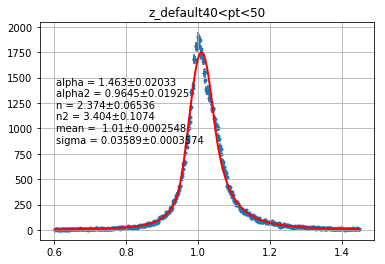

<Figure size 432x288 with 0 Axes>

1.0477210997694104


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.0, 1.0, -10.64750123736004, 4.0, 1.004, 0.015)


FCN = 776.423196134 
 TOTAL NCALL = 429 
 NCALLS = 429 
 
 
 EDM = 1.61672498843e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.269709 
 0.00269113 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.423004 
 0.00623978 
 
 
 
 
 No 
 
 
 2 
 n 
 16.7278 
 1.30185 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.74958 
 0.0587673 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.03976 
 0.000332517 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.269709 & 0.00269113 & & & & & No\\
\hline
1 & alpha2 & 0.423004 & 0.00623978 & & & & & No\\
\hline
2 & n & 16.7278 & 1.30185 & & & & & No\\
\hline
3 & n2 & 2.74958 & 0.0587673 & & & & & No\\
\hline
4 & mean & 1.03976 & 0.000332517 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 776.364422761 
 TOTAL NCALL = 21 
 NCALLS = 21 
 
 
 EDM = 2.27957473492e-11 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.269709 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.423004 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 16.7278 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.74958 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.03976 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.015019 
 5.54856e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.269709 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.423004 & 1 & & & & & Yes\\
\hline
2 & n & 16.7278 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.74958 & 1 & & & & & Yes\\
\hline
4 & mean & 1.03976 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.015019 & 5.54856e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 527.02845599 
 TOTAL NCALL = 449 
 NCALLS = 449 
 
 
 EDM = 4.41793323082e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.811093 
 0.020936 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.01293 
 0.0172399 
 
 
 
 
 No 
 
 
 2 
 n 
 7.22003 
 0.397853 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.24869 
 0.0547111 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.03405 
 0.000312017 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0385321 
 0.000602657 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.811093 & 0.020936 & & & & & No\\
\hline
1 & alpha2 & 1.01293 & 0.0172399 & & & & & No\\
\hline
2 & n & 7.22003 & 0.397853 & & & & & No\\
\hline
3 & n2 & 2.24869 & 0.0547111 & & & & & No\\
\hline
4 & mean & 1.03405 & 0.000312017 & & & & & No\\
\hline
5 & $\sigma$ & 0.0385321 & 0.000602657 & & & & & No\\
\hline
\end{tabular}

30<pt<40
27


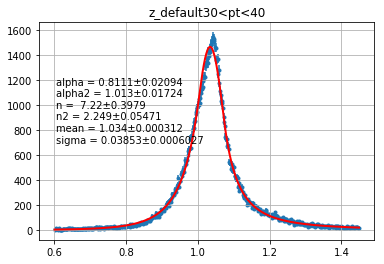

<Figure size 432x288 with 0 Axes>

1.0731353657333893


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:104: SmallIntegralWarning: (1.0, 1.0, -0.2232991717773949, 4.0, 1.004, 0.015)


FCN = 811.643213618 
 TOTAL NCALL = 436 
 NCALLS = 436 
 
 
 EDM = 1.40757121189e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.291042 
 0.0032916 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.257673 
 0.00313791 
 
 
 
 
 No 
 
 
 2 
 n 
 6.02672 
 0.175757 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.46097 
 0.0645946 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.03265 
 0.000436635 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.291042 & 0.0032916 & & & & & No\\
\hline
1 & alpha2 & 0.257673 & 0.00313791 & & & & & No\\
\hline
2 & n & 6.02672 & 0.175757 & & & & & No\\
\hline
3 & n2 & 3.46097 & 0.0645946 & & & & & No\\
\hline
4 & mean & 1.03265 & 0.000436635 & & & & & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 811.619844841 
 TOTAL NCALL = 21 
 NCALLS = 21 
 
 
 EDM = 1.67473118558e-11 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.291042 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.257673 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 6.02672 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.46097 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.03265 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0150124 
 5.7393e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.291042 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.257673 & 1 & & & & & Yes\\
\hline
2 & n & 6.02672 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.46097 & 1 & & & & & Yes\\
\hline
4 & mean & 1.03265 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0150124 & 5.7393e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 379.000580387 
 TOTAL NCALL = 449 
 NCALLS = 449 
 
 
 EDM = 7.35271510278e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.08288 
 0.0192601 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.878817 
 0.0145193 
 
 
 
 
 No 
 
 
 2 
 n 
 3.76403 
 0.111758 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.68102 
 0.0555072 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.03466 
 0.000315984 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.0503423 
 0.000597051 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.08288 & 0.0192601 & & & & & No\\
\hline
1 & alpha2 & 0.878817 & 0.0145193 & & & & & No\\
\hline
2 & n & 3.76403 & 0.111758 & & & & & No\\
\hline
3 & n2 & 2.68102 & 0.0555072 & & & & & No\\
\hline
4 & mean & 1.03466 & 0.000315984 & & & & & No\\
\hline
5 & $\sigma$ & 0.0503423 & 0.000597051 & & & & & No\\
\hline
\end{tabular}

FCN = 379.000568542 
 TOTAL NCALL = 58 
 NCALLS = 58 
 
 
 EDM = 3.53106458364e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.08289 
 0.0103678 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.87882 
 0.00818178 
 
 
 
 
 No 
 
 
 2 
 n 
 3.76424 
 0.0972645 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.68103 
 0.0485011 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.03466 
 1 
 
 
 
 
 Yes 
 
 
 5 
 sigma 
 0.0503423 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.08289 & 0.0103678 & & & & & No\\
\hline
1 & alpha2 & 0.87882 & 0.00818178 & & & & & No\\
\hline
2 & n & 3.76424 & 0.0972645 & & & & & No\\
\hline
3 & n2 & 2.68103 & 0.0485011 & & & & & No\\
\hline
4 & mean & 1.03466 & 1 & & & & & Yes\\
\hline
5 & $\sigma$ & 0.0503423 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 379.000550243 
 TOTAL NCALL = 95 
 NCALLS = 95 
 
 
 EDM = 4.34014389885e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.08288 
 0.019259 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.878821 
 0.0145188 
 
 
 
 
 No 
 
 
 2 
 n 
 3.76425 
 0.111767 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.68102 
 0.0555061 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.03466 
 0.000315983 
 
 
 
 
 No 
 
 
 5 
 sigma 
 0.050343 
 0.000597029 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.08288 & 0.019259 & & & & & No\\
\hline
1 & alpha2 & 0.878821 & 0.0145188 & & & & & No\\
\hline
2 & n & 3.76425 & 0.111767 & & & & & No\\
\hline
3 & n2 & 2.68102 & 0.0555061 & & & & & No\\
\hline
4 & mean & 1.03466 & 0.000315983 & & & & & No\\
\hline
5 & $\sigma$ & 0.050343 & 0.000597029 & & & & & No\\
\hline
\end{tabular}

20<pt<30
28


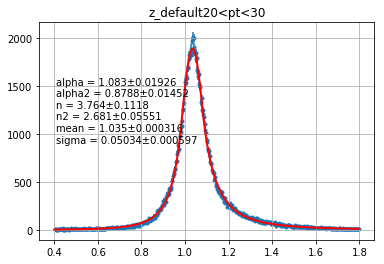

In [16]:
tipe='z_default'
i=0
for para in feat_pt:
  
    if i>23:
        if i>25 and i!=28:
            rmin=0.6
            rmax=1.45
        elif i==28:
            rmin=0.4
            rmax=1.8
        else:
            rmin=0.8
            rmax=1.2
    
    elif i==14 or i==22:
        rmin=0.86
        rmax=1.1
    else:
        rmin = 0.93
        rmax = 1.07
    
    df=data.query(para).astype('double')
    df=df[tipe]
    bound_DCB=[rmin, rmax]
    plt.figure()
    hist,bin_edge=np.histogram(df,bins=nbins)
    plt.show()
    hist_mean=np.mean(hist)
    a=RMS(hist,bin_edge)
    b=evaleffrms(hist,bin_edge)
    c=histsigma(hist,bin_edge)
    normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
    binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
   
    for j in range(5):
        #first step
        if j==0: 
            pars_dcb = dict(mean  = 1.004, 
                        fix_mean = False,
                        sigma  = 0.015,
                        fix_sigma = True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 10,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 4,
                        fix_n2  = False
        
                           )
        
        
        elif j==1:
                pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = True,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = True
                        )
                
        elif j==3:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = True,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
                
        #optimize parameter withoptimized start parameter
        else:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
    
        minuit = iminuit.Minuit(binned_likelihood,print_level=3, **pars_dcb)
        minuit.migrad() #optimized parameter
        if i!=7 and i !=9 and i!=22 and i!=28:
            if j==2:
                break
            else:
                pass
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
    binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    if tipe=='target':
        mean_pt_un[i]=minuit.values['mean']
        mean_err_pt_un[i]=minuit.errors['mean']
        sigma_pt_un[i]=minuit.values['sigma']
        sigma_err_pt_un[i]=minuit.errors['sigma']
    if tipe=='z_default':
        mean_pt_de[i]=minuit.values['mean']
        mean_err_pt_de[i]=minuit.errors['mean']
        sigma_pt_de[i]=minuit.values['sigma']
        sigma_err_pt_de[i]=minuit.errors['sigma']
        rms_pt_de[i]=a
        Eff_sigma_pt_de[i]=b
        histsigma_pt_de[i]=c
    if tipe=='z_bo':
        mean_pt_bo[i]=minuit.values['mean']
        mean_err_pt_bo[i]=minuit.errors['mean']
        sigma_pt_bo[i]=minuit.values['sigma']
        sigma_err_pt_bo[i]=minuit.errors['sigma'] 
    print(para)
    print(i)
    i+=1
    if i==29:
        i=0
        
    plt.title(tipe+para)
    plt.savefig(os.path.join(out_dir+'plot',tipe+para+'_fit'+'.png'))
    plt.show()
    mean_err_pt_de[0]=0
    sigma_err_pt_de[0]=0
np.savetxt('pt_parameter_uncorrected.csv', (mean_pt_de,sigma_pt_de), delimiter=',')

<Figure size 432x288 with 0 Axes>

1.0131001611146884


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.7961429596273641, 2.667545634762278, -2.3057506917590587, 6.855569168763642, 1.0171356819759265, 0.015)


FCN = 1523.68053536 
 TOTAL NCALL = 708 
 NCALLS = 697 
 
 
 EDM = 1.79732485661e+13 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.16352 
 5.89242 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.64038 
 5.89887 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00304 
 3.42188e-05 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.29099 
 0.707107 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01577 
 0.00266405 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.16352 & 5.89242 & & & & & No\\
\hline
1 & alpha2 & 2.64038 & 5.89887 & & & & & No\\
\hline
2 & n & 1.00304 & 3.42188e-05 & & & & & No\\
\hline
3 & n2 & 1.29099 & 0.707107 & & & & & No\\
\hline
4 & mean & 1.01577 & 0.00266405 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 530.352478616 
 TOTAL NCALL = 33 
 NCALLS = 33 
 
 
 EDM = 6.39194776166e-12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.16352 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.64038 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00304 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.29099 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.01577 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.00897717 
 9.4597e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.16352 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.64038 & 1 & & & & & Yes\\
\hline
2 & n & 1.00304 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.29099 & 1 & & & & & Yes\\
\hline
4 & mean & 1.01577 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.00897717 & 9.4597e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 361.139029004 
 TOTAL NCALL = 502 
 NCALLS = 491 
 
 
 EDM = 4.17480584014e+11 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.95874 
 0.0267978 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.06987 
 0.0878651 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00051 
 9.53765e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 11.6191 
 6.3095 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01504 
 0.000161424 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00739093 
 0.000162473 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.95874 & 0.0267978 & & & & & No\\
\hline
1 & alpha2 & 1.06987 & 0.0878651 & & & & & No\\
\hline
2 & n & 1.00051 & 9.53765e-06 & & & & & No\\
\hline
3 & n2 & 11.6191 & 6.3095 & & & & & No\\
\hline
4 & mean & 1.01504 & 0.000161424 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00739093 & 0.000162473 & & & & & No\\
\hline
\end{tabular}

300<pt<310
0


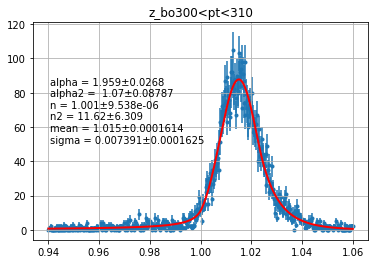

<Figure size 432x288 with 0 Axes>

1.0079366071036013


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (2.137137434707702, 3.457709727944457, -6.2146726762116415, 9.73999888179562, 1.0087754590801463, 0.015)


FCN = 10198.8796542 
 TOTAL NCALL = 599 
 NCALLS = 589 
 
 
 EDM = 2811.61712085 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.70188 
 0.0252551 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 3.75415 
 0.00365694 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00041 
 3.65332e-10 
 
 
 
 
 No 
 
 
 3 
 n2 
 10.7585 
 1.27734 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00841 
 5.07823e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.70188 & 0.0252551 & & & & & No\\
\hline
1 & alpha2 & 3.75415 & 0.00365694 & & & & & No\\
\hline
2 & n & 1.00041 & 3.65332e-10 & & & & & No\\
\hline
3 & n2 & 10.7585 & 1.27734 & & & & & No\\
\hline
4 & mean & 1.00841 & 5.07823e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 3401.30830376 
 TOTAL NCALL = 32 
 NCALLS = 32 
 
 
 EDM = 4.62682595318e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.70188 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 3.75415 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00041 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 10.7585 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00841 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0108874 
 2.7936e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.70188 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 3.75415 & 1 & & & & & Yes\\
\hline
2 & n & 1.00041 & 1 & & & & & Yes\\
\hline
3 & n2 & 10.7585 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00841 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0108874 & 2.7936e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 924.180873993 
 TOTAL NCALL = 236 
 NCALLS = 225 
 
 
 EDM = 9.65020448874e+13 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.3146 
 0.00828349 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.80432 
 0.134574 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00003 
 2.31289e-07 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.75885 
 6.70744 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00827 
 4.37763e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00938451 
 9.3231e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.3146 & 0.00828349 & & & & & No\\
\hline
1 & alpha2 & 1.80432 & 0.134574 & & & & & No\\
\hline
2 & n & 1.00003 & 2.31289e-07 & & & & & No\\
\hline
3 & n2 & 4.75885 & 6.70744 & & & & & No\\
\hline
4 & mean & 1.00827 & 4.37763e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00938451 & 9.3231e-05 & & & & & No\\
\hline
\end{tabular}

290<pt<300
1


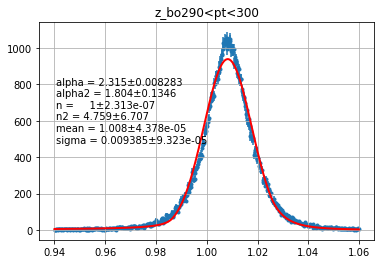

<Figure size 432x288 with 0 Axes>

1.0052732180408528


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (2.3223496823895178, 2.4537230962312813, -2.8342675276898817, 8.873895399335252, 1.0071926295152462, 0.015)


FCN = 7903.0950936 
 TOTAL NCALL = 556 
 NCALLS = 556 
 
 
 EDM = 4.33367935844e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.23674 
 0.0349746 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.75072 
 0.0627942 
 
 
 
 
 No 
 
 
 2 
 n 
 1.02549 
 0.121449 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.697226 
 0.315863 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00673 
 4.79043e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.23674 & 0.0349746 & & & & & No\\
\hline
1 & alpha2 & 2.75072 & 0.0627942 & & & & & No\\
\hline
2 & n & 1.02549 & 0.121449 & & & & & No\\
\hline
3 & n2 & 0.697226 & 0.315863 & & & & & No\\
\hline
4 & mean & 1.00673 & 4.79043e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1912.05203051 
 TOTAL NCALL = 31 
 NCALLS = 31 
 
 
 EDM = 1.03624913716e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.23674 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.75072 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.02549 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 0.697226 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00673 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0108337 
 3.08166e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.23674 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.75072 & 1 & & & & & Yes\\
\hline
2 & n & 1.02549 & 1 & & & & & Yes\\
\hline
3 & n2 & 0.697226 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00673 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0108337 & 3.08166e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1789.37579285 
 TOTAL NCALL = 323 
 NCALLS = 312 
 
 
 EDM = 1268.00237225 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.22792 
 0.00948483 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.76374 
 0.246115 
 
 
 
 
 No 
 
 
 2 
 n 
 1 
 2.8419e-08 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.444165 
 0.680556 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00675 
 3.26275e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0108166 
 3.04433e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.22792 & 0.00948483 & & & & & No\\
\hline
1 & alpha2 & 2.76374 & 0.246115 & & & & & No\\
\hline
2 & n & 1 & 2.8419e-08 & & & & & No\\
\hline
3 & n2 & 0.444165 & 0.680556 & & & & & No\\
\hline
4 & mean & 1.00675 & 3.26275e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0108166 & 3.04433e-05 & & & & & No\\
\hline
\end{tabular}

280<pt<290
2


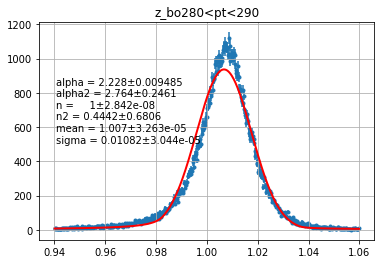

<Figure size 432x288 with 0 Axes>

1.003997096074134


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (2.101482732608759, 2.533111030950116, 0.9160910895488682, 9.020891164911689, 1.0065105000332222, 0.015)


FCN = 7372.06027547 
 TOTAL NCALL = 919 
 NCALLS = 908 
 
 
 EDM = 319.399597346 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.07789 
 0.0205201 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.46244 
 0.0830127 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00043 
 1.37586e-09 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.33965 
 3.78778 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00657 
 4.83863e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.07789 & 0.0205201 & & & & & No\\
\hline
1 & alpha2 & 2.46244 & 0.0830127 & & & & & No\\
\hline
2 & n & 1.00043 & 1.37586e-09 & & & & & No\\
\hline
3 & n2 & 3.33965 & 3.78778 & & & & & No\\
\hline
4 & mean & 1.00657 & 4.83863e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 2092.21623797 
 TOTAL NCALL = 29 
 NCALLS = 29 
 
 
 EDM = 7.80733412776e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.07789 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.46244 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00043 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.33965 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00657 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0110443 
 3.15885e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.07789 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.46244 & 1 & & & & & Yes\\
\hline
2 & n & 1.00043 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.33965 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00657 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0110443 & 3.15885e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1726.0104235 
 TOTAL NCALL = 130 
 NCALLS = 119 
 
 
 EDM = 4378.98596019 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.07789 
 0.00867842 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.46244 
 0.235327 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00043 
 2.11238e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.271 
 1.57162 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00657 
 3.19622e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0110443 
 6.35282e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.07789 & 0.00867842 & & & & & No\\
\hline
1 & alpha2 & 2.46244 & 0.235327 & & & & & No\\
\hline
2 & n & 1.00043 & 2.11238e-06 & & & & & No\\
\hline
3 & n2 & 1.271 & 1.57162 & & & & & No\\
\hline
4 & mean & 1.00657 & 3.19622e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0110443 & 6.35282e-05 & & & & & No\\
\hline
\end{tabular}

270<pt<280
3


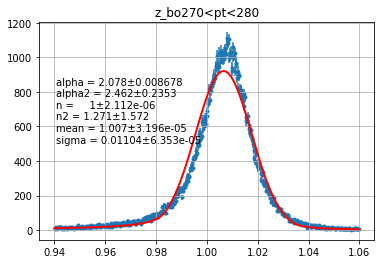

<Figure size 432x288 with 0 Axes>

1.0030352614549902


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.3858261044644402, 2.2274905623251544, 0.1602852042261862, 8.263015914816261, 1.0070781158494992, 0.015)


FCN = 7067.5698755 
 TOTAL NCALL = 662 
 NCALLS = 651 
 
 
 EDM = 4.38893672528e+12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.14991 
 0.00818273 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.59217 
 0.0358525 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00046 
 6.71757e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.30318 
 0.126024 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00645 
 4.78886e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.14991 & 0.00818273 & & & & & No\\
\hline
1 & alpha2 & 2.59217 & 0.0358525 & & & & & No\\
\hline
2 & n & 1.00046 & 6.71757e-06 & & & & & No\\
\hline
3 & n2 & 1.30318 & 0.126024 & & & & & No\\
\hline
4 & mean & 1.00645 & 4.78886e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1923.70628498 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 1.15760870779e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.14991 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.59217 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00046 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.30318 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00645 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0110629 
 3.20486e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.14991 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.59217 & 1 & & & & & Yes\\
\hline
2 & n & 1.00046 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.30318 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00645 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0110629 & 3.20486e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 444.073276922 
 TOTAL NCALL = 412 
 NCALLS = 412 
 
 
 EDM = 7.50460234796e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.38319 
 0.0175516 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.59553 
 0.0255284 
 
 
 
 
 No 
 
 
 2 
 n 
 2.32288 
 0.0604283 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.81367 
 0.174967 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00726 
 4.11871e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00940072 
 5.37655e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.38319 & 0.0175516 & & & & & No\\
\hline
1 & alpha2 & 1.59553 & 0.0255284 & & & & & No\\
\hline
2 & n & 2.32288 & 0.0604283 & & & & & No\\
\hline
3 & n2 & 3.81367 & 0.174967 & & & & & No\\
\hline
4 & mean & 1.00726 & 4.11871e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00940072 & 5.37655e-05 & & & & & No\\
\hline
\end{tabular}

260<pt<270
4


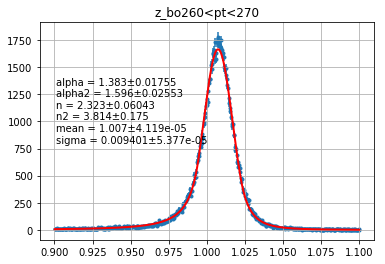

<Figure size 432x288 with 0 Axes>

1.0019947055943135


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.3158840806667031, 2.1552699585797086, -1.979335007330219, 8.231837220373981, 1.0066281062204636, 0.015)


FCN = 6380.09380422 
 TOTAL NCALL = 540 
 NCALLS = 540 
 
 
 EDM = 9.94804011364e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.06549 
 0.0197376 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.62729 
 0.0403727 
 
 
 
 
 No 
 
 
 2 
 n 
 1.05074 
 0.0471747 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.33632 
 0.144111 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00628 
 4.83601e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.06549 & 0.0197376 & & & & & No\\
\hline
1 & alpha2 & 2.62729 & 0.0403727 & & & & & No\\
\hline
2 & n & 1.05074 & 0.0471747 & & & & & No\\
\hline
3 & n2 & 1.33632 & 0.144111 & & & & & No\\
\hline
4 & mean & 1.00628 & 4.83601e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1879.2050605 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 2.09988210124e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.06549 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.62729 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.05074 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.33632 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00628 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0112936 
 3.27014e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.06549 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.62729 & 1 & & & & & Yes\\
\hline
2 & n & 1.05074 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.33632 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00628 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0112936 & 3.27014e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 410.20761044 
 TOTAL NCALL = 335 
 NCALLS = 335 
 
 
 EDM = 6.64113655722e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.32866 
 0.0175561 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.48001 
 0.0252051 
 
 
 
 
 No 
 
 
 2 
 n 
 2.31229 
 0.0591906 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.90785 
 0.249554 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00711 
 4.28348e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0093754 
 6.03519e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.32866 & 0.0175561 & & & & & No\\
\hline
1 & alpha2 & 1.48001 & 0.0252051 & & & & & No\\
\hline
2 & n & 2.31229 & 0.0591906 & & & & & No\\
\hline
3 & n2 & 4.90785 & 0.249554 & & & & & No\\
\hline
4 & mean & 1.00711 & 4.28348e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0093754 & 6.03519e-05 & & & & & No\\
\hline
\end{tabular}

250<pt<260
5


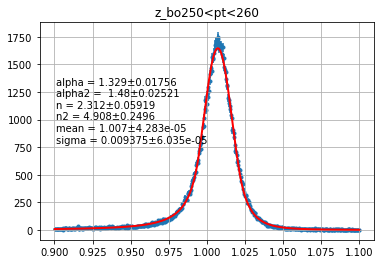

<Figure size 432x288 with 0 Axes>

1.0018150815369071


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.9639192421966218, 2.350256288416814, -1.4525630368392823, 8.629266219791154, 1.0057263648127295, 0.015)


FCN = 5993.70255713 
 TOTAL NCALL = 796 
 NCALLS = 785 
 
 
 EDM = 2.32844530317e+12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.11523 
 0.0108211 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.64951 
 0.0597961 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00139 
 5.56825e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.894467 
 0.326965 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00621 
 4.78948e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.11523 & 0.0108211 & & & & & No\\
\hline
1 & alpha2 & 2.64951 & 0.0597961 & & & & & No\\
\hline
2 & n & 1.00139 & 5.56825e-06 & & & & & No\\
\hline
3 & n2 & 0.894467 & 0.326965 & & & & & No\\
\hline
4 & mean & 1.00621 & 4.78948e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1786.06883832 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 3.32871202178e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.11523 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.64951 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00139 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 0.894467 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00621 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0114076 
 3.30769e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.11523 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.64951 & 1 & & & & & Yes\\
\hline
2 & n & 1.00139 & 1 & & & & & Yes\\
\hline
3 & n2 & 0.894467 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00621 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0114076 & 3.30769e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 342.121117421 
 TOTAL NCALL = 589 
 NCALLS = 589 
 
 
 EDM = 5.06939578198e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.1831 
 0.0208166 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.34549 
 0.0297014 
 
 
 
 
 No 
 
 
 2 
 n 
 3.57939 
 0.168894 
 
 
 
 
 No 
 
 
 3 
 n2 
 8.21245 
 0.977368 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00707 
 4.60166e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00934016 
 6.79891e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.1831 & 0.0208166 & & & & & No\\
\hline
1 & alpha2 & 1.34549 & 0.0297014 & & & & & No\\
\hline
2 & n & 3.57939 & 0.168894 & & & & & No\\
\hline
3 & n2 & 8.21245 & 0.977368 & & & & & No\\
\hline
4 & mean & 1.00707 & 4.60166e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00934016 & 6.79891e-05 & & & & & No\\
\hline
\end{tabular}

240<pt<250
6


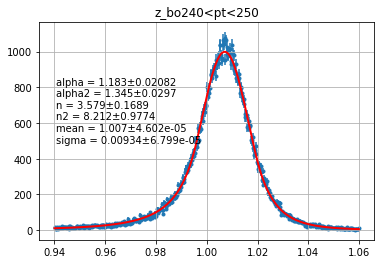

<Figure size 432x288 with 0 Axes>

1.0012167778283771


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.5791568673900334, 2.6897561213390233, 0.03592405839642243, 9.420232692539617, 1.0066252810122787, 0.015)


FCN = 5639.41504825 
 TOTAL NCALL = 629 
 NCALLS = 618 
 
 
 EDM = 1.56592682476e+12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.04713 
 0.00972104 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.41762 
 0.0754269 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00101 
 8.69337e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.52457 
 1.38301 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00644 
 4.74157e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.04713 & 0.00972104 & & & & & No\\
\hline
1 & alpha2 & 2.41762 & 0.0754269 & & & & & No\\
\hline
2 & n & 1.00101 & 8.69337e-06 & & & & & No\\
\hline
3 & n2 & 2.52457 & 1.38301 & & & & & No\\
\hline
4 & mean & 1.00644 & 4.74157e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1729.94814792 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 1.10540513625e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.04713 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.41762 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00101 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.52457 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00644 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0114861 
 3.35389e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.04713 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.41762 & 1 & & & & & Yes\\
\hline
2 & n & 1.00101 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.52457 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00644 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0114861 & 3.35389e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 336.244876675 
 TOTAL NCALL = 564 
 NCALLS = 564 
 
 
 EDM = 2.44707031262e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.22843 
 0.0215439 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.24938 
 0.0293677 
 
 
 
 
 No 
 
 
 2 
 n 
 3.01783 
 0.133307 
 
 
 
 
 No 
 
 
 3 
 n2 
 10.4869 
 1.52553 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00696 
 4.67079e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00931373 
 7.30034e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.22843 & 0.0215439 & & & & & No\\
\hline
1 & alpha2 & 1.24938 & 0.0293677 & & & & & No\\
\hline
2 & n & 3.01783 & 0.133307 & & & & & No\\
\hline
3 & n2 & 10.4869 & 1.52553 & & & & & No\\
\hline
4 & mean & 1.00696 & 4.67079e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00931373 & 7.30034e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 336.244876088 
 TOTAL NCALL = 56 
 NCALLS = 56 
 
 
 EDM = 9.77365726855e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.22843 
 0.0146185 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.24939 
 0.0183706 
 
 
 
 
 No 
 
 
 2 
 n 
 3.01782 
 0.116542 
 
 
 
 
 No 
 
 
 3 
 n2 
 10.4871 
 1.31299 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00696 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.00931373 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.22843 & 0.0146185 & & & & & No\\
\hline
1 & alpha2 & 1.24939 & 0.0183706 & & & & & No\\
\hline
2 & n & 3.01782 & 0.116542 & & & & & No\\
\hline
3 & n2 & 10.4871 & 1.31299 & & & & & No\\
\hline
4 & mean & 1.00696 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.00931373 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 336.244876049 
 TOTAL NCALL = 100 
 NCALLS = 100 
 
 
 EDM = 1.82266330501e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.22843 
 0.0215427 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.24939 
 0.0293754 
 
 
 
 
 No 
 
 
 2 
 n 
 3.01782 
 0.133297 
 
 
 
 
 No 
 
 
 3 
 n2 
 10.4871 
 1.52605 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00696 
 4.67083e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00931374 
 7.30069e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.22843 & 0.0215427 & & & & & No\\
\hline
1 & alpha2 & 1.24939 & 0.0293754 & & & & & No\\
\hline
2 & n & 3.01782 & 0.133297 & & & & & No\\
\hline
3 & n2 & 10.4871 & 1.52605 & & & & & No\\
\hline
4 & mean & 1.00696 & 4.67083e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00931374 & 7.30069e-05 & & & & & No\\
\hline
\end{tabular}

230<pt<240
7


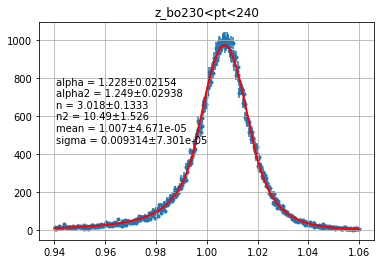

<Figure size 432x288 with 0 Axes>

1.0008081431213838


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.5544099181918059, 2.7348533864423317, -1.0280090860586037, 9.596818903906433, 1.006829705438514, 0.015)


FCN = 5232.21616744 
 TOTAL NCALL = 462 
 NCALLS = 451 
 
 
 EDM = 5754.00158615 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.05614 
 0.00535491 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.28097 
 0.330661 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00003 
 3.07066e-07 
 
 
 
 
 No 
 
 
 3 
 n2 
 8.18979 
 96.1083 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00645 
 6.60258e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.05614 & 0.00535491 & & & & & No\\
\hline
1 & alpha2 & 2.28097 & 0.330661 & & & & & No\\
\hline
2 & n & 1.00003 & 3.07066e-07 & & & & & No\\
\hline
3 & n2 & 8.18979 & 96.1083 & & & & & No\\
\hline
4 & mean & 1.00645 & 6.60258e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1972.7707123 
 TOTAL NCALL = 28 
 NCALLS = 28 
 
 
 EDM = 4.3414573259e-11 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.05614 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.28097 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00003 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 8.18979 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00645 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0118795 
 3.30295e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.05614 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.28097 & 1 & & & & & Yes\\
\hline
2 & n & 1.00003 & 1 & & & & & Yes\\
\hline
3 & n2 & 8.18979 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00645 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0118795 & 3.30295e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 353.48234498 
 TOTAL NCALL = 885 
 NCALLS = 885 
 
 
 EDM = 9.66392722257e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.19786 
 0.0206934 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.24141 
 0.0282845 
 
 
 
 
 No 
 
 
 2 
 n 
 3.18058 
 0.140837 
 
 
 
 
 No 
 
 
 3 
 n2 
 12.1166 
 1.96529 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00713 
 4.71613e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00944623 
 7.25988e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.19786 & 0.0206934 & & & & & No\\
\hline
1 & alpha2 & 1.24141 & 0.0282845 & & & & & No\\
\hline
2 & n & 3.18058 & 0.140837 & & & & & No\\
\hline
3 & n2 & 12.1166 & 1.96529 & & & & & No\\
\hline
4 & mean & 1.00713 & 4.71613e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00944623 & 7.25988e-05 & & & & & No\\
\hline
\end{tabular}

220<pt<230
8


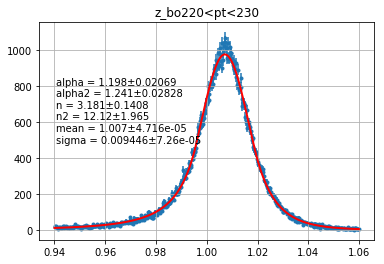

<Figure size 432x288 with 0 Axes>

1.000872813932418


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.856326646489991, 2.460911975588944, -2.2551134587174584, 8.973568547933738, 1.0067602478290656, 0.015)


FCN = 4729.77565288 
 TOTAL NCALL = 1052 
 NCALLS = 1041 
 
 
 EDM = 2.04980093646e+12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.0728 
 0.0101695 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.4614 
 0.0514223 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00101 
 6.54357e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.45368 
 0.633919 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00681 
 4.90093e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.0728 & 0.0101695 & & & & & No\\
\hline
1 & alpha2 & 2.4614 & 0.0514223 & & & & & No\\
\hline
2 & n & 1.00101 & 6.54357e-06 & & & & & No\\
\hline
3 & n2 & 1.45368 & 0.633919 & & & & & No\\
\hline
4 & mean & 1.00681 & 4.90093e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1555.31584612 
 TOTAL NCALL = 25 
 NCALLS = 25 
 
 
 EDM = 2.04438410019e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.0728 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.4614 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00101 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.45368 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00681 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0117962 
 3.48588e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.0728 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.4614 & 1 & & & & & Yes\\
\hline
2 & n & 1.00101 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.45368 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00681 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0117962 & 3.48588e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1430.64420931 
 TOTAL NCALL = 159 
 NCALLS = 148 
 
 
 EDM = 675.687728485 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.0724 
 0.00841255 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.46082 
 0.235672 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00009 
 2.11835e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.948039 
 1.23981 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00681 
 3.38481e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0117946 
 5.10287e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.0724 & 0.00841255 & & & & & No\\
\hline
1 & alpha2 & 2.46082 & 0.235672 & & & & & No\\
\hline
2 & n & 1.00009 & 2.11835e-06 & & & & & No\\
\hline
3 & n2 & 0.948039 & 1.23981 & & & & & No\\
\hline
4 & mean & 1.00681 & 3.38481e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0117946 & 5.10287e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 1430.64420931 
 TOTAL NCALL = 66 
 NCALLS = 55 
 
 
 EDM = 322.545763495 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.0724 
 0.00758499 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.46082 
 0.260672 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00009 
 7.68397e-07 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.948039 
 1.32721 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00681 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0117946 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.0724 & 0.00758499 & & & & & No\\
\hline
1 & alpha2 & 2.46082 & 0.260672 & & & & & No\\
\hline
2 & n & 1.00009 & 7.68397e-07 & & & & & No\\
\hline
3 & n2 & 0.948039 & 1.32721 & & & & & No\\
\hline
4 & mean & 1.00681 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0117946 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1430.64420931 
 TOTAL NCALL = 95 
 NCALLS = 84 
 
 
 EDM = 611.930557226 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.0724 
 0.00828222 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.46082 
 0.238013 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00009 
 7.67507e-07 
 
 
 
 
 No 
 
 
 3 
 n2 
 0.948039 
 1.24604 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00681 
 3.39957e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0117946 
 4.68156e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.0724 & 0.00828222 & & & & & No\\
\hline
1 & alpha2 & 2.46082 & 0.238013 & & & & & No\\
\hline
2 & n & 1.00009 & 7.67507e-07 & & & & & No\\
\hline
3 & n2 & 0.948039 & 1.24604 & & & & & No\\
\hline
4 & mean & 1.00681 & 3.39957e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0117946 & 4.68156e-05 & & & & & No\\
\hline
\end{tabular}

210<pt<220
9


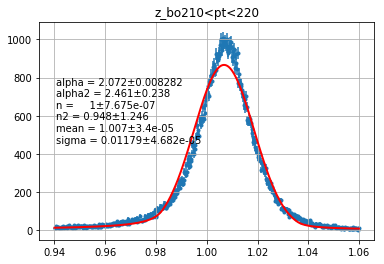

<Figure size 432x288 with 0 Axes>

1.0008783703344009


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (2.017690082991351, 2.0430843930230216, 0.9045269003863311, 7.926798620130951, 1.0070447815678814, 0.015)


FCN = 4087.26135811 
 TOTAL NCALL = 597 
 NCALLS = 586 
 
 
 EDM = 2.42649058703e+12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.04486 
 0.00998161 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.37848 
 0.0617907 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00041 
 1.04159e-05 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.76971 
 0.527781 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00706 
 4.91632e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.04486 & 0.00998161 & & & & & No\\
\hline
1 & alpha2 & 2.37848 & 0.0617907 & & & & & No\\
\hline
2 & n & 1.00041 & 1.04159e-05 & & & & & No\\
\hline
3 & n2 & 1.76971 & 0.527781 & & & & & No\\
\hline
4 & mean & 1.00706 & 4.91632e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1500.86239314 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 3.42483834192e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.04486 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.37848 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00041 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.76971 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00706 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0120466 
 3.58837e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.04486 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.37848 & 1 & & & & & Yes\\
\hline
2 & n & 1.00041 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.76971 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00706 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0120466 & 3.58837e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 349.6072667 
 TOTAL NCALL = 561 
 NCALLS = 561 
 
 
 EDM = 2.85029489692e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.23611 
 0.0230663 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.20226 
 0.030382 
 
 
 
 
 No 
 
 
 2 
 n 
 3.09856 
 0.149194 
 
 
 
 
 No 
 
 
 3 
 n2 
 13.0092 
 2.52059 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00748 
 5.04256e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.00986539 
 8.20331e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.23611 & 0.0230663 & & & & & No\\
\hline
1 & alpha2 & 1.20226 & 0.030382 & & & & & No\\
\hline
2 & n & 3.09856 & 0.149194 & & & & & No\\
\hline
3 & n2 & 13.0092 & 2.52059 & & & & & No\\
\hline
4 & mean & 1.00748 & 5.04256e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.00986539 & 8.20331e-05 & & & & & No\\
\hline
\end{tabular}

200<pt<210
10


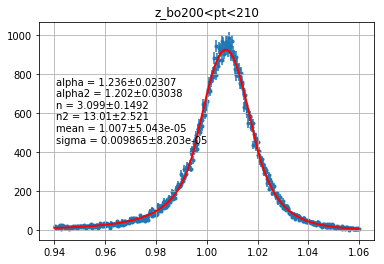

<Figure size 432x288 with 0 Axes>

1.0008360979426127


FCN = 3402.63992176 
 TOTAL NCALL = 478 
 NCALLS = 478 
 
 
 EDM = 1.27393902879e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.00881 
 0.0260471 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.23316 
 0.0536495 
 
 
 
 
 No 
 
 
 2 
 n 
 1.09995 
 0.090098 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.20373 
 0.549641 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0076 
 4.96977e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.00881 & 0.0260471 & & & & & No\\
\hline
1 & alpha2 & 2.23316 & 0.0536495 & & & & & No\\
\hline
2 & n & 1.09995 & 0.090098 & & & & & No\\
\hline
3 & n2 & 2.20373 & 0.549641 & & & & & No\\
\hline
4 & mean & 1.0076 & 4.96977e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (2.008807370276454, 2.2331567261741823, 1.0999476003123025, 2.203725201117614, 1.0076047103238208, -0.025283289039172943)


FCN = 1438.57425253 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 7.22148978996e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.00881 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.23316 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.09995 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.20373 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.0076 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.012386 
 3.70855e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.00881 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.23316 & 1 & & & & & Yes\\
\hline
2 & n & 1.09995 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.20373 & 1 & & & & & Yes\\
\hline
4 & mean & 1.0076 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.012386 & 3.70855e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 330.946095892 
 TOTAL NCALL = 521 
 NCALLS = 521 
 
 
 EDM = 2.17920781372e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.24665 
 0.023989 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.09797 
 0.026299 
 
 
 
 
 No 
 
 
 2 
 n 
 3.09267 
 0.155557 
 
 
 
 
 No 
 
 
 3 
 n2 
 22.9526 
 7.11378 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00772 
 5.26995e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0100468 
 8.55725e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.24665 & 0.023989 & & & & & No\\
\hline
1 & alpha2 & 1.09797 & 0.026299 & & & & & No\\
\hline
2 & n & 3.09267 & 0.155557 & & & & & No\\
\hline
3 & n2 & 22.9526 & 7.11378 & & & & & No\\
\hline
4 & mean & 1.00772 & 5.26995e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0100468 & 8.55725e-05 & & & & & No\\
\hline
\end{tabular}

190<pt<200
11


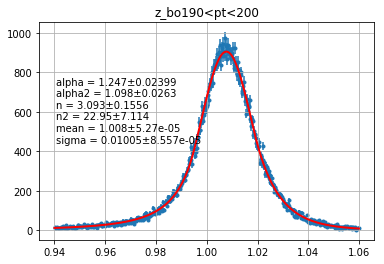

<Figure size 432x288 with 0 Axes>

1.001038559220056


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.440936710054732, 2.3049386047454403, 0.5967259154509925, 8.647502475559968, 1.0085649143703626, 0.015)


FCN = 2711.33466745 
 TOTAL NCALL = 884 
 NCALLS = 873 
 
 
 EDM = 3.9252468697e+12 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.0168 
 0.0097878 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.24135 
 0.0490111 
 
 
 
 
 No 
 
 
 2 
 n 
 1.00094 
 2.59201e-06 
 
 
 
 
 No 
 
 
 3 
 n2 
 1.70848 
 0.394973 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00795 
 4.98314e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.0168 & 0.0097878 & & & & & No\\
\hline
1 & alpha2 & 2.24135 & 0.0490111 & & & & & No\\
\hline
2 & n & 1.00094 & 2.59201e-06 & & & & & No\\
\hline
3 & n2 & 1.70848 & 0.394973 & & & & & No\\
\hline
4 & mean & 1.00795 & 4.98314e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1215.07192988 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 3.08984029814e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 2.0168 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.24135 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.00094 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 1.70848 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00795 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0126813 
 3.83259e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 2.0168 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.24135 & 1 & & & & & Yes\\
\hline
2 & n & 1.00094 & 1 & & & & & Yes\\
\hline
3 & n2 & 1.70848 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00795 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0126813 & 3.83259e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 354.52656096 
 TOTAL NCALL = 748 
 NCALLS = 748 
 
 
 EDM = 1.40371840053e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.23157 
 0.0243997 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.06719 
 0.026403 
 
 
 
 
 No 
 
 
 2 
 n 
 3.18904 
 0.165174 
 
 
 
 
 No 
 
 
 3 
 n2 
 56.7351 
 42.6903 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00805 
 5.52248e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0103228 
 9.29196e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.23157 & 0.0243997 & & & & & No\\
\hline
1 & alpha2 & 1.06719 & 0.026403 & & & & & No\\
\hline
2 & n & 3.18904 & 0.165174 & & & & & No\\
\hline
3 & n2 & 56.7351 & 42.6903 & & & & & No\\
\hline
4 & mean & 1.00805 & 5.52248e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0103228 & 9.29196e-05 & & & & & No\\
\hline
\end{tabular}

180<pt<190
12


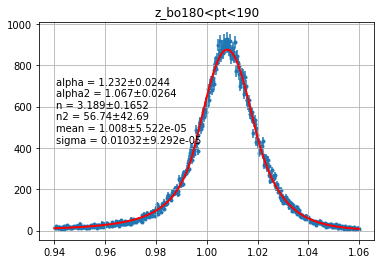

<Figure size 432x288 with 0 Axes>

1.0011274125404495


FCN = 2281.91551419 
 TOTAL NCALL = 550 
 NCALLS = 550 
 
 
 EDM = 1.29814898888e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.91904 
 0.02692 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.11792 
 0.0534881 
 
 
 
 
 No 
 
 
 2 
 n 
 1.29785 
 0.103562 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.06898 
 0.489235 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00813 
 5.12864e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.91904 & 0.02692 & & & & & No\\
\hline
1 & alpha2 & 2.11792 & 0.0534881 & & & & & No\\
\hline
2 & n & 1.29785 & 0.103562 & & & & & No\\
\hline
3 & n2 & 2.06898 & 0.489235 & & & & & No\\
\hline
4 & mean & 1.00813 & 5.12864e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.9190423866252742, 2.11791608477783, 1.297853173439595, 2.0689827055437986, 1.0081272575939424, -0.017990004514790284)


FCN = 1166.79017498 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.3225852453e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.91904 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.11792 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.29785 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.06898 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00813 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0129515 
 3.97807e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.91904 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.11792 & 1 & & & & & Yes\\
\hline
2 & n & 1.29785 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.06898 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00813 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0129515 & 3.97807e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 337.934511605 
 TOTAL NCALL = 611 
 NCALLS = 611 
 
 
 EDM = 2.00120138693e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.15282 
 0.0250197 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.02107 
 0.0266778 
 
 
 
 
 No 
 
 
 2 
 n 
 3.82865 
 0.222363 
 
 
 
 
 No 
 
 
 3 
 n2 
 89.2952 
 106.798 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0082 
 5.84655e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0103951 
 0.000106933 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.15282 & 0.0250197 & & & & & No\\
\hline
1 & alpha2 & 1.02107 & 0.0266778 & & & & & No\\
\hline
2 & n & 3.82865 & 0.222363 & & & & & No\\
\hline
3 & n2 & 89.2952 & 106.798 & & & & & No\\
\hline
4 & mean & 1.0082 & 5.84655e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0103951 & 0.000106933 & & & & & No\\
\hline
\end{tabular}

170<pt<180
13


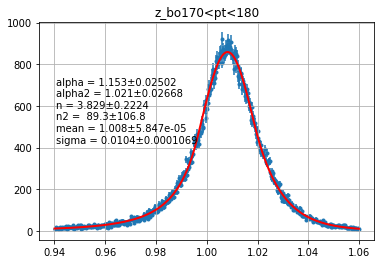

<Figure size 432x288 with 0 Axes>

1.0011986721077717


FCN = 1970.64469862 
 TOTAL NCALL = 332 
 NCALLS = 332 
 
 
 EDM = 2.68175035938e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.87665 
 0.0193716 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 2.07334 
 0.0284818 
 
 
 
 
 No 
 
 
 2 
 n 
 1.3864 
 0.0554604 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.31634 
 0.158083 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00866 
 5.10666e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.87665 & 0.0193716 & & & & & No\\
\hline
1 & alpha2 & 2.07334 & 0.0284818 & & & & & No\\
\hline
2 & n & 1.3864 & 0.0554604 & & & & & No\\
\hline
3 & n2 & 2.31634 & 0.158083 & & & & & No\\
\hline
4 & mean & 1.00866 & 5.10666e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.876645996048168, 2.0733417430091947, 1.3863995154386926, 2.316340067609719, 1.0086643454392392, -0.015658031972865326)


FCN = 1070.6849052 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.62383372119e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.87665 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 2.07334 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.3864 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.31634 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00866 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0131959 
 3.94438e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.87665 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 2.07334 & 1 & & & & & Yes\\
\hline
2 & n & 1.3864 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.31634 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00866 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0131959 & 3.94438e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 465.892192729 
 TOTAL NCALL = 266 
 NCALLS = 266 
 
 
 EDM = 5.17889086512e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.42558 
 0.0190041 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.30585 
 0.0249957 
 
 
 
 
 No 
 
 
 2 
 n 
 2.22639 
 0.0668126 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.42122 
 0.437548 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00868 
 5.30856e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0114855 
 7.65745e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.42558 & 0.0190041 & & & & & No\\
\hline
1 & alpha2 & 1.30585 & 0.0249957 & & & & & No\\
\hline
2 & n & 2.22639 & 0.0668126 & & & & & No\\
\hline
3 & n2 & 6.42122 & 0.437548 & & & & & No\\
\hline
4 & mean & 1.00868 & 5.30856e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0114855 & 7.65745e-05 & & & & & No\\
\hline
\end{tabular}

160<pt<170
14


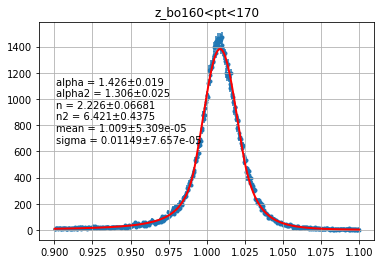

<Figure size 432x288 with 0 Axes>

1.0012088978775946


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.4627102604994295, 1.7046268224711474, 0.8101244515057489, 7.066812109135081, 1.0096544852221974, 0.015)


FCN = 1307.75432474 
 TOTAL NCALL = 314 
 NCALLS = 314 
 
 
 EDM = 5.72098424622e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.82361 
 0.0186581 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.88814 
 0.0257766 
 
 
 
 
 No 
 
 
 2 
 n 
 1.39458 
 0.0533883 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.66743 
 0.167444 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0088 
 5.29292e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.82361 & 0.0186581 & & & & & No\\
\hline
1 & alpha2 & 1.88814 & 0.0257766 & & & & & No\\
\hline
2 & n & 1.39458 & 0.0533883 & & & & & No\\
\hline
3 & n2 & 2.66743 & 0.167444 & & & & & No\\
\hline
4 & mean & 1.0088 & 5.29292e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 834.743262556 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.17784989963e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.82361 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.88814 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.39458 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 2.66743 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.0088 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0136344 
 4.20799e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.82361 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.88814 & 1 & & & & & Yes\\
\hline
2 & n & 1.39458 & 1 & & & & & Yes\\
\hline
3 & n2 & 2.66743 & 1 & & & & & Yes\\
\hline
4 & mean & 1.0088 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0136344 & 4.20799e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 407.418761746 
 TOTAL NCALL = 282 
 NCALLS = 282 
 
 
 EDM = 7.45156935614e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40087 
 0.0202158 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.24276 
 0.02325 
 
 
 
 
 No 
 
 
 2 
 n 
 2.22729 
 0.0707771 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.56801 
 0.445768 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00872 
 5.65564e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0118904 
 8.46958e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40087 & 0.0202158 & & & & & No\\
\hline
1 & alpha2 & 1.24276 & 0.02325 & & & & & No\\
\hline
2 & n & 2.22729 & 0.0707771 & & & & & No\\
\hline
3 & n2 & 6.56801 & 0.445768 & & & & & No\\
\hline
4 & mean & 1.00872 & 5.65564e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0118904 & 8.46958e-05 & & & & & No\\
\hline
\end{tabular}

150<pt<160
15


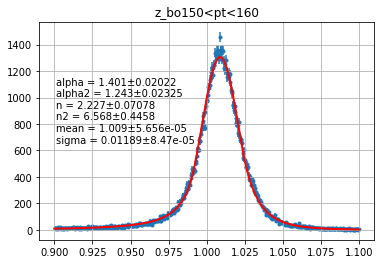

<Figure size 432x288 with 0 Axes>

1.001885653293985


FCN = 1023.79560086 
 TOTAL NCALL = 298 
 NCALLS = 298 
 
 
 EDM = 1.1219456749e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.75199 
 0.0191139 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.71467 
 0.0232467 
 
 
 
 
 No 
 
 
 2 
 n 
 1.59634 
 0.0618453 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.15123 
 0.187423 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00883 
 5.53004e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.75199 & 0.0191139 & & & & & No\\
\hline
1 & alpha2 & 1.71467 & 0.0232467 & & & & & No\\
\hline
2 & n & 1.59634 & 0.0618453 & & & & & No\\
\hline
3 & n2 & 3.15123 & 0.187423 & & & & & No\\
\hline
4 & mean & 1.00883 & 5.53004e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.7519940281675617, 1.714668779449403, 1.5963366634213454, 3.1512349910924593, 1.0088296792577822, -0.0071002747777187195)


FCN = 716.503863677 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 5.02922872715e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.75199 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.71467 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.59634 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.15123 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00883 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0138652 
 4.37599e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.75199 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.71467 & 1 & & & & & Yes\\
\hline
2 & n & 1.59634 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.15123 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00883 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0138652 & 4.37599e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 370.250474576 
 TOTAL NCALL = 266 
 NCALLS = 266 
 
 
 EDM = 1.08716699674e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.37544 
 0.0207467 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.21695 
 0.0229023 
 
 
 
 
 No 
 
 
 2 
 n 
 2.39905 
 0.0809271 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.12309 
 0.404713 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00872 
 5.92753e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0122353 
 8.94209e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.37544 & 0.0207467 & & & & & No\\
\hline
1 & alpha2 & 1.21695 & 0.0229023 & & & & & No\\
\hline
2 & n & 2.39905 & 0.0809271 & & & & & No\\
\hline
3 & n2 & 6.12309 & 0.404713 & & & & & No\\
\hline
4 & mean & 1.00872 & 5.92753e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0122353 & 8.94209e-05 & & & & & No\\
\hline
\end{tabular}

140<pt<150
16


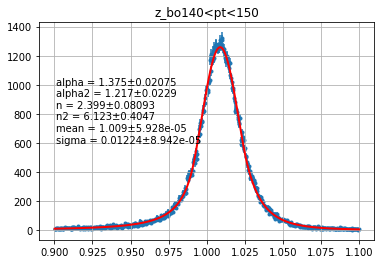

<Figure size 432x288 with 0 Axes>

1.0016727005414796


FCN = 756.567455324 
 TOTAL NCALL = 352 
 NCALLS = 352 
 
 
 EDM = 4.02999935133e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.6765 
 0.0239135 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.57159 
 0.034317 
 
 
 
 
 No 
 
 
 2 
 n 
 1.75949 
 0.119613 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.13727 
 0.488594 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00892 
 5.80389e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.6765 & 0.0239135 & & & & & No\\
\hline
1 & alpha2 & 1.57159 & 0.034317 & & & & & No\\
\hline
2 & n & 1.75949 & 0.119613 & & & & & No\\
\hline
3 & n2 & 3.13727 & 0.488594 & & & & & No\\
\hline
4 & mean & 1.00892 & 5.80389e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.6764960328418486, 1.5715891488858966, 1.7594868770048575, 3.1372653450972097, 1.0089227538850203, -0.003999943445457302)


FCN = 574.774208803 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 1.64715833539e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.6765 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.57159 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 1.75949 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.13727 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00892 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0140521 
 4.7899e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.6765 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.57159 & 1 & & & & & Yes\\
\hline
2 & n & 1.75949 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.13727 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00892 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0140521 & 4.7899e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 353.06796178 
 TOTAL NCALL = 429 
 NCALLS = 429 
 
 
 EDM = 3.45273081149e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.33143 
 0.0258912 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.02473 
 0.0300066 
 
 
 
 
 No 
 
 
 2 
 n 
 2.78026 
 0.170357 
 
 
 
 
 No 
 
 
 3 
 n2 
 24.5134 
 12.8579 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00854 
 7.12158e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0125106 
 0.000105459 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.33143 & 0.0258912 & & & & & No\\
\hline
1 & alpha2 & 1.02473 & 0.0300066 & & & & & No\\
\hline
2 & n & 2.78026 & 0.170357 & & & & & No\\
\hline
3 & n2 & 24.5134 & 12.8579 & & & & & No\\
\hline
4 & mean & 1.00854 & 7.12158e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0125106 & 0.000105459 & & & & & No\\
\hline
\end{tabular}

130<pt<140
17


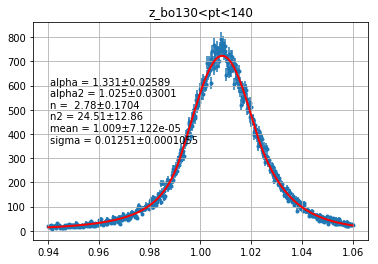

<Figure size 432x288 with 0 Axes>

1.0018797806558717


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.2585722833594957, 1.3035535039190365, 0.6840044471709756, 7.794443751332774, 1.0096405913866122, 0.015)


FCN = 563.599855361 
 TOTAL NCALL = 318 
 NCALLS = 318 
 
 
 EDM = 2.08913554989e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.5537 
 0.024496 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.32177 
 0.0326252 
 
 
 
 
 No 
 
 
 2 
 n 
 2.04702 
 0.143194 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.12107 
 1.39101 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00935 
 6.49667e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.5537 & 0.024496 & & & & & No\\
\hline
1 & alpha2 & 1.32177 & 0.0326252 & & & & & No\\
\hline
2 & n & 2.04702 & 0.143194 & & & & & No\\
\hline
3 & n2 & 6.12107 & 1.39101 & & & & & No\\
\hline
4 & mean & 1.00935 & 6.49667e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 524.084270859 
 TOTAL NCALL = 21 
 NCALLS = 21 
 
 
 EDM = 1.40062624683e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.5537 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.32177 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.04702 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 6.12107 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00935 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0145386 
 5.08856e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.5537 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.32177 & 1 & & & & & Yes\\
\hline
2 & n & 2.04702 & 1 & & & & & Yes\\
\hline
3 & n2 & 6.12107 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00935 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0145386 & 5.08856e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 422.037060942 
 TOTAL NCALL = 429 
 NCALLS = 418 
 
 
 EDM = 0.306295067838 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.28273 
 0.0274112 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.954108 
 0.0170628 
 
 
 
 
 No 
 
 
 2 
 n 
 3.0167 
 0.204429 
 
 
 
 
 No 
 
 
 3 
 n2 
 120.72 
 80.1744 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00893 
 7.44206e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0131102 
 0.000124658 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.28273 & 0.0274112 & & & & & No\\
\hline
1 & alpha2 & 0.954108 & 0.0170628 & & & & & No\\
\hline
2 & n & 3.0167 & 0.204429 & & & & & No\\
\hline
3 & n2 & 120.72 & 80.1744 & & & & & No\\
\hline
4 & mean & 1.00893 & 7.44206e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0131102 & 0.000124658 & & & & & No\\
\hline
\end{tabular}

120<pt<130
18


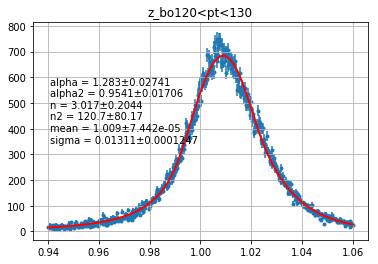

<Figure size 432x288 with 0 Axes>

1.001859914457973


FCN = 413.029109488 
 TOTAL NCALL = 272 
 NCALLS = 272 
 
 
 EDM = 5.80330550579e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.5006 
 0.0170023 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.18534 
 0.0174324 
 
 
 
 
 No 
 
 
 2 
 n 
 2.1116 
 0.075514 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.17861 
 0.615425 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00923 
 6.73981e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.5006 & 0.0170023 & & & & & No\\
\hline
1 & alpha2 & 1.18534 & 0.0174324 & & & & & No\\
\hline
2 & n & 2.1116 & 0.075514 & & & & & No\\
\hline
3 & n2 & 7.17861 & 0.615425 & & & & & No\\
\hline
4 & mean & 1.00923 & 6.73981e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 405.083341283 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 2.35596334562e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.5006 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1.18534 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 2.1116 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 7.17861 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00923 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0148055 
 4.844e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.5006 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1.18534 & 1 & & & & & Yes\\
\hline
2 & n & 2.1116 & 1 & & & & & Yes\\
\hline
3 & n2 & 7.17861 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00923 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0148055 & 4.844e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 379.951209488 
 TOTAL NCALL = 235 
 NCALLS = 235 
 
 
 EDM = 9.09801711405e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.40786 
 0.0210695 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.04435 
 0.022143 
 
 
 
 
 No 
 
 
 2 
 n 
 2.30789 
 0.0860297 
 
 
 
 
 No 
 
 
 3 
 n2 
 10.5171 
 1.23698 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00898 
 7.70862e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0141362 
 0.000110103 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.40786 & 0.0210695 & & & & & No\\
\hline
1 & alpha2 & 1.04435 & 0.022143 & & & & & No\\
\hline
2 & n & 2.30789 & 0.0860297 & & & & & No\\
\hline
3 & n2 & 10.5171 & 1.23698 & & & & & No\\
\hline
4 & mean & 1.00898 & 7.70862e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0141362 & 0.000110103 & & & & & No\\
\hline
\end{tabular}

110<pt<120
19


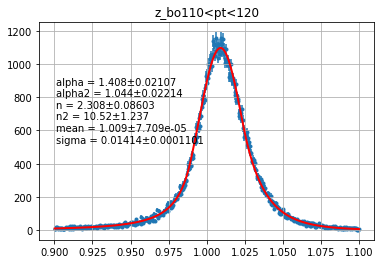

<Figure size 432x288 with 0 Axes>

1.002775670245169


FCN = 4303.53456103 
 TOTAL NCALL = 72 
 NCALLS = 61 
 
 
 EDM = 1980.7363041 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 0.00368185 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1 
 0.0656998 
 
 
 
 
 No 
 
 
 2 
 n 
 10 
 0.142348 
 
 
 
 
 No 
 
 
 3 
 n2 
 4 
 7.65034 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.004 
 0.000153566 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 0.00368185 & & & & & No\\
\hline
1 & alpha2 & 1 & 0.0656998 & & & & & No\\
\hline
2 & n & 10 & 0.142348 & & & & & No\\
\hline
3 & n2 & 4 & 7.65034 & & & & & No\\
\hline
4 & mean & 1.004 & 0.000153566 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.0, 1.0, 10.0, 4.0, 1.004, -0.03030257569092929)


FCN = 4152.74328057 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 6.4036905797e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 10 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 4 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.004 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0139714 
 5.63843e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1 & 1 & & & & & Yes\\
\hline
2 & n & 10 & 1 & & & & & Yes\\
\hline
3 & n2 & 4 & 1 & & & & & Yes\\
\hline
4 & mean & 1.004 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0139714 & 5.63843e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 395.895182035 
 TOTAL NCALL = 539 
 NCALLS = 528 
 
 
 EDM = 0.287541144954 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.27413 
 0.0277819 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.950917 
 0.0175732 
 
 
 
 
 No 
 
 
 2 
 n 
 3.64861 
 0.314298 
 
 
 
 
 No 
 
 
 3 
 n2 
 130.943 
 135.653 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00892 
 8.32837e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0146464 
 0.000129363 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.27413 & 0.0277819 & & & & & No\\
\hline
1 & alpha2 & 0.950917 & 0.0175732 & & & & & No\\
\hline
2 & n & 3.64861 & 0.314298 & & & & & No\\
\hline
3 & n2 & 130.943 & 135.653 & & & & & No\\
\hline
4 & mean & 1.00892 & 8.32837e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0146464 & 0.000129363 & & & & & No\\
\hline
\end{tabular}

100<pt<110
20


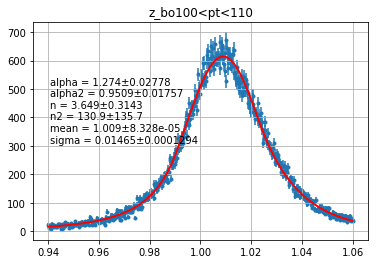

<Figure size 432x288 with 0 Axes>

1.0045018430832913


FCN = 337.723090097 
 TOTAL NCALL = 464 
 NCALLS = 453 
 
 
 EDM = 0.353995169731 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.16236 
 0.0217796 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.838007 
 0.0082203 
 
 
 
 
 No 
 
 
 2 
 n 
 4.702 
 0.479966 
 
 
 
 
 No 
 
 
 3 
 n2 
 118.457 
 82.6455 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00859 
 8.71616e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.16236 & 0.0217796 & & & & & No\\
\hline
1 & alpha2 & 0.838007 & 0.0082203 & & & & & No\\
\hline
2 & n & 4.702 & 0.479966 & & & & & No\\
\hline
3 & n2 & 118.457 & 82.6455 & & & & & No\\
\hline
4 & mean & 1.00859 & 8.71616e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 337.606596318 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 5.87334173689e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.16236 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.838007 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 4.702 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 118.457 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00859 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0150283 
 5.87309e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.16236 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.838007 & 1 & & & & & Yes\\
\hline
2 & n & 4.702 & 1 & & & & & Yes\\
\hline
3 & n2 & 118.457 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00859 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0150283 & 5.87309e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 337.606596318 
 TOTAL NCALL = 93 
 NCALLS = 82 
 
 
 EDM = 0.852208656281 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.16236 
 0.026481 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.838007 
 0.0141487 
 
 
 
 
 No 
 
 
 2 
 n 
 4.702 
 0.471732 
 
 
 
 
 No 
 
 
 3 
 n2 
 118.457 
 75.5377 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00859 
 9.24472e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0150283 
 0.000143833 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.16236 & 0.026481 & & & & & No\\
\hline
1 & alpha2 & 0.838007 & 0.0141487 & & & & & No\\
\hline
2 & n & 4.702 & 0.471732 & & & & & No\\
\hline
3 & n2 & 118.457 & 75.5377 & & & & & No\\
\hline
4 & mean & 1.00859 & 9.24472e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0150283 & 0.000143833 & & & & & No\\
\hline
\end{tabular}

90<pt<100
21


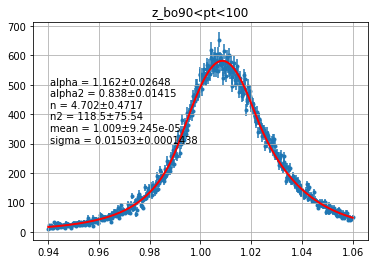

<Figure size 432x288 with 0 Axes>

1.0064272807545565


FCN = 380.094640527 
 TOTAL NCALL = 499 
 NCALLS = 488 
 
 
 EDM = 0.441091109182 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.08181 
 0.0243601 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.71146 
 0.00675494 
 
 
 
 
 No 
 
 
 2 
 n 
 4.98536 
 0.628102 
 
 
 
 
 No 
 
 
 3 
 n2 
 124.57 
 63.1261 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00786 
 0.000104693 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.08181 & 0.0243601 & & & & & No\\
\hline
1 & alpha2 & 0.71146 & 0.00675494 & & & & & No\\
\hline
2 & n & 4.98536 & 0.628102 & & & & & No\\
\hline
3 & n2 & 124.57 & 63.1261 & & & & & No\\
\hline
4 & mean & 1.00786 & 0.000104693 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 378.097854869 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 1.74039697056e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.08181 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.71146 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 4.98536 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 124.57 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00786 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0151277 
 6.43159e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.08181 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.71146 & 1 & & & & & Yes\\
\hline
2 & n & 4.98536 & 1 & & & & & Yes\\
\hline
3 & n2 & 124.57 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00786 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0151277 & 6.43159e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 378.097854869 
 TOTAL NCALL = 93 
 NCALLS = 82 
 
 
 EDM = 16.996011254 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.08181 
 0.0267934 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.71146 
 0.0136617 
 
 
 
 
 No 
 
 
 2 
 n 
 4.98536 
 0.49349 
 
 
 
 
 No 
 
 
 3 
 n2 
 124.57 
 54.0435 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00786 
 0.000111276 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0151277 
 0.000188736 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.08181 & 0.0267934 & & & & & No\\
\hline
1 & alpha2 & 0.71146 & 0.0136617 & & & & & No\\
\hline
2 & n & 4.98536 & 0.49349 & & & & & No\\
\hline
3 & n2 & 124.57 & 54.0435 & & & & & No\\
\hline
4 & mean & 1.00786 & 0.000111276 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0151277 & 0.000188736 & & & & & No\\
\hline
\end{tabular}

FCN = 378.097854869 
 TOTAL NCALL = 62 
 NCALLS = 51 
 
 
 EDM = 2.21528921231 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.08181 
 0.0162777 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.71146 
 0.00559294 
 
 
 
 
 No 
 
 
 2 
 n 
 4.98536 
 0.438218 
 
 
 
 
 No 
 
 
 3 
 n2 
 124.57 
 53.8971 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00786 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0151277 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.08181 & 0.0162777 & & & & & No\\
\hline
1 & alpha2 & 0.71146 & 0.00559294 & & & & & No\\
\hline
2 & n & 4.98536 & 0.438218 & & & & & No\\
\hline
3 & n2 & 124.57 & 53.8971 & & & & & No\\
\hline
4 & mean & 1.00786 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0151277 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 378.097854869 
 TOTAL NCALL = 93 
 NCALLS = 82 
 
 
 EDM = 16.996011254 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.08181 
 0.0267934 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.71146 
 0.0136617 
 
 
 
 
 No 
 
 
 2 
 n 
 4.98536 
 0.49349 
 
 
 
 
 No 
 
 
 3 
 n2 
 124.57 
 54.0435 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00786 
 0.000111276 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0151277 
 0.000188736 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.08181 & 0.0267934 & & & & & No\\
\hline
1 & alpha2 & 0.71146 & 0.0136617 & & & & & No\\
\hline
2 & n & 4.98536 & 0.49349 & & & & & No\\
\hline
3 & n2 & 124.57 & 54.0435 & & & & & No\\
\hline
4 & mean & 1.00786 & 0.000111276 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0151277 & 0.000188736 & & & & & No\\
\hline
\end{tabular}

80<pt<90
22


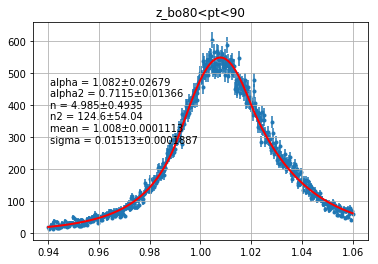

<Figure size 432x288 with 0 Axes>

1.0088463816529842


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.0, 1.0, -2.847221540189997, 4.0, 1.004, 0.015)


FCN = 6068.69165615 
 TOTAL NCALL = 100 
 NCALLS = 89 
 
 
 EDM = 30882.7934615 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 0.00285641 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1 
 0.0509351 
 
 
 
 
 No 
 
 
 2 
 n 
 4.79688 
 0.0439667 
 
 
 
 
 No 
 
 
 3 
 n2 
 4 
 1.22264 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.004 
 6.83747e-05 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 0.00285641 & & & & & No\\
\hline
1 & alpha2 & 1 & 0.0509351 & & & & & No\\
\hline
2 & n & 4.79688 & 0.0439667 & & & & & No\\
\hline
3 & n2 & 4 & 1.22264 & & & & & No\\
\hline
4 & mean & 1.004 & 6.83747e-05 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 4492.16603794 
 TOTAL NCALL = 26 
 NCALLS = 26 
 
 
 EDM = 1.84016462998e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 1 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 4.79688 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 4 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.004 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0182052 
 6.3697e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 1 & 1 & & & & & Yes\\
\hline
2 & n & 4.79688 & 1 & & & & & Yes\\
\hline
3 & n2 & 4 & 1 & & & & & Yes\\
\hline
4 & mean & 1.004 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0182052 & 6.3697e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 427.931987086 
 TOTAL NCALL = 314 
 NCALLS = 314 
 
 
 EDM = 2.42976271692e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.39602 
 0.020006 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.929302 
 0.0171674 
 
 
 
 
 No 
 
 
 2 
 n 
 2.37374 
 0.0656938 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.47232 
 0.320958 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00947 
 0.000115871 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0189283 
 0.000174855 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.39602 & 0.020006 & & & & & No\\
\hline
1 & alpha2 & 0.929302 & 0.0171674 & & & & & No\\
\hline
2 & n & 2.37374 & 0.0656938 & & & & & No\\
\hline
3 & n2 & 6.47232 & 0.320958 & & & & & No\\
\hline
4 & mean & 1.00947 & 0.000115871 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0189283 & 0.000174855 & & & & & No\\
\hline
\end{tabular}

70<pt<80
23


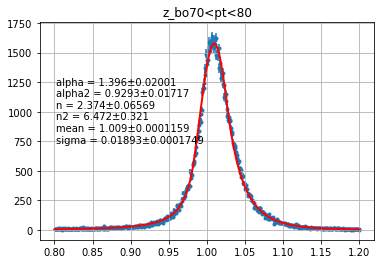

<Figure size 432x288 with 0 Axes>

1.0121268243624808


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.0, 1.0, -3.904466074974259, 4.0, 1.004, 0.015)


FCN = 644.451948172 
 TOTAL NCALL = 399 
 NCALLS = 399 
 
 
 EDM = 4.3181276439e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.930586 
 0.0112408 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.561372 
 0.00593411 
 
 
 
 
 No 
 
 
 2 
 n 
 3.41404 
 0.0886175 
 
 
 
 
 No 
 
 
 3 
 n2 
 17.6227 
 1.73959 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.00956 
 0.000135944 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.930586 & 0.0112408 & & & & & No\\
\hline
1 & alpha2 & 0.561372 & 0.00593411 & & & & & No\\
\hline
2 & n & 3.41404 & 0.0886175 & & & & & No\\
\hline
3 & n2 & 17.6227 & 1.73959 & & & & & No\\
\hline
4 & mean & 1.00956 & 0.000135944 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 637.634653936 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 1.81298836954e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.930586 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.561372 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.41404 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 17.6227 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.00956 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0151904 
 5.20114e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.930586 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.561372 & 1 & & & & & Yes\\
\hline
2 & n & 3.41404 & 1 & & & & & Yes\\
\hline
3 & n2 & 17.6227 & 1 & & & & & Yes\\
\hline
4 & mean & 1.00956 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0151904 & 5.20114e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 353.664348622 
 TOTAL NCALL = 391 
 NCALLS = 391 
 
 
 EDM = 9.39710849849e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.36529 
 0.0200604 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.898418 
 0.0170199 
 
 
 
 
 No 
 
 
 2 
 n 
 2.44731 
 0.0720486 
 
 
 
 
 No 
 
 
 3 
 n2 
 7.67757 
 0.474861 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01137 
 0.000129313 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0208517 
 0.000193689 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.36529 & 0.0200604 & & & & & No\\
\hline
1 & alpha2 & 0.898418 & 0.0170199 & & & & & No\\
\hline
2 & n & 2.44731 & 0.0720486 & & & & & No\\
\hline
3 & n2 & 7.67757 & 0.474861 & & & & & No\\
\hline
4 & mean & 1.01137 & 0.000129313 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0208517 & 0.000193689 & & & & & No\\
\hline
\end{tabular}

60<pt<70
24


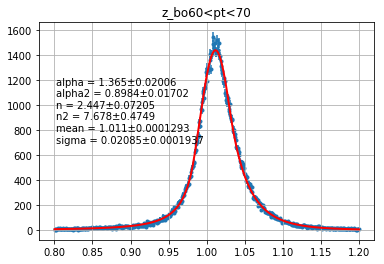

<Figure size 432x288 with 0 Axes>

1.0152562765230204


FCN = 638.431990894 
 TOTAL NCALL = 397 
 NCALLS = 397 
 
 
 EDM = 6.09073894672e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.74435 
 0.00896006 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.518199 
 0.0061089 
 
 
 
 
 No 
 
 
 2 
 n 
 5.17465 
 0.176497 
 
 
 
 
 No 
 
 
 3 
 n2 
 14.5068 
 1.37132 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.0123 
 0.000162274 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.74435 & 0.00896006 & & & & & No\\
\hline
1 & alpha2 & 0.518199 & 0.0061089 & & & & & No\\
\hline
2 & n & 5.17465 & 0.176497 & & & & & No\\
\hline
3 & n2 & 14.5068 & 1.37132 & & & & & No\\
\hline
4 & mean & 1.0123 & 0.000162274 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (0.7443502587288818, 0.5181987571866833, 5.174650621359231, 14.506757071621493, 1.0122994437357709, -0.0024546978920872743)


FCN = 635.845472512 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 3.33207671088e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.74435 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.518199 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 5.17465 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 14.5068 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.0123 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0151186 
 5.241e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.74435 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.518199 & 1 & & & & & Yes\\
\hline
2 & n & 5.17465 & 1 & & & & & Yes\\
\hline
3 & n2 & 14.5068 & 1 & & & & & Yes\\
\hline
4 & mean & 1.0123 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0151186 & 5.241e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 379.379000963 
 TOTAL NCALL = 392 
 NCALLS = 392 
 
 
 EDM = 8.74335780332e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.23839 
 0.0225245 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.883262 
 0.0172798 
 
 
 
 
 No 
 
 
 2 
 n 
 3.31626 
 0.121918 
 
 
 
 
 No 
 
 
 3 
 n2 
 6.83836 
 0.422849 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01368 
 0.000136281 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0224685 
 0.000235208 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.23839 & 0.0225245 & & & & & No\\
\hline
1 & alpha2 & 0.883262 & 0.0172798 & & & & & No\\
\hline
2 & n & 3.31626 & 0.121918 & & & & & No\\
\hline
3 & n2 & 6.83836 & 0.422849 & & & & & No\\
\hline
4 & mean & 1.01368 & 0.000136281 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0224685 & 0.000235208 & & & & & No\\
\hline
\end{tabular}

50<pt<60
25


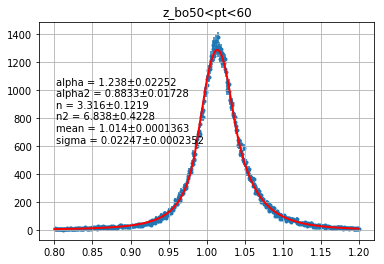

<Figure size 432x288 with 0 Axes>

1.0200422208614193


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.0, 1.0, -2.367864778896527, 4.0, 1.004, 0.015)


FCN = 992.919308252 
 TOTAL NCALL = 334 
 NCALLS = 334 
 
 
 EDM = 3.17960822425e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.690993 
 0.00722594 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.531631 
 0.00519344 
 
 
 
 
 No 
 
 
 2 
 n 
 3.59762 
 0.0646784 
 
 
 
 
 No 
 
 
 3 
 n2 
 4.43825 
 0.087262 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01325 
 0.000176075 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.690993 & 0.00722594 & & & & & No\\
\hline
1 & alpha2 & 0.531631 & 0.00519344 & & & & & No\\
\hline
2 & n & 3.59762 & 0.0646784 & & & & & No\\
\hline
3 & n2 & 4.43825 & 0.087262 & & & & & No\\
\hline
4 & mean & 1.01325 & 0.000176075 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 988.908844159 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 1.7262805325e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.690993 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.531631 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 3.59762 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 4.43825 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.01325 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0151606 
 5.70498e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.690993 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.531631 & 1 & & & & & Yes\\
\hline
2 & n & 3.59762 & 1 & & & & & Yes\\
\hline
3 & n2 & 4.43825 & 1 & & & & & Yes\\
\hline
4 & mean & 1.01325 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0151606 & 5.70498e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 481.789697382 
 TOTAL NCALL = 298 
 NCALLS = 298 
 
 
 EDM = 4.88470101975e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.26153 
 0.0168234 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.997484 
 0.0141476 
 
 
 
 
 No 
 
 
 2 
 n 
 2.6016 
 0.0542392 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.28243 
 0.068076 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01489 
 0.000143436 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0259933 
 0.000235435 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.26153 & 0.0168234 & & & & & No\\
\hline
1 & alpha2 & 0.997484 & 0.0141476 & & & & & No\\
\hline
2 & n & 2.6016 & 0.0542392 & & & & & No\\
\hline
3 & n2 & 3.28243 & 0.068076 & & & & & No\\
\hline
4 & mean & 1.01489 & 0.000143436 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0259933 & 0.000235435 & & & & & No\\
\hline
\end{tabular}

40<pt<50
26


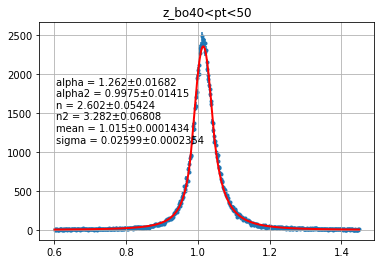

<Figure size 432x288 with 0 Axes>

1.0321437481440636


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.0, 1.0, -5.568991629614656, 4.0, 1.004, 0.015)


FCN = 840.121857994 
 TOTAL NCALL = 371 
 NCALLS = 371 
 
 
 EDM = 3.5080370605e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.498292 
 0.00540457 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.462701 
 0.00511644 
 
 
 
 
 No 
 
 
 2 
 n 
 4.84078 
 0.11524 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.76798 
 0.0739246 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01817 
 0.000232054 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.498292 & 0.00540457 & & & & & No\\
\hline
1 & alpha2 & 0.462701 & 0.00511644 & & & & & No\\
\hline
2 & n & 4.84078 & 0.11524 & & & & & No\\
\hline
3 & n2 & 3.76798 & 0.0739246 & & & & & No\\
\hline
4 & mean & 1.01817 & 0.000232054 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 839.139569636 
 TOTAL NCALL = 20 
 NCALLS = 20 
 
 
 EDM = 8.21029145576e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.498292 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.462701 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 4.84078 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.76798 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.01817 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0150802 
 5.7382e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.498292 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.462701 & 1 & & & & & Yes\\
\hline
2 & n & 4.84078 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.76798 & 1 & & & & & Yes\\
\hline
4 & mean & 1.01817 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0150802 & 5.7382e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 467.647817082 
 TOTAL NCALL = 310 
 NCALLS = 310 
 
 
 EDM = 3.24533849328e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.05259 
 0.018307 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.955554 
 0.0159812 
 
 
 
 
 No 
 
 
 2 
 n 
 3.49175 
 0.0899887 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.88783 
 0.0626523 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.01887 
 0.000177179 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0296347 
 0.000358082 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.05259 & 0.018307 & & & & & No\\
\hline
1 & alpha2 & 0.955554 & 0.0159812 & & & & & No\\
\hline
2 & n & 3.49175 & 0.0899887 & & & & & No\\
\hline
3 & n2 & 2.88783 & 0.0626523 & & & & & No\\
\hline
4 & mean & 1.01887 & 0.000177179 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0296347 & 0.000358082 & & & & & No\\
\hline
\end{tabular}

30<pt<40
27


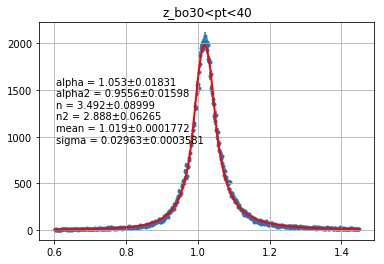

<Figure size 432x288 with 0 Axes>

1.0572722330250102


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:103: SmallIntegralWarning: (1.0, 1.0, 0.5819560129832944, 4.0, 1.004, 0.015)


FCN = 1083.4852664 
 TOTAL NCALL = 377 
 NCALLS = 377 
 
 
 EDM = 6.96053357039e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.385413 
 0.00410353 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 0.363785 
 0.00393571 
 
 
 
 
 No 
 
 
 2 
 n 
 4.77939 
 0.100919 
 
 
 
 
 No 
 
 
 3 
 n2 
 3.15366 
 0.0449015 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.02703 
 0.000321152 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.015 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.385413 & 0.00410353 & & & & & No\\
\hline
1 & alpha2 & 0.363785 & 0.00393571 & & & & & No\\
\hline
2 & n & 4.77939 & 0.100919 & & & & & No\\
\hline
3 & n2 & 3.15366 & 0.0449015 & & & & & No\\
\hline
4 & mean & 1.02703 & 0.000321152 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.015 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 1083.24500884 
 TOTAL NCALL = 24 
 NCALLS = 24 
 
 
 EDM = 1.79787856248e-11 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 0.385413 
 1 
 
 
 
 
 Yes 
 
 
 1 
 alpha2 
 0.363785 
 1 
 
 
 
 
 Yes 
 
 
 2 
 n 
 4.77939 
 1 
 
 
 
 
 Yes 
 
 
 3 
 n2 
 3.15366 
 1 
 
 
 
 
 Yes 
 
 
 4 
 mean 
 1.02703 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0150404 
 5.8326e-05 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 0.385413 & 1 & & & & & Yes\\
\hline
1 & alpha2 & 0.363785 & 1 & & & & & Yes\\
\hline
2 & n & 4.77939 & 1 & & & & & Yes\\
\hline
3 & n2 & 3.15366 & 1 & & & & & Yes\\
\hline
4 & mean & 1.02703 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0150404 & 5.8326e-05 & & & & & No\\
\hline
\end{tabular}

FCN = 491.652510754 
 TOTAL NCALL = 348 
 NCALLS = 348 
 
 
 EDM = 4.96436033013e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.16664 
 0.0199215 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.01169 
 0.0144125 
 
 
 
 
 No 
 
 
 2 
 n 
 3.13227 
 0.078214 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.43701 
 0.0403183 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.02799 
 0.000231888 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0415171 
 0.000458929 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.16664 & 0.0199215 & & & & & No\\
\hline
1 & alpha2 & 1.01169 & 0.0144125 & & & & & No\\
\hline
2 & n & 3.13227 & 0.078214 & & & & & No\\
\hline
3 & n2 & 2.43701 & 0.0403183 & & & & & No\\
\hline
4 & mean & 1.02799 & 0.000231888 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0415171 & 0.000458929 & & & & & No\\
\hline
\end{tabular}

FCN = 491.652510607 
 TOTAL NCALL = 58 
 NCALLS = 58 
 
 
 EDM = 3.12526874239e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.16664 
 0.0103853 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.01169 
 0.00828201 
 
 
 
 
 No 
 
 
 2 
 n 
 3.13227 
 0.0644605 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.43701 
 0.0355142 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.02799 
 1 
 
 
 0.9 
 1.1 
 Yes 
 
 
 5 
 sigma 
 0.0415171 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.16664 & 0.0103853 & & & & & No\\
\hline
1 & alpha2 & 1.01169 & 0.00828201 & & & & & No\\
\hline
2 & n & 3.13227 & 0.0644605 & & & & & No\\
\hline
3 & n2 & 2.43701 & 0.0355142 & & & & & No\\
\hline
4 & mean & 1.02799 & 1 & & & 0.9 & 1.1 & Yes\\
\hline
5 & $\sigma$ & 0.0415171 & 1 & & & & & Yes\\
\hline
\end{tabular}

FCN = 491.652510597 
 TOTAL NCALL = 96 
 NCALLS = 96 
 
 
 EDM = 3.40225874802e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 alpha 
 1.16664 
 0.0199217 
 
 
 
 
 No 
 
 
 1 
 alpha2 
 1.01169 
 0.0144123 
 
 
 
 
 No 
 
 
 2 
 n 
 3.13227 
 0.0782151 
 
 
 
 
 No 
 
 
 3 
 n2 
 2.437 
 0.0403175 
 
 
 
 
 No 
 
 
 4 
 mean 
 1.02799 
 0.000231888 
 
 
 0.9 
 1.1 
 No 
 
 
 5 
 sigma 
 0.0415171 
 0.00045893 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $\alpha$ & 1.16664 & 0.0199217 & & & & & No\\
\hline
1 & alpha2 & 1.01169 & 0.0144123 & & & & & No\\
\hline
2 & n & 3.13227 & 0.0782151 & & & & & No\\
\hline
3 & n2 & 2.437 & 0.0403175 & & & & & No\\
\hline
4 & mean & 1.02799 & 0.000231888 & & & 0.9 & 1.1 & No\\
\hline
5 & $\sigma$ & 0.0415171 & 0.00045893 & & & & & No\\
\hline
\end{tabular}

20<pt<30
28


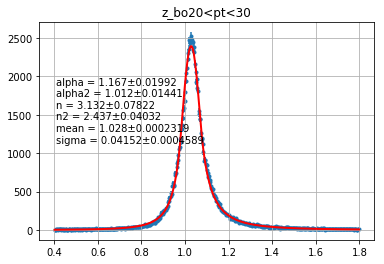

In [17]:
tipe='z_bo'
i=0
for para in feat_pt:
    if i>22:
        if i>25 and i!=28:
            rmin=0.6
            rmax=1.45
        elif i==28:
            rmin=0.4
            rmax=1.8
        else:
            rmin=0.8
            rmax=1.2
    
    elif i==4 or i==5 or 14<=i<=16 or i==19:
        rmin=0.9
        rmax=1.1
    else:
        rmin = 0.94
        rmax = 1.06
    
    df=data.query(para).astype('double')
    df=df[tipe]
    bound_DCB=[rmin, rmax]
    plt.figure()
    hist,bin_edge=np.histogram(df,bins=nbins)
    plt.show()
    hist_mean=np.mean(hist)
    a=RMS(hist,bin_edge)
    b=evaleffrms(hist,bin_edge)
    c=histsigma(hist,bin_edge)
    normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
    binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
   
    for j in range(5):
        #first step
        if j==0: 
            pars_dcb = dict(mean  = 1.004, 
                        fix_mean = False,
                        sigma  = 0.015,
                        fix_sigma = True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 10,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 4,
                        fix_n2  = False
        
                           )
        
        
        elif j==1:
                pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = True,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = True
                        )
                
        elif j==3:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = True,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
                
        #optimize parameter withoptimized start parameter
        else:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
    
        minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_mean=(0.9,1.1), **pars_dcb)
        minuit.migrad() #optimized parameter
        if i!=7 and i !=9 and i!=22 and i!=28:
            if j==2:
                break
            else:
                pass
     
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
    binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    if tipe=='target':
        mean_pt_un[i]=minuit.values['mean']
        mean_err_pt_un[i]=minuit.errors['mean']
        sigma_pt_un[i]=minuit.values['sigma']
        sigma_err_pt_un[i]=minuit.errors['sigma']
    if tipe=='z_default':
        mean_pt_de[i]=minuit.values['mean']
        mean_err_pt_de[i]=minuit.errors['mean']
        sigma_pt_de[i]=minuit.values['sigma']
        sigma_err_pt_de[i]=minuit.errors['sigma']       
    if tipe=='z_bo':
        mean_pt_bo[i]=minuit.values['mean']
        mean_err_pt_bo[i]=minuit.errors['mean']
        sigma_pt_bo[i]=minuit.values['sigma']
        sigma_err_pt_bo[i]=minuit.errors['sigma']
        Eff_sigma_pt_bo[i]=b
        rms_pt_bo[i]=a
        histsigma_pt_bo[i]=c
    print(para)
    print(i)
    i+=1
    if i==29:
        i=0
        
    plt.title(tipe+para)
    plt.savefig(os.path.join(out_dir+'plot',tipe+para+'_fit'+'.png'))
    plt.show()
np.savetxt('pt_parameter_bo.csv', (mean_pt_bo,sigma_pt_bo), delimiter=',')

In [18]:
Target_alone=np.loadtxt('pt_parameter_Uncorrected.csv',delimiter=',')
l=np.size((Target_alone))
print(Target_alone)
mean_pt_un_alone=Target_alone[:l/2]
sigma_pt_un_alone=Target_alone[l/2:]
print(mean_pt_un_alone)
print(sigma_pt_un_alone)


[[1.0055705  1.00126707 1.00119106 1.00091728 1.00077728 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.00802442 0.00815007 0.00800885 0.00826566 0.00824738 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
[[1.0055705  1.00126707 1.00119106 1.00091728 1.00077728 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.00802442 0.00815007 0.00800885 0.00826566 0.00824738 0.
  0.         0.         0.         0.        

ValueError: shape mismatch: objects cannot be broadcast to a single shape

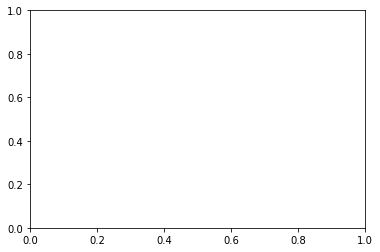

In [19]:
sigma_err_pt_un[26]=0
mean_err_pt_un[26]=0
plt.figure()
plt.errorbar(pt,mean_pt_un_alone, yerr=mean_err_pt_un, fmt='b.',label='uncorrected',ecolor='black',capsize=1)
plt.errorbar(pt,mean_pt_de, yerr=mean_err_pt_de, fmt='k.',label='default',ecolor='black',capsize=1)
plt.errorbar(pt,mean_pt_bo, yerr=mean_err_pt_bo, fmt='r.',label='optimized',ecolor='black',capsize=1)
plt.title('mean against pt')
plt.xlabel('pt')
plt.ylabel('mean')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','mean_against_pt'+'.png'))
plt.show()

plt.figure()
plt.errorbar(pt,sigma_pt_un_alone, yerr=sigma_err_pt_un, fmt='b.',label='uncorrected',ecolor='black',capsize=1)
plt.errorbar(pt,sigma_pt_de, yerr=sigma_err_pt_de, fmt='k.',label='default',ecolor='black',capsize=1)
plt.errorbar(pt,sigma_pt_bo, yerr=sigma_err_pt_bo, fmt='r.',label='optimized',ecolor='black',capsize=1)
plt.title('sigma against pt')
plt.xlabel('pt')
plt.ylabel('$\sigma$')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','sigma_against_pt'+'.png'))
plt.show()

plt.figure()
plt.plot(pt,Eff_sigma_pt_un,'b.',label='uncorrected')
plt.plot(pt,Eff_sigma_pt_de,'k.',label='default')
plt.plot(pt,Eff_sigma_pt_bo,'r.',label='optimized')
plt.title('Eff_sigma against pt')
plt.xlabel('pt')
plt.ylabel('Effective $\sigma$')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','Eff_sigma_against_pt'+'.png'))

plt.show()

plt.figure()
plt.plot(pt,rms_pt_un,'b.',label='uncorrected')
plt.plot(pt,rms_pt_de,'k.',label='default')
plt.plot(pt,rms_pt_bo,'r.',label='optimized')
plt.title('RMS against pt')
plt.xlabel('pt')
plt.ylabel('RMS')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','RMS_against_pt'+'.png'))


plt.show()


plt.figure()
plt.plot(pt,histsigma_pt_un,'b.',label='uncorrected')
plt.plot(pt,histsigma_pt_de,'k.',label='default')
plt.plot(pt,histsigma_pt_bo,'r.',label='optimized')
plt.title('histsigma against pt')
plt.xlabel('pt')
plt.ylabel('hist sigma')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_dir+'plot','histsigma_against_pt'+'.png'))


plt.show()